# Credit Score Model- Kaggle Public Dataset

# Importando bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from scipy.stats import zscore

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier

from sklearn.metrics import accuracy_score, classification_report

import lightgbm as lgb

from boruta import BorutaPy
import xgboost as xgb

%matplotlib inline
%pylab inline
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
pd.set_option( 'display.expand_frame_repr', False )
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Variáveis




'ID' - Chave única de identificação da entrada

'Customer_ID' - Chave única de identificação da pessoa

'Month' - Mês de referência

'Name' - Nome do cliente

'Age' - Idade

'SSN' - Documento de identificação

'Occupation' - Profissão

'Annual_Income' - Renda Anual

'Monthly_Inhand_Salary' - Salario Base Mensal

'Num_Bank_Accounts' - Número de Contas Bancárias

'Num_Credit_Card' - Número de Cartões de Crédito

'Interest_Rate' - Taxa de Juros

'Num_of_Loan' - Número de Emprestimos

'Type_of_Loan' - Tipo de Emprestimos

'Delay_from_due_date' - Dias médios de atraso da data de vencimento

'Num_of_Delayed_Payment' - Número de atrasos

'Changed_Credit_Limit' - Percentual de mudança no limite do cartão de crédito

'Num_Credit_Inquiries' - Números de consultas em Bureau

'Credit_Mix' - Classificação do nivel de diversidade de credito

'Outstanding_Debt' - Divída em aberto

'Credit_Utilization_Ratio' - Total utilizado em relação ao limite

'Credit_History_Age' - Tempo de crédito no mercado

'Payment_of_Min_Amount' - Representa se foi feito pagamento mínimo

'Total_EMI_per_month' - Parcela fixa mensal (principal + juros)

'Amount_invested_monthly' - Total investido no mês

'Payment_Behaviour' - Comportamento de Pagamento do cliente

'Monthly_Balance' - Saldo Mensal

'Credit_Score' - Score de Crédito

# Funções Auxiliares

In [2]:
# Função para desaninhar a lista  
def desaninhar(lista_aninhada):
    resultado = []
    for elemento in lista_aninhada:
        if isinstance(elemento, list):
            resultado.extend(desaninhar(elemento))
        else:
            resultado.append(elemento)
    return resultado


# Função para calcular a moda de itens em uma lista removendo os vazios
def calcular_moda(lista):
    
    nova_lista = [item for item in lista if item != '']
    contador = Counter(nova_lista)
    return contador.most_common(1)[0][0]

## Metodo kramer v para correlação de variaveis categoricas
def cramer_v (x,y):

    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - ((k-1)*(r-1)/(n-1))) # Valores com vieses corrigidos


    kcorr =  k - ((k-1)**2/(n-1))  # Valores com vieses corrigidos
    rcorr =  r - ((r-1)**2/(n-1))  # Valores com vieses corrigidos
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

# Explorando os dados

In [ ]:
#Carregando a base de dados
data = pd.read_csv('train.csv')

In [4]:
data['Customer_ID'].nunique()

12500

In [5]:
# Nome das colunas da base de dados
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

## Tratamento inicial das variáveis

In [6]:
df1 = data.copy()

In [7]:
# Verificando o tipo das variáveis
df1.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

### Alterando os tipos das variáveis

In [8]:
df1['Annual_Income'] =  df1['Annual_Income'].apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Annual_Income'] = df1['Annual_Income'].astype(np.float64)

In [9]:
df1['Num_of_Loan'] =  df1['Num_of_Loan'].apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Num_of_Loan'] = df1['Num_of_Loan'].astype(np.int64)

In [10]:
df1['Num_of_Delayed_Payment'] = df1['Num_of_Delayed_Payment'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Num_of_Delayed_Payment'] = pd.to_numeric(df1['Num_of_Delayed_Payment'],errors='coerce')

In [11]:
df1['Changed_Credit_Limit'] = df1['Changed_Credit_Limit'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Changed_Credit_Limit'] = pd.to_numeric(df1['Changed_Credit_Limit'],errors='coerce')
df1['Changed_Credit_Limit'] = df1['Changed_Credit_Limit'].astype(float)

In [12]:
df1['Outstanding_Debt'] = df1['Outstanding_Debt'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Outstanding_Debt'] = pd.to_numeric(df1['Outstanding_Debt'],errors='coerce')
df1['Outstanding_Debt'] = df1['Outstanding_Debt'].astype(float)

In [13]:
df1['Num_Credit_Inquiries'] = df1['Num_Credit_Inquiries'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Num_Credit_Inquiries'] = pd.to_numeric(df1['Num_Credit_Inquiries'],errors='coerce')

In [14]:
df1['Amount_invested_monthly'] = df1['Amount_invested_monthly'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Amount_invested_monthly'] = pd.to_numeric(df1['Amount_invested_monthly'],errors='coerce')
df1['Amount_invested_monthly'] = df1['Amount_invested_monthly'].astype(float)

In [15]:
df1['Monthly_Balance'] = df1['Monthly_Balance'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Monthly_Balance'] = pd.to_numeric(df1['Monthly_Balance'],errors='coerce')
df1['Monthly_Balance'] = df1['Monthly_Balance'].astype(float)

### Tratando a coluna Type_of_Loan

In [16]:
resultado = []

# Criando uma lista com todas as entradas da coluna Type_of_Loan
lista_texto = list(df1['Type_of_Loan'].astype(str))

# Separando os tipos de emprestimo dentro da lista
for loan in lista_texto:
    text = re.split(r',|and', loan)
    resultado.append(text)

# Criando uma lista com valores únicos de tipo de emprestimo
loan_types = desaninhar(resultado)
loan_types = list(set(loan_types))

# Tratando a lista criada
nova_lista = []
for type in loan_types:
    texto_puro = re.sub(r'\s+|nan|','',type)
    nova_lista.append(texto_puro)

# Removendo valores vazios na lista   
lista_sem_vazios = [item for item in nova_lista if item != '']
loan_types = list(set(lista_sem_vazios))

# Removendo os espaços na coluna Type_of_Loan
df1['Type_of_Loan'] = df1['Type_of_Loan'].astype(str).apply(lambda x: re.sub(r'\s+','',x))

# Criando uma coluna para cada tipo de emprestimo
for i in loan_types:
    df1[('loan_type_')+i] = np.nan
    df1[('loan_type_')+i] = df1['Type_of_Loan'].apply(lambda x: 1 if re.search(i,x) else 0)

# Dropando a coluna original de Type_of_Loan   
df1.drop('Type_of_Loan',axis=1,inplace=True)

### Tratando a Coluna Payment_Behaviour

In [17]:
df1['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: Payment_Behaviour, dtype: int64

In [18]:
# Trocando a sequencia de caracteres '!@9#%8' por ''
df1['Payment_Behaviour'] = df1['Payment_Behaviour'].replace('!@9#%8','')

# Substituindo na coluna Payment_Behaviour o valor vazio pela moda do grupo
df1.loc[df1['Payment_Behaviour']=='','Payment_Behaviour'] = df1.groupby('Customer_ID')['Payment_Behaviour'].transform(calcular_moda)

### Tratando a coluna Age

In [19]:
df1['Age'] = df1['Age'].astype(str).apply(lambda x: re.sub(r'[^0-9.]','',x))
df1['Age'] = pd.to_numeric(df1['Age'])
df1['Age'] = df1['Age'].astype(np.int64)

df1.loc[(df1['Age'] <=0) | (df1['Age'] >= 100), 'Age'] = ''

df1['Age'] = df1.groupby('Customer_ID')['Age'].transform(calcular_moda)

<AxesSubplot:xlabel='Age', ylabel='Count'>

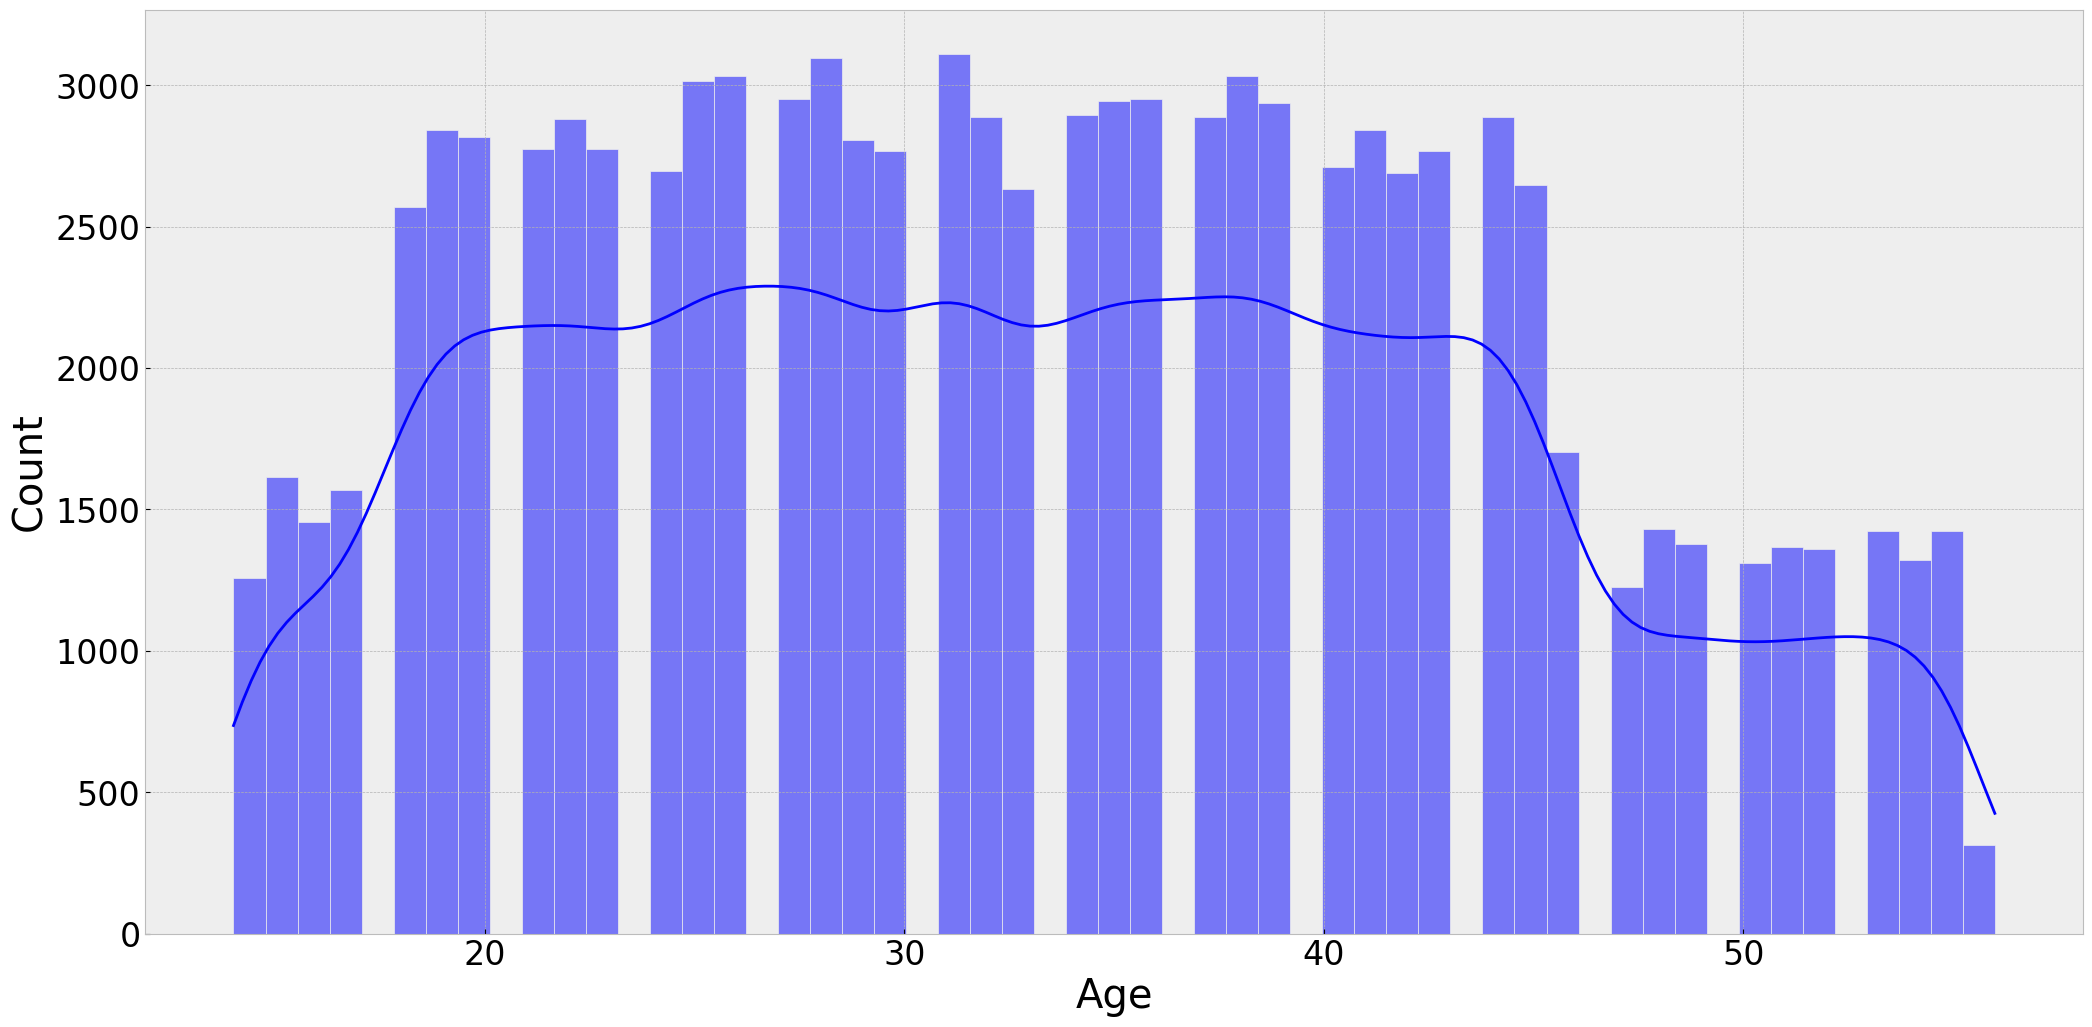

In [20]:
sns.histplot(df1['Age'],kde='density')

### Tratando a coluna Occupation

In [21]:
df1['Occupation'].value_counts(dropna=False)

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [22]:
df1['Occupation'] = df1['Occupation'].replace('_______','')
df1['Occupation'] = df1.groupby('Customer_ID')['Occupation'].transform(calcular_moda)
df1['Occupation'].value_counts(dropna=False)

Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6720
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: Occupation, dtype: int64

### Tratando a coluna Credit_Mix

In [23]:
df1['Credit_Mix'] = df1['Credit_Mix'].replace('_','')
df1['Credit_Mix'] = df1.groupby('Customer_ID')['Credit_Mix'].transform(calcular_moda)

In [24]:
df1['Credit_Mix'].value_counts(dropna=False)

Standard    45848
Good        30384
Bad         23768
Name: Credit_Mix, dtype: int64

### Dropando a coluna SSN, ID e Name

In [25]:
df1.drop('SSN',axis=1,inplace=True)
df1.drop('ID',axis=1,inplace=True)
df1.drop('Name',axis=1,inplace=True)

### Tratando a coluna Annual_Income

In [26]:
df1['Annual_Income'].value_counts(dropna=False)

17816.750       16
22434.160       16
40341.160       16
17273.830       16
109945.320      16
                ..
17079092.000     1
1910572.000      1
20179076.000     1
7980216.000      1
8299495.000      1
Name: Annual_Income, Length: 13487, dtype: int64

<AxesSubplot:xlabel='Annual_Income', ylabel='Count'>

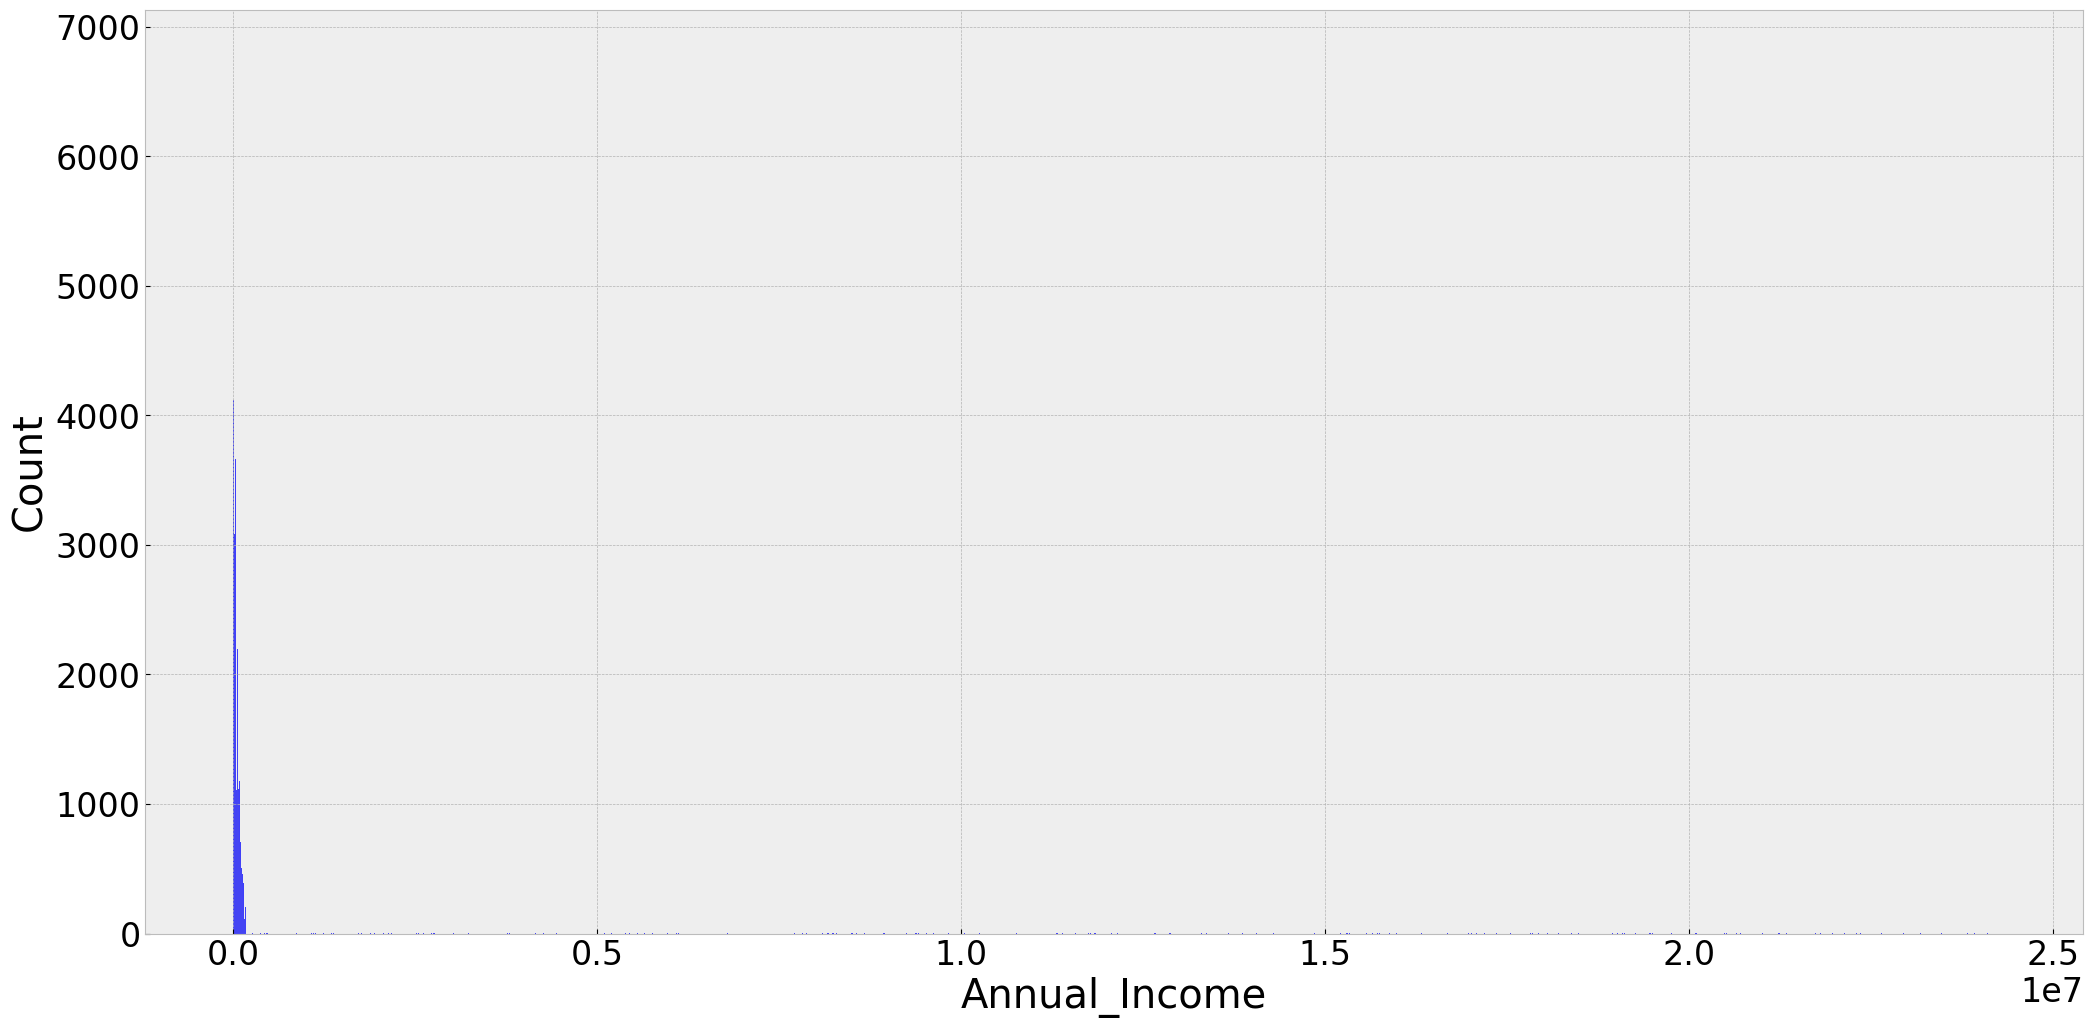

In [27]:
sns.histplot(df1['Annual_Income'])

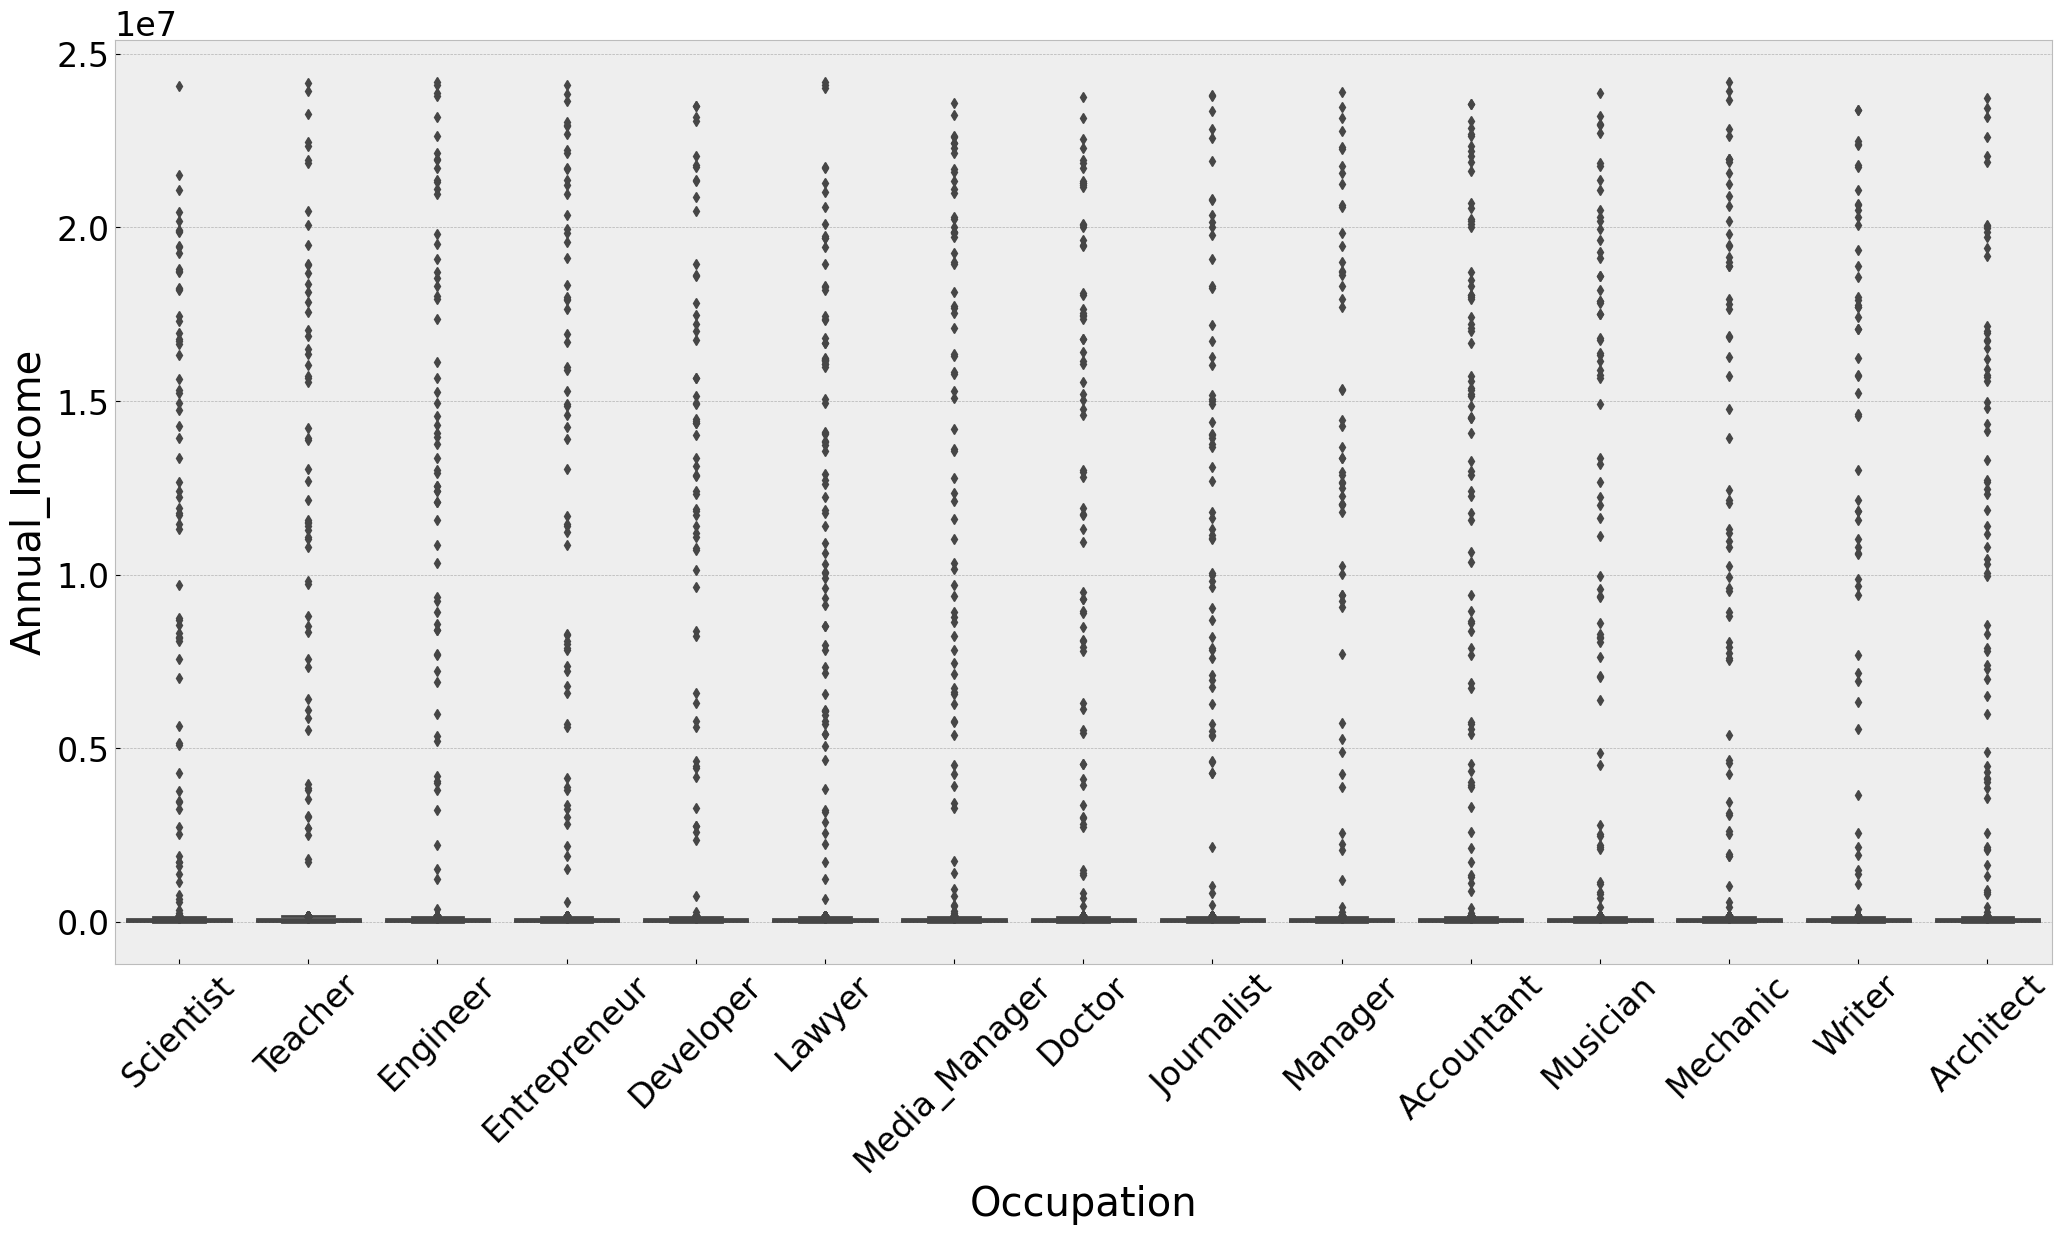

In [28]:
sns.boxplot(data = df1 , x='Occupation',y='Annual_Income')
plt.xticks(rotation=45)
plt.show()

In [29]:
df1['Annual_Income'] = df1.groupby('Customer_ID')['Annual_Income'].transform(calcular_moda)

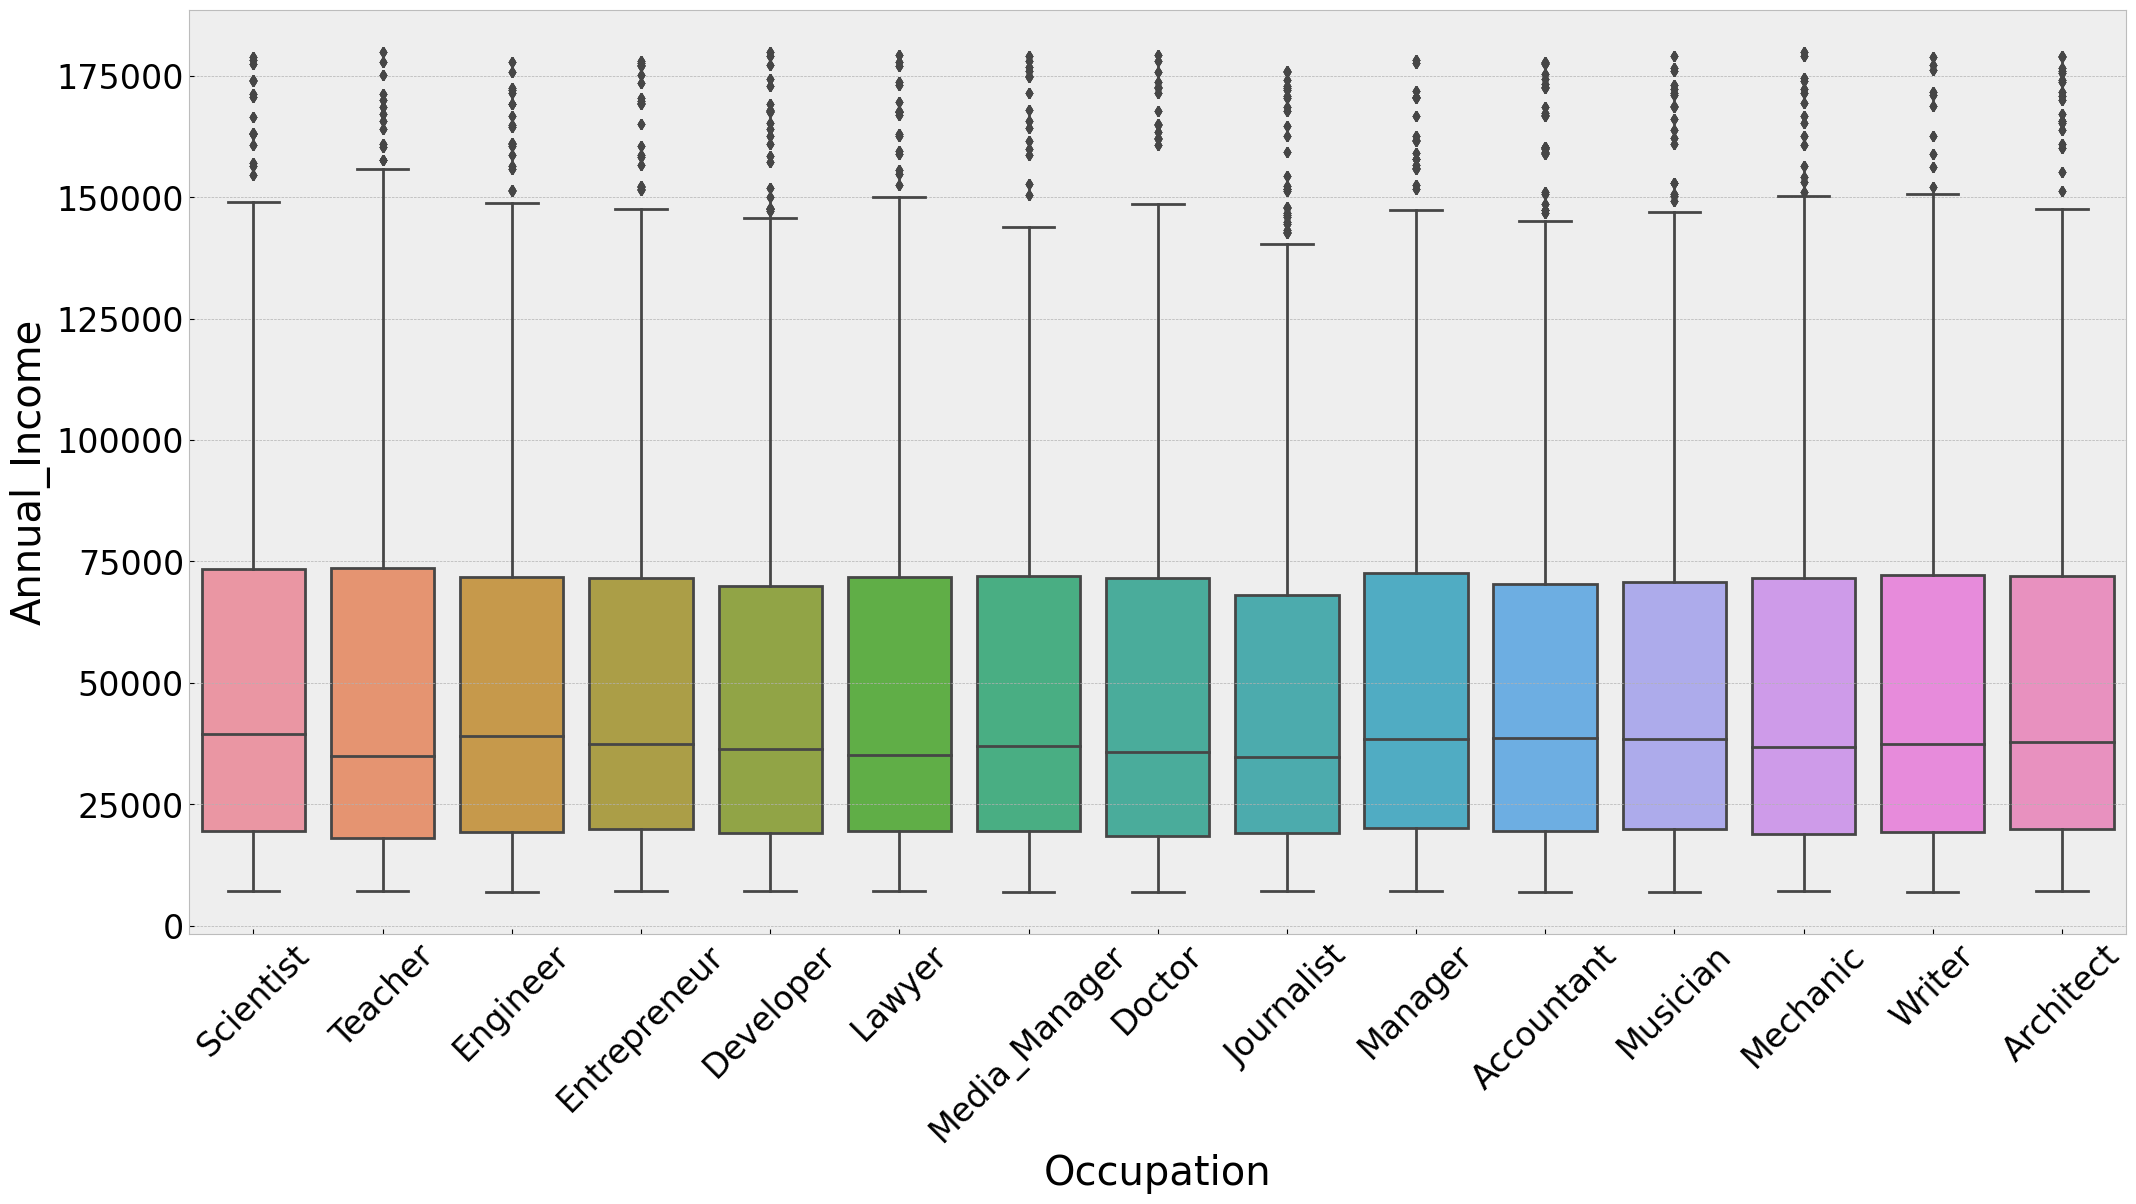

In [30]:
sns.boxplot(data = df1 , x='Occupation',y='Annual_Income')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='Annual_Income', ylabel='Count'>

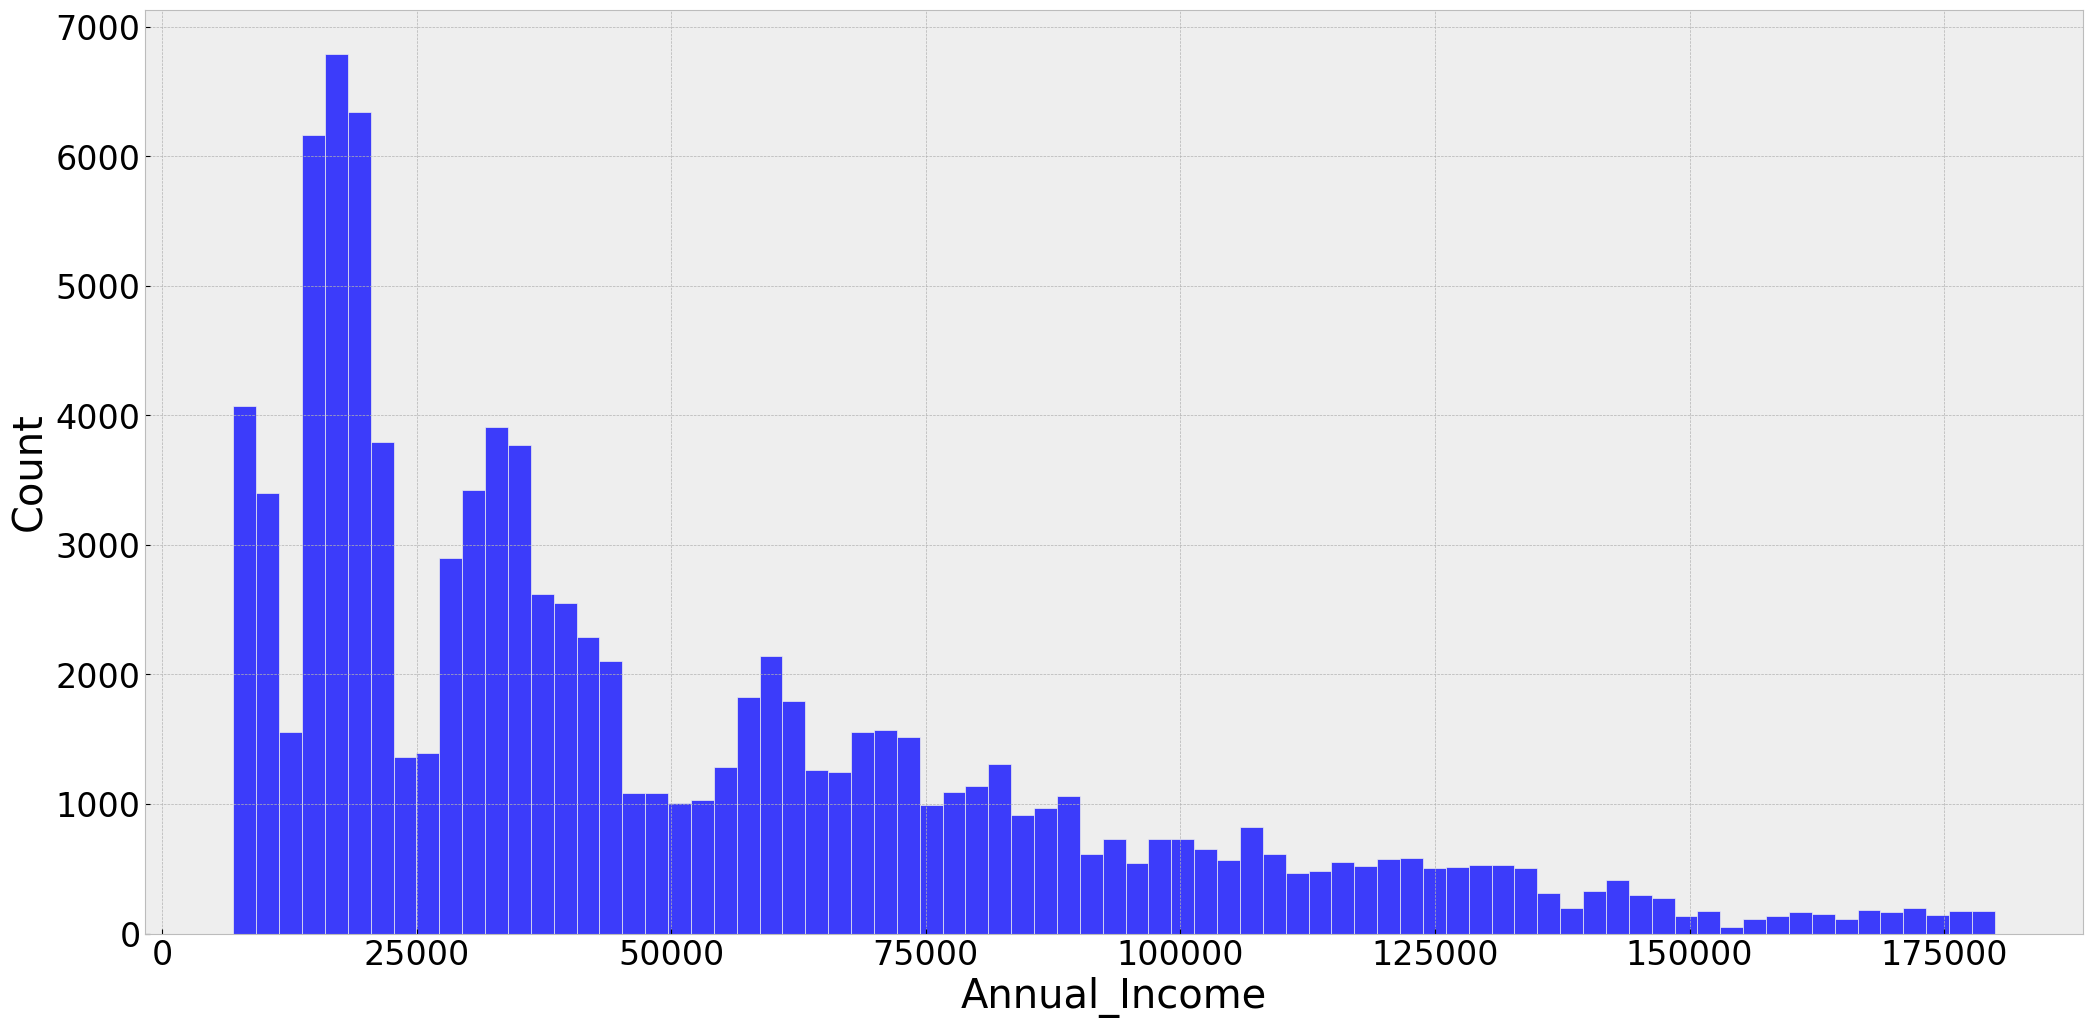

In [31]:
sns.histplot(df1['Annual_Income'])

In [32]:
df1['Annual_Income'].value_counts()

20867.670    16
9141.630     16
32543.380    16
40341.160    16
22434.160    16
             ..
18317.260     8
14784.450     8
60573.960     8
18413.795     8
39628.990     8
Name: Annual_Income, Length: 12488, dtype: int64

### Tratando a coluna Monthly_Inhand_Salary

In [33]:
df1['Monthly_Inhand_Salary'].describe()

count   84998.000
mean     4194.171
std      3183.686
min       303.645
25%      1625.568
50%      3093.745
75%      5957.448
max     15204.633
Name: Monthly_Inhand_Salary, dtype: float64

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Count'>

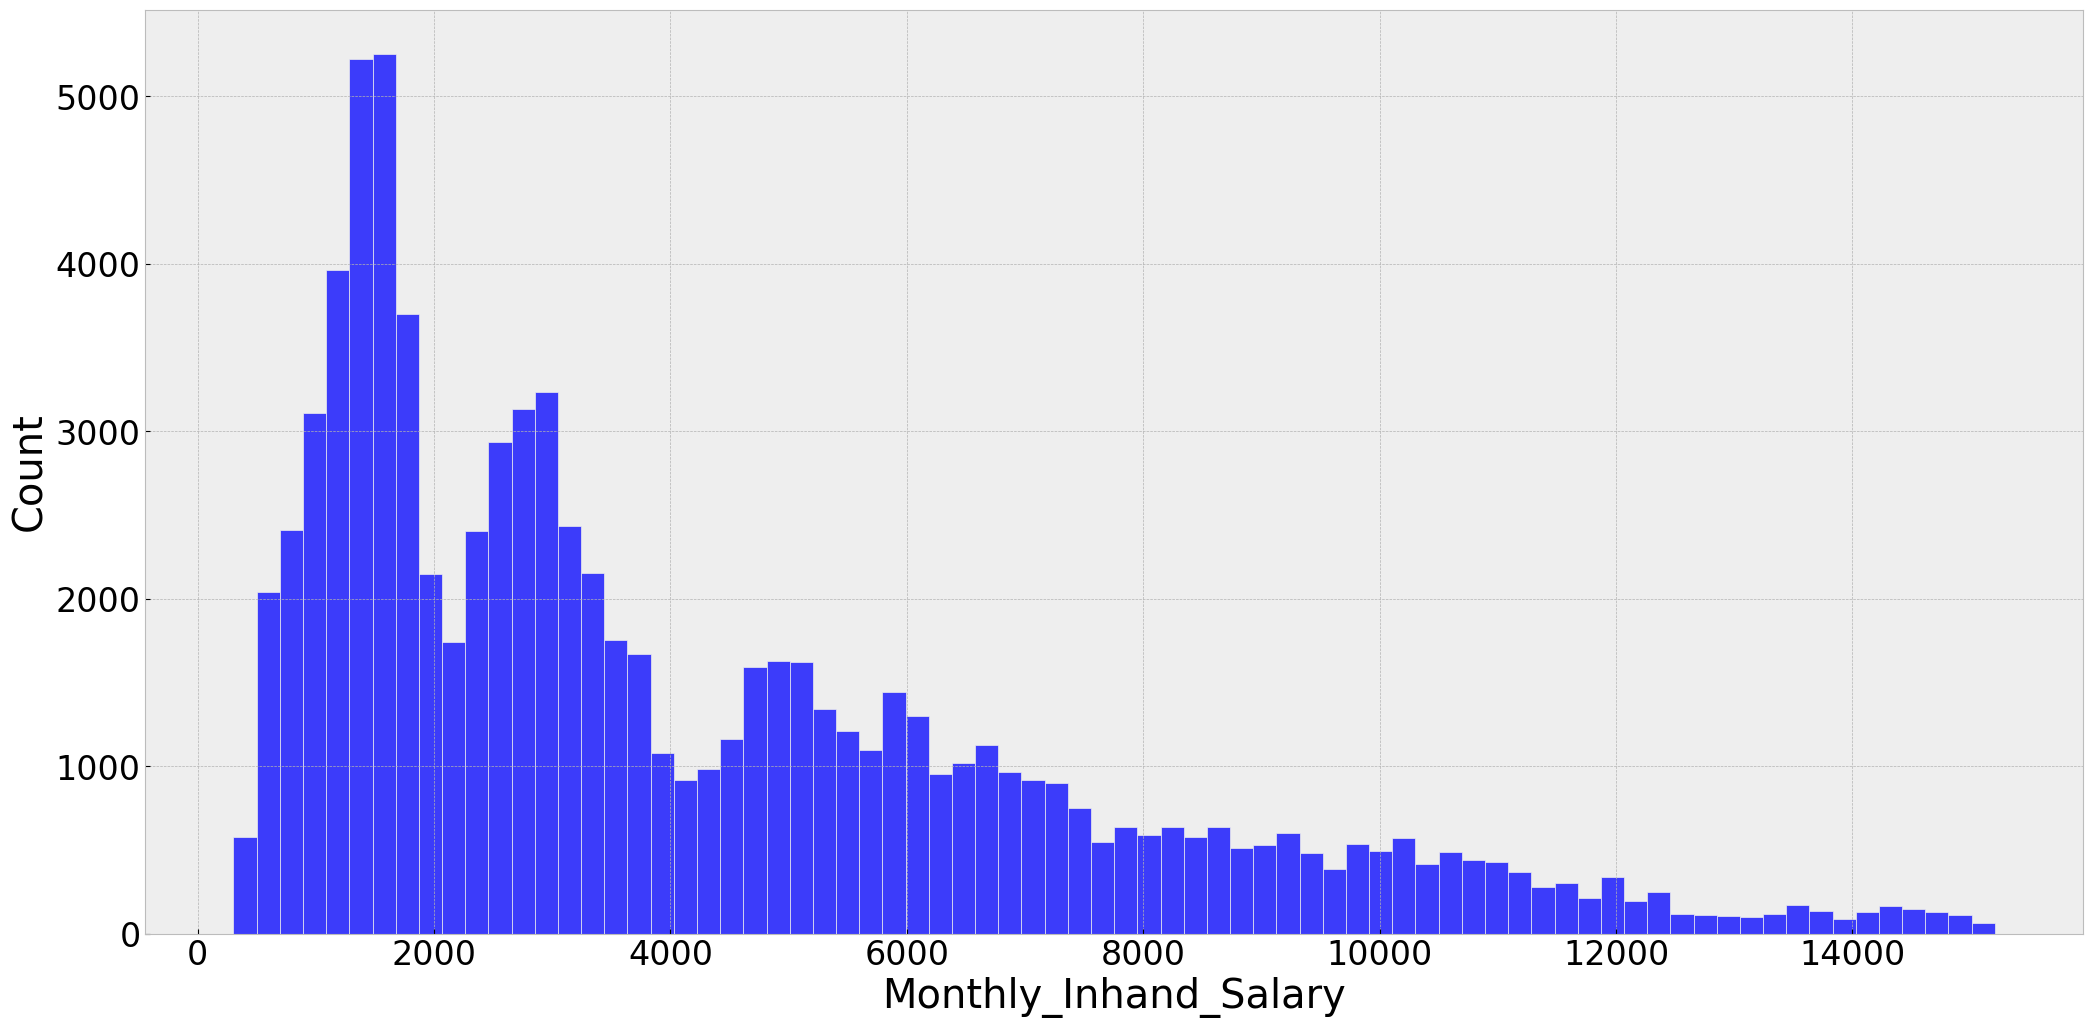

In [34]:
sns.histplot(df1['Monthly_Inhand_Salary'])

In [35]:
#sns.boxplot(df1, x='Occupation',y='Monthly_Inhand_Salary')
#plt.xticks(rotation = 45)

In [36]:
df1['Monthly_Inhand_Salary'].value_counts(dropna=False)

NaN         15002
2295.058       15
6082.188       15
6769.130       15
6358.957       15
            ...  
1087.546        1
3189.212        1
5640.118        1
7727.560        1
2443.654        1
Name: Monthly_Inhand_Salary, Length: 13236, dtype: int64

In [37]:
df1['Monthly_Inhand_Salary'] = df1.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(calcular_moda)

In [38]:
df1['Monthly_Inhand_Salary'].value_counts(dropna=False)

6639.560    16
5766.492    16
2295.058    16
6769.130    16
3080.555    16
            ..
1499.732     8
5620.682     8
3498.527     8
6578.040     8
3359.416     8
Name: Monthly_Inhand_Salary, Length: 12489, dtype: int64

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Count'>

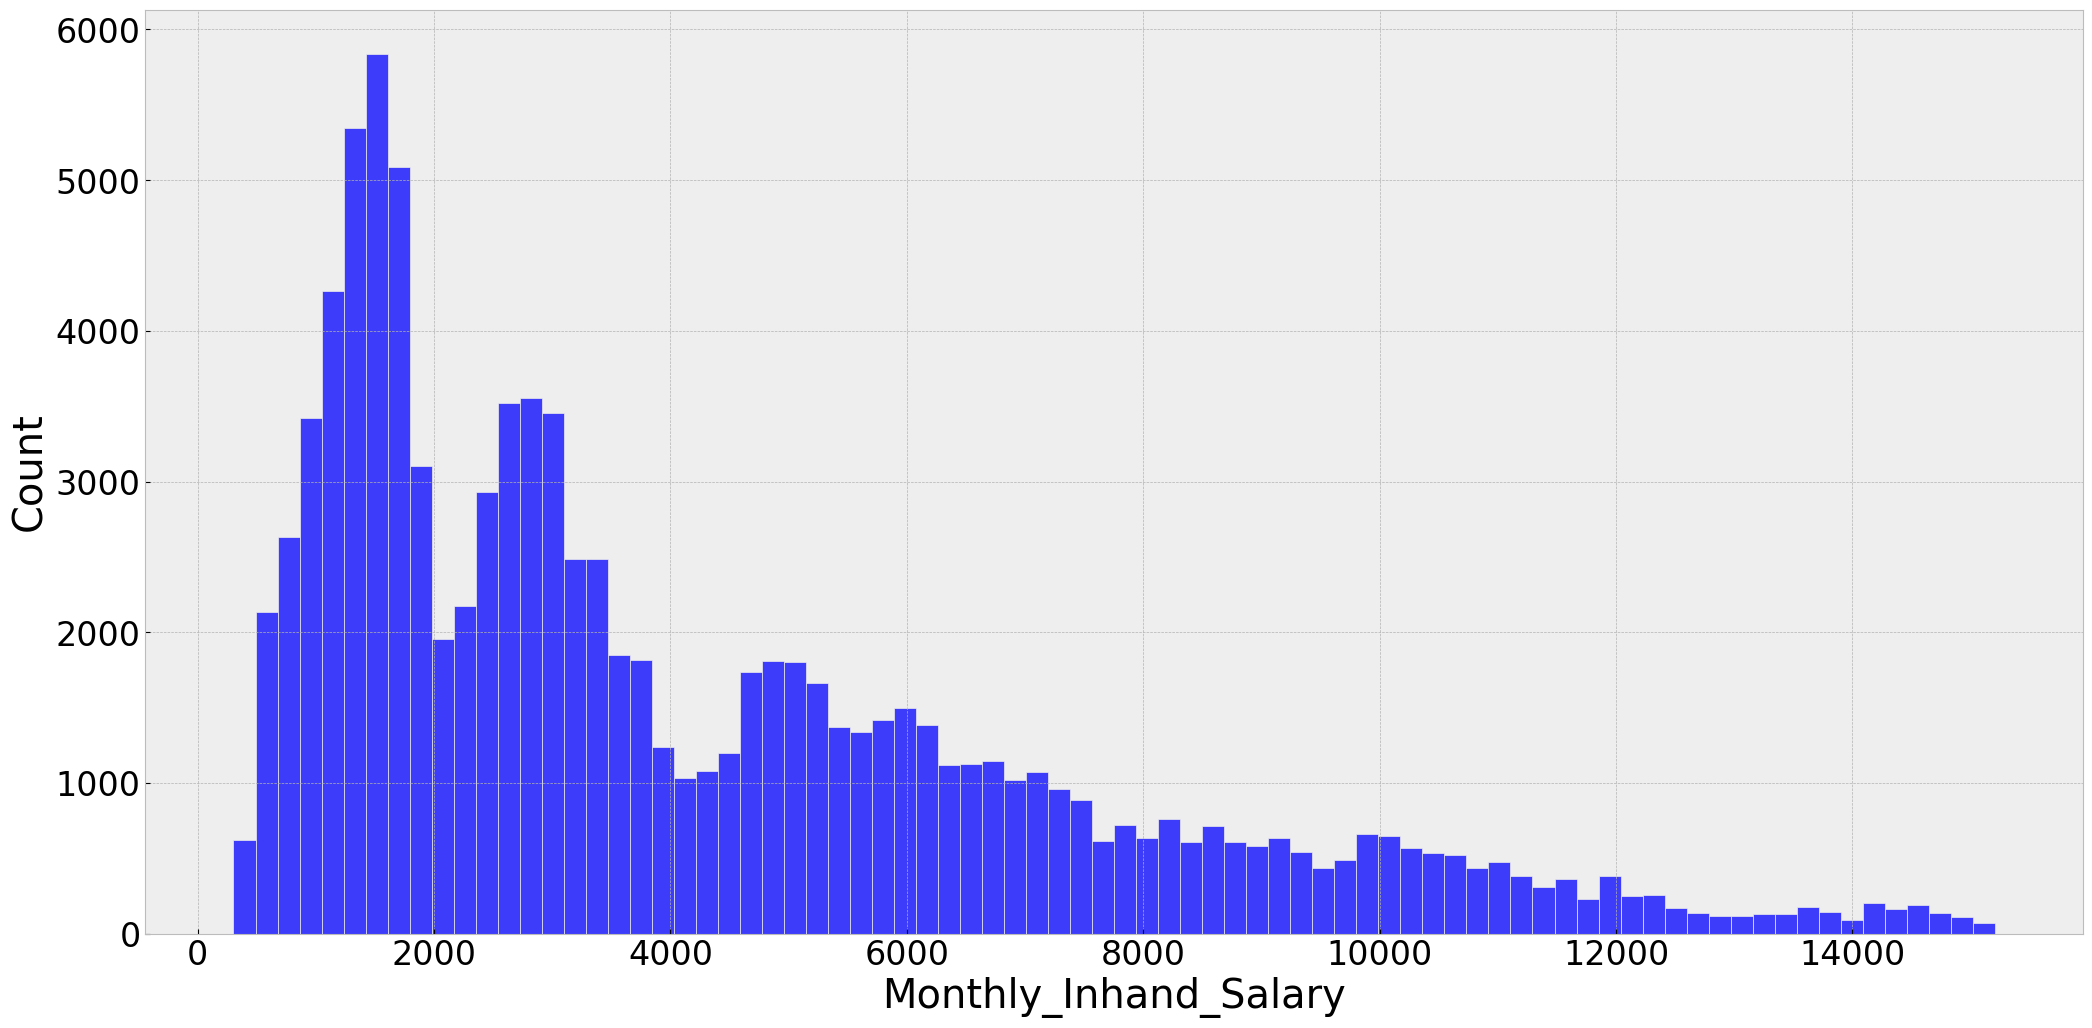

In [39]:
sns.histplot(df1['Monthly_Inhand_Salary'])

In [40]:
#sns.boxplot(df1, x='Occupation',y='Monthly_Inhand_Salary')
#plt.xticks(rotation = 45)

### Tratamento da coluna Num_Bank_Accounts

In [41]:
df1['Num_Bank_Accounts'].value_counts()

6       13001
7       12823
8       12765
4       12186
5       12118
        ...  
1626        1
1470        1
887         1
211         1
697         1
Name: Num_Bank_Accounts, Length: 943, dtype: int64

In [42]:
df1['Num_Bank_Accounts'].describe()

count   100000.000
mean        17.091
std        117.405
min         -1.000
25%          3.000
50%          6.000
75%          7.000
max       1798.000
Name: Num_Bank_Accounts, dtype: float64

In [43]:
df1.groupby('Customer_ID')['Num_Bank_Accounts'].mean().reset_index().sort_values('Num_Bank_Accounts',ascending=False)

Customer_ID  Num_Bank_Accounts
1132   CUS_0x22b9            411.250
65     CUS_0x112e            384.750
11855  CUS_0xc0a3            382.500
1595   CUS_0x29b1            375.250
9754   CUS_0xa1cc            368.750
...           ...                ...
5725   CUS_0x660b              0.000
4849   CUS_0x5993             -0.500
3330   CUS_0x43bc             -0.500
4161   CUS_0x4f2a             -0.750
10204  CUS_0xa878             -0.875

[12500 rows x 2 columns]

In [ ]:
sns.boxplot(df1['Num_Bank_Accounts'])

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Count'>

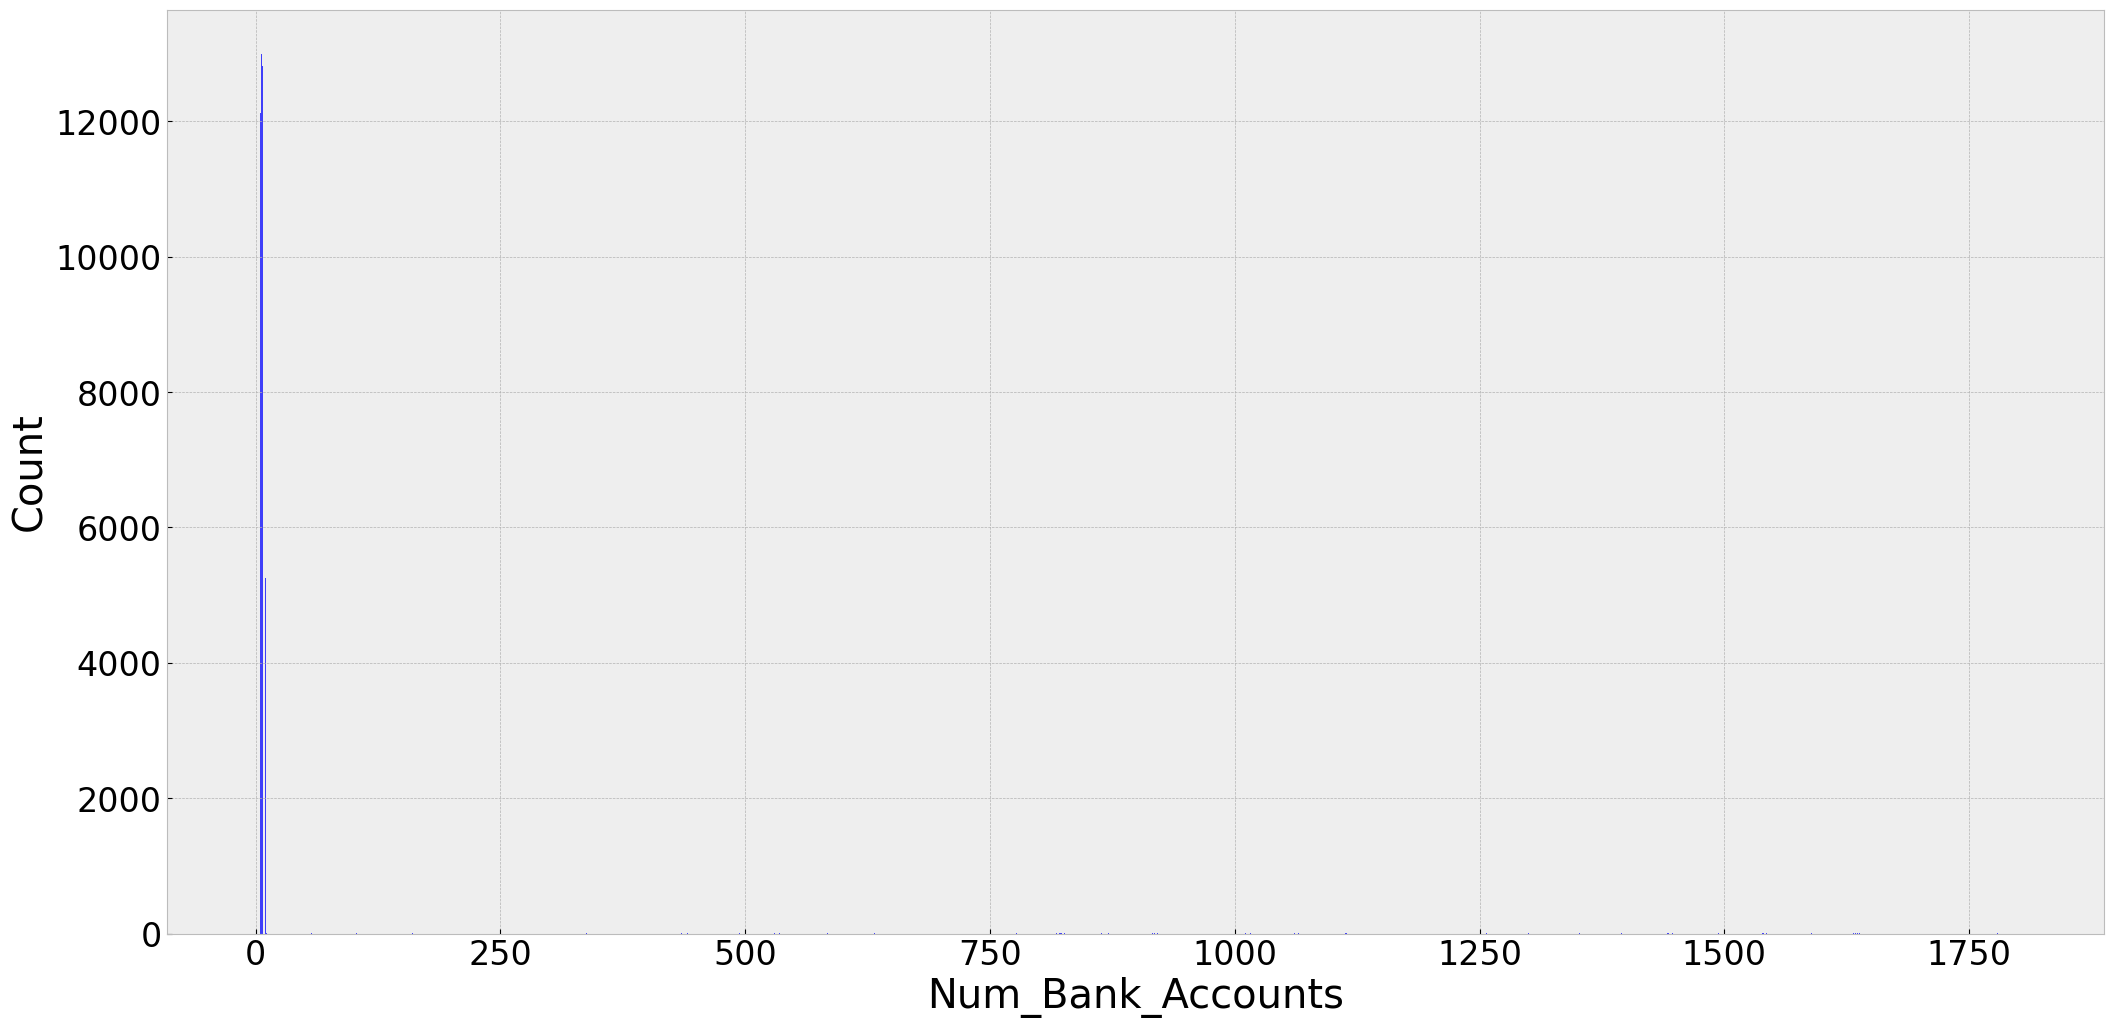

In [45]:
sns.histplot(df1['Num_Bank_Accounts'])

In [46]:
df1.loc[df1['Num_Bank_Accounts']<0,'Num_Bank_Accounts'] = np.nan
df1['Num_Bank_Accounts'] = df1.groupby('Customer_ID')['Num_Bank_Accounts'].transform(calcular_moda)

In [ ]:
sns.boxplot(df1['Num_Bank_Accounts'])

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Count'>

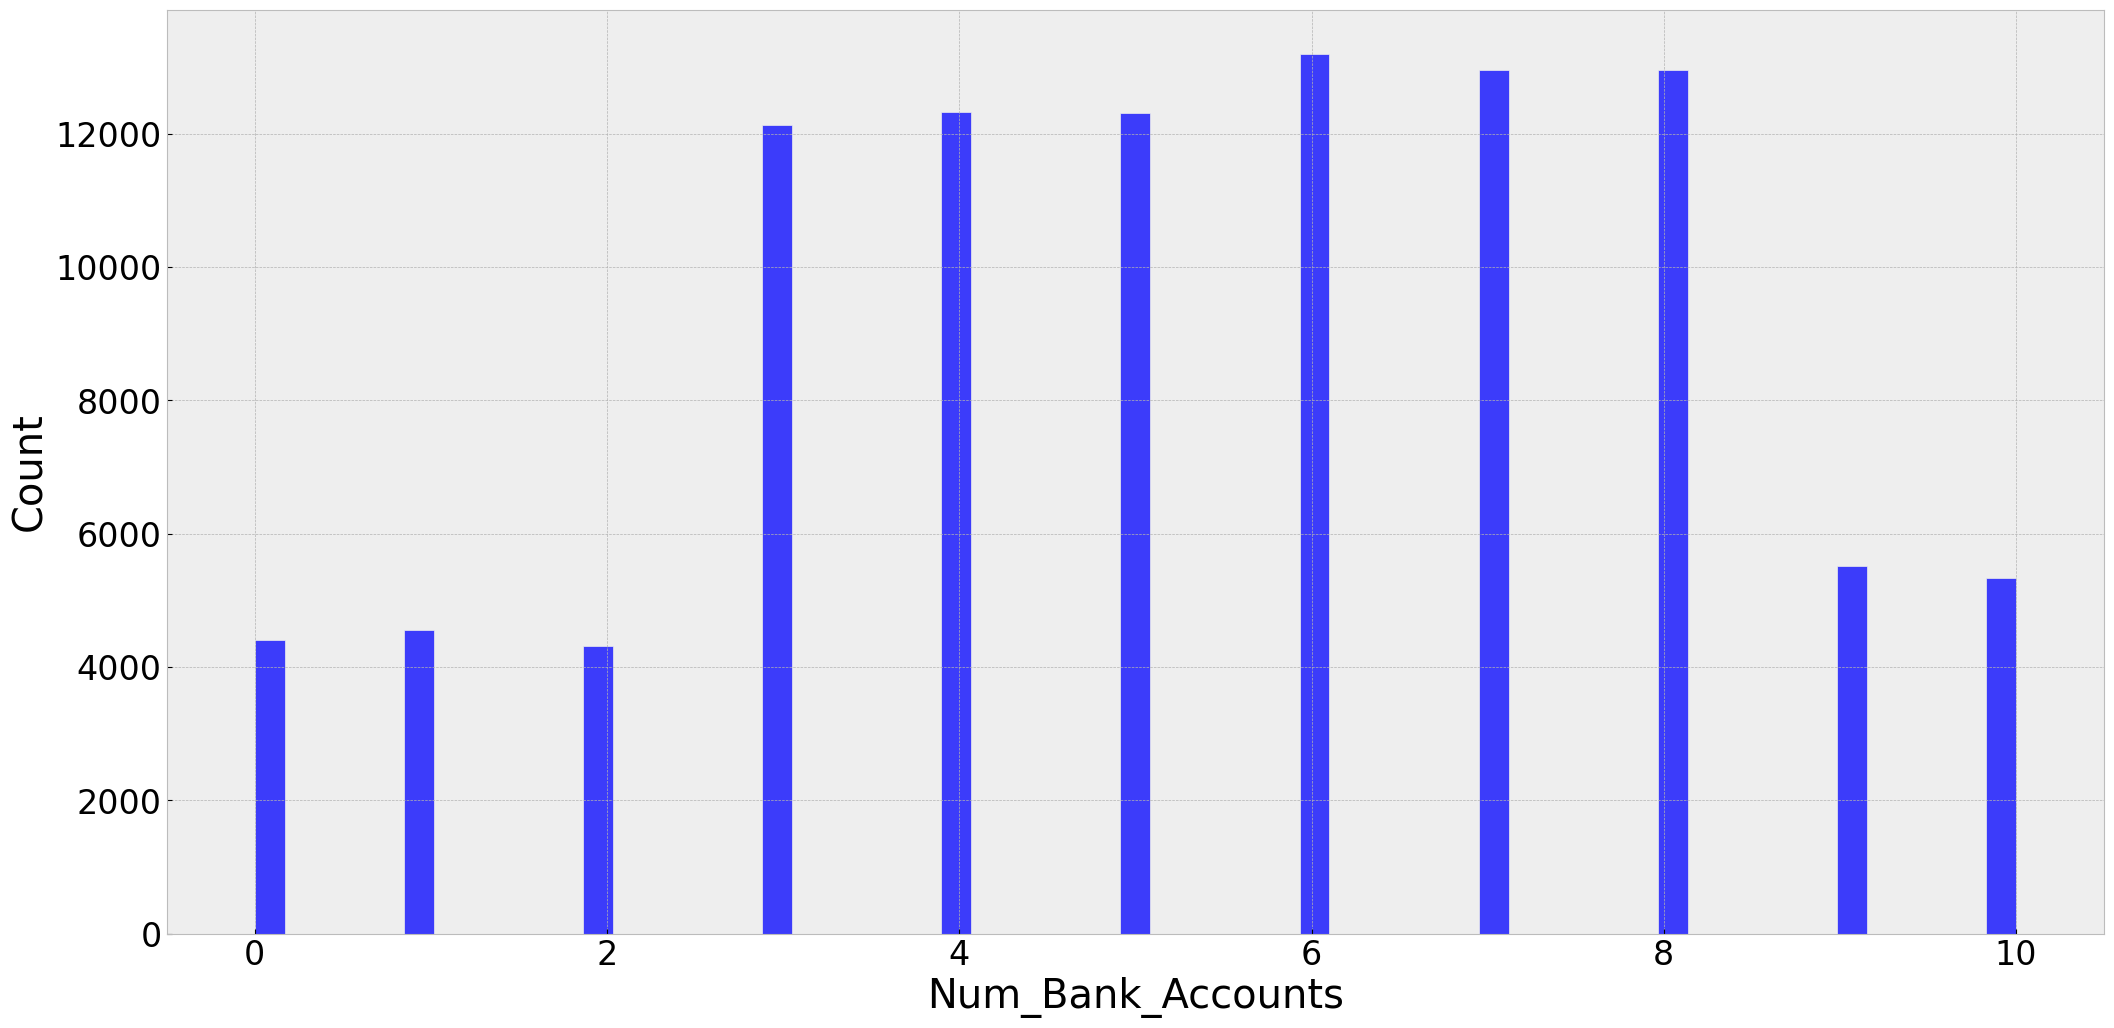

In [48]:
sns.histplot(df1['Num_Bank_Accounts'])

In [49]:
df1['Num_Bank_Accounts'].value_counts()

6.000     13200
7.000     12960
8.000     12960
4.000     12328
5.000     12304
3.000     12136
9.000      5512
10.000     5336
1.000      4552
0.000      4400
2.000      4312
Name: Num_Bank_Accounts, dtype: int64

### Tratando a coluna Num_Credit_Card

In [50]:
df1['Num_Credit_Card'].value_counts(dropna=False)

5       18459
7       16615
6       16559
4       14030
3       13277
        ...  
791         1
1118        1
657         1
640         1
679         1
Name: Num_Credit_Card, Length: 1179, dtype: int64

In [51]:
df1['Num_Credit_Card'].describe()

count   100000.000
mean        22.474
std        129.057
min          0.000
25%          4.000
50%          5.000
75%          7.000
max       1499.000
Name: Num_Credit_Card, dtype: float64

In [52]:
df1['Num_Credit_Card'] = df1.groupby('Customer_ID')['Num_Credit_Card'].transform(calcular_moda)

In [53]:
df1['Num_Credit_Card'].describe()

count   100000.000
mean         5.535
std          2.067
min          1.000
25%          4.000
50%          5.000
75%          7.000
max         11.000
Name: Num_Credit_Card, dtype: float64

### Tratando a coluna Interest_Rate

In [54]:
df1['Interest_Rate'].value_counts(dropna=False)

8       5012
5       4979
6       4721
12      4540
10      4540
        ... 
4995       1
1899       1
2120       1
5762       1
5729       1
Name: Interest_Rate, Length: 1750, dtype: int64

In [55]:
df1['Interest_Rate'].describe()

count   100000.000
mean        72.466
std        466.423
min          1.000
25%          8.000
50%         13.000
75%         20.000
max       5797.000
Name: Interest_Rate, dtype: float64

<AxesSubplot:xlabel='Interest_Rate', ylabel='Count'>

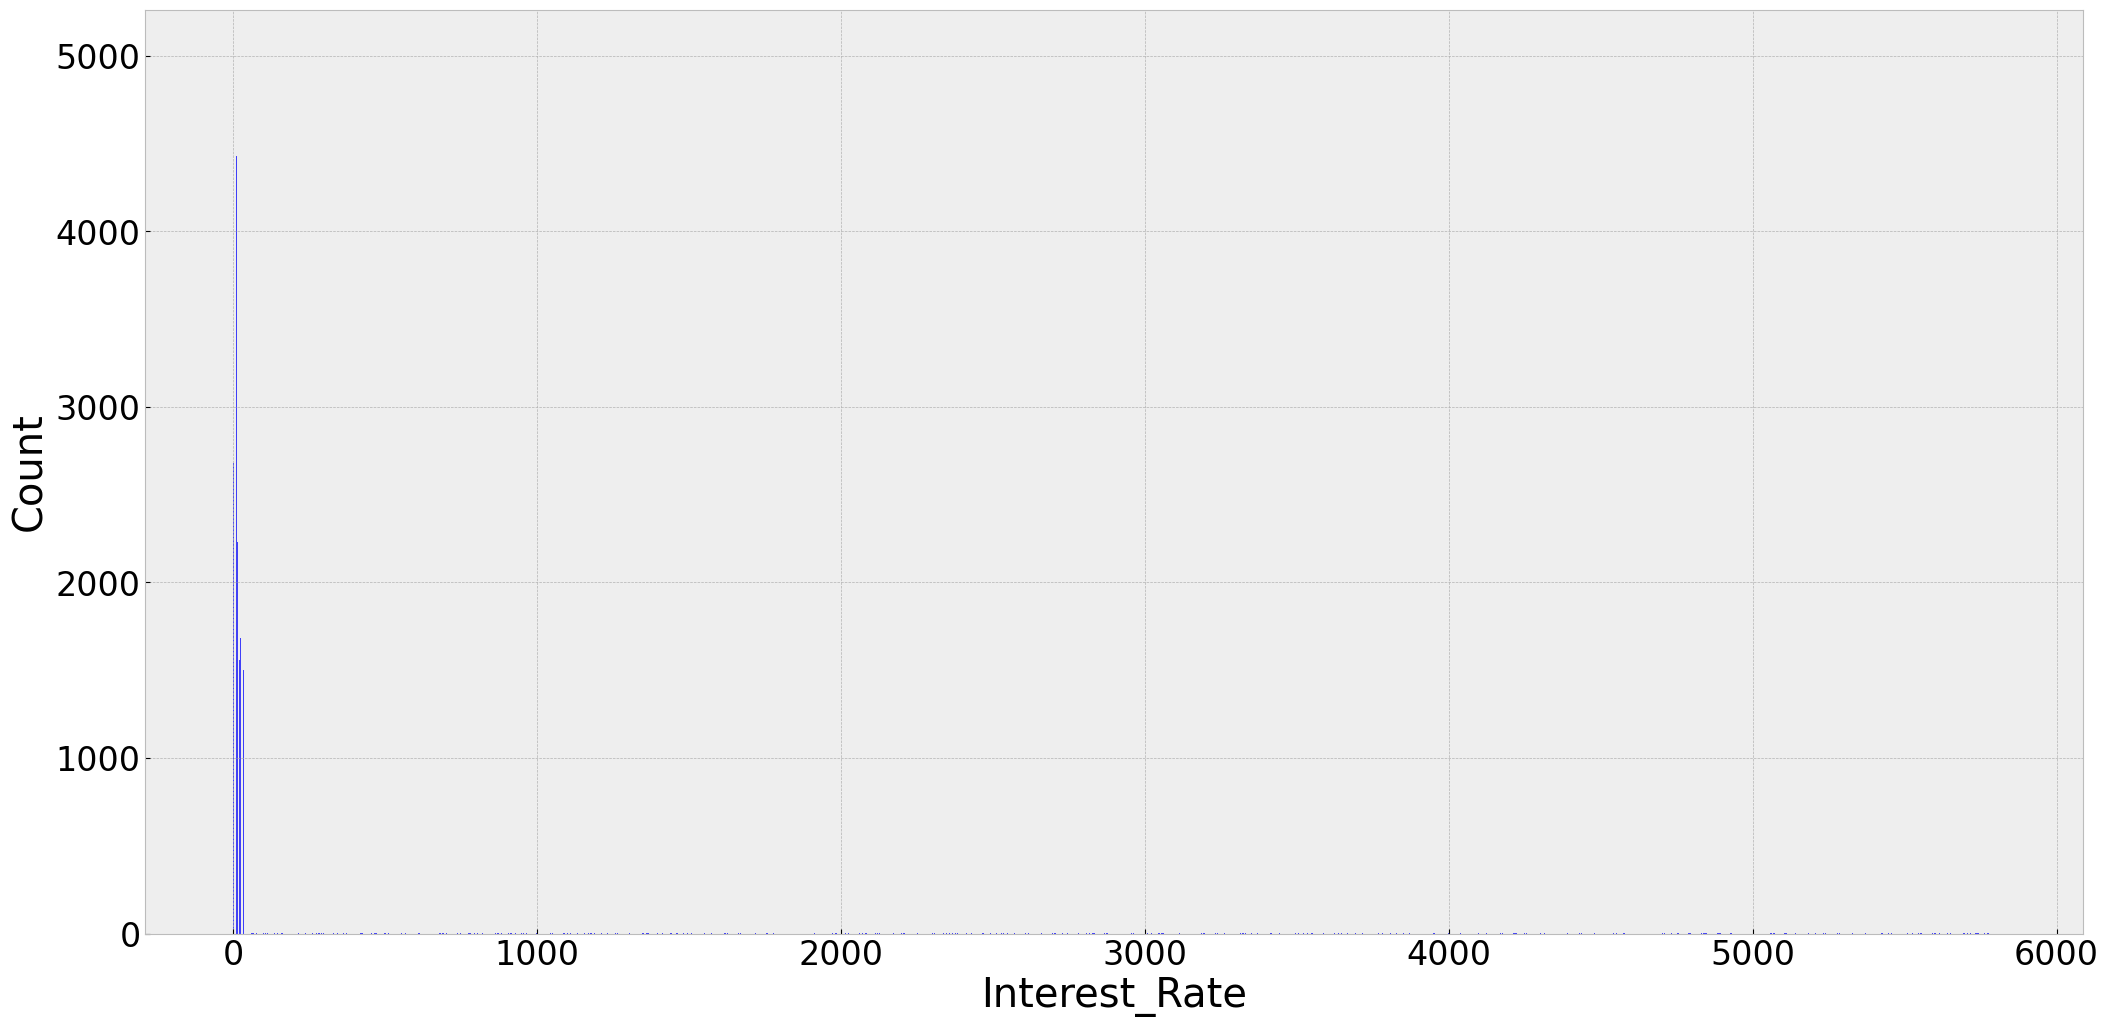

In [56]:
sns.histplot(df1['Interest_Rate'])

In [57]:
df1['Interest_Rate'] = df1.groupby('Customer_ID')['Interest_Rate'].transform(calcular_moda)

<AxesSubplot:xlabel='Interest_Rate', ylabel='Count'>

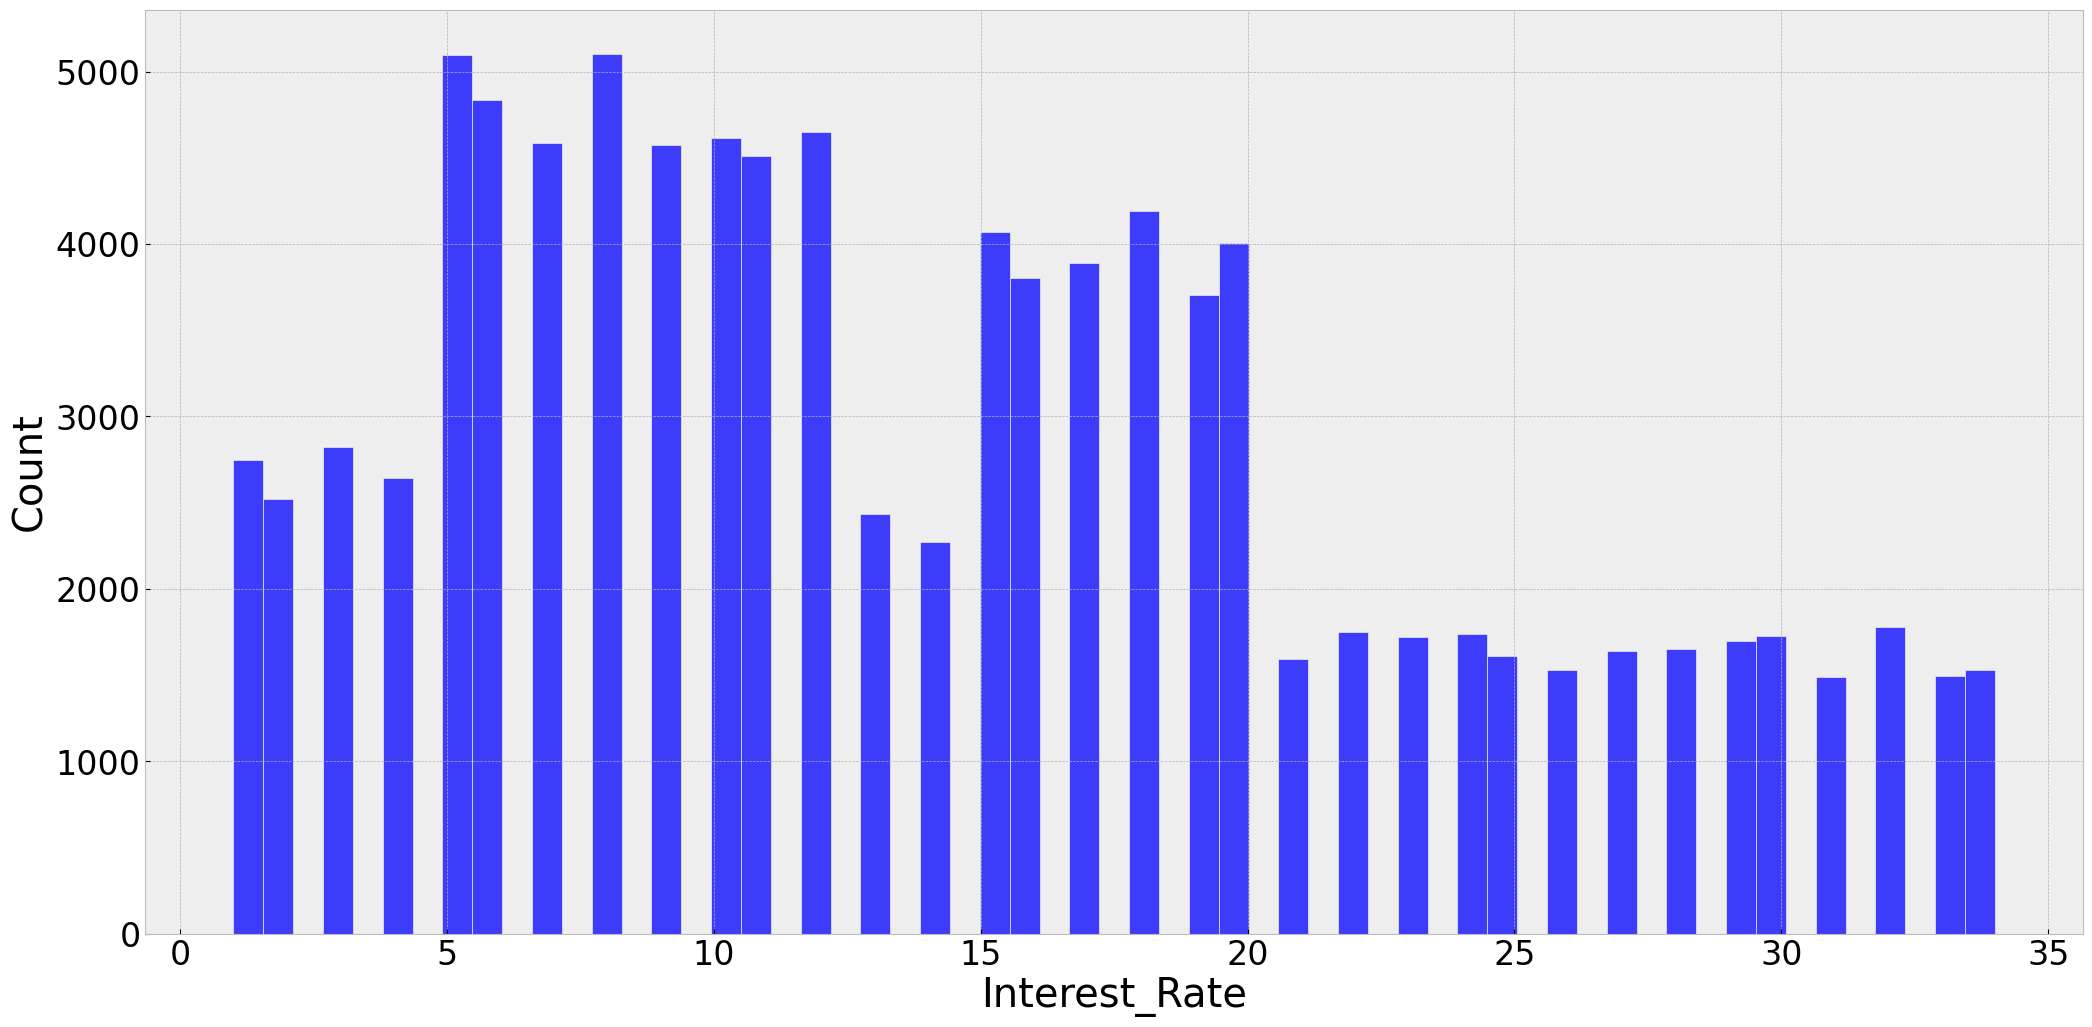

In [58]:
sns.histplot(df1['Interest_Rate'])

In [59]:
df1['Interest_Rate'].describe()

count   100000.000
mean        14.532
std          8.741
min          1.000
25%          7.000
50%         13.000
75%         20.000
max         34.000
Name: Interest_Rate, dtype: float64

In [60]:
df1[df1['Interest_Rate']==34]

Customer_ID     Month  Age Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio     Credit_History_Age Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly                 Payment_Behaviour  Monthly_Balance Credit_Score  loan_type_PaydayLoan  loan_type_AutoLoan  loan_type_DebtConsolidationLoan  loan_type_NotSpecified  loan_type_PersonalLoan  loan_type_MortgageLoan  loan_type_HomeEquityLoan  loan_type_StudentLoan  loan_type_Credit-BuilderLoan
936    CUS_0x5e17   January   32  Scientist      19795.520               1662.627              7.000               10             34            8                   15                  21.000                22.790                10.000        Bad          3135.020                    37.821   2 Years and 3 Months                   Yes              130.475                   77.066    Low_spent_Small_value_payments          248.721     Standard                     1                   0                                0                       1                       1                       1                         1                      1                             0
937    CUS_0x5e17  February   32  Scientist      19795.520               1662.627              7.000               10             34            8                   15                  22.000                22.790                15.000        Bad          3135.020                    26.826   2 Years and 4 Months                   Yes              130.475                  174.710    Low_spent_Small_value_payments          151.077         Poor                     1                   0                                0                       1                       1                       1                         1                      1                             0
938    CUS_0x5e17     March   32  Scientist      19795.520               1662.627              7.000               10             34            8                   15                  21.000                22.790                15.000        Bad          3135.020                    27.575   2 Years and 5 Months                   Yes              130.475                   61.279  High_spent_Medium_value_payments          224.509         Poor                     1                   0                                0                       1                       1                       1                         1                      1                             0
939    CUS_0x5e17     April   32  Scientist      19795.520               1662.627              7.000               10             34            8                   15                  18.000                28.790                15.000        Bad          3135.020                    36.647   2 Years and 6 Months                   Yes              130.475                   76.758    Low_spent_Large_value_payments          229.029         Poor                     1                   0                                0                       1                       1                       1                         1                      1                             0
940    CUS_0x5e17       May   32  Scientist      19795.520               1662.627              7.000               10             34            8                   15                  21.000                22.790                15.000        Bad          3135.020                    34.366   2 Years and 7 Months                   Yes              130.475                  143.610    Low_spent_Large_value_payments          162.177         Poor                     1                   0                                0                       1                       1                       1                         1                      1           

### Tratamento coluna Num_of_Loan

In [61]:
df1['Num_of_Loan'].value_counts(dropna=False)

3       15104
2       15032
4       14743
0       10930
1       10606
        ...  
321         1
1439        1
663         1
613         1
966         1
Name: Num_of_Loan, Length: 413, dtype: int64

In [62]:
df1['Num_of_Loan'] = df1.groupby('Customer_ID')['Num_of_Loan'].transform(calcular_moda)

In [63]:
df1['Num_of_Loan'].value_counts(dropna=False)

3    15752
2    15712
4    15456
0    11408
1    11128
6     8144
7     7680
5     7528
9     3856
8     3336
Name: Num_of_Loan, dtype: int64

### Transformando a coluna Delay_from_due_date
###### Não fizemos nada pelo fato do cliente poder pagar as dividas adiantado

In [64]:
df1['Delay_from_due_date'].value_counts(dropna=False).to_frame().head(5).reset_index().sort_values('index',ascending=False)

index  Delay_from_due_date
0     15                 3596
3     14                 3313
1     13                 3424
4     10                 3281
2      8                 3324

<AxesSubplot:xlabel='Delay_from_due_date', ylabel='Count'>

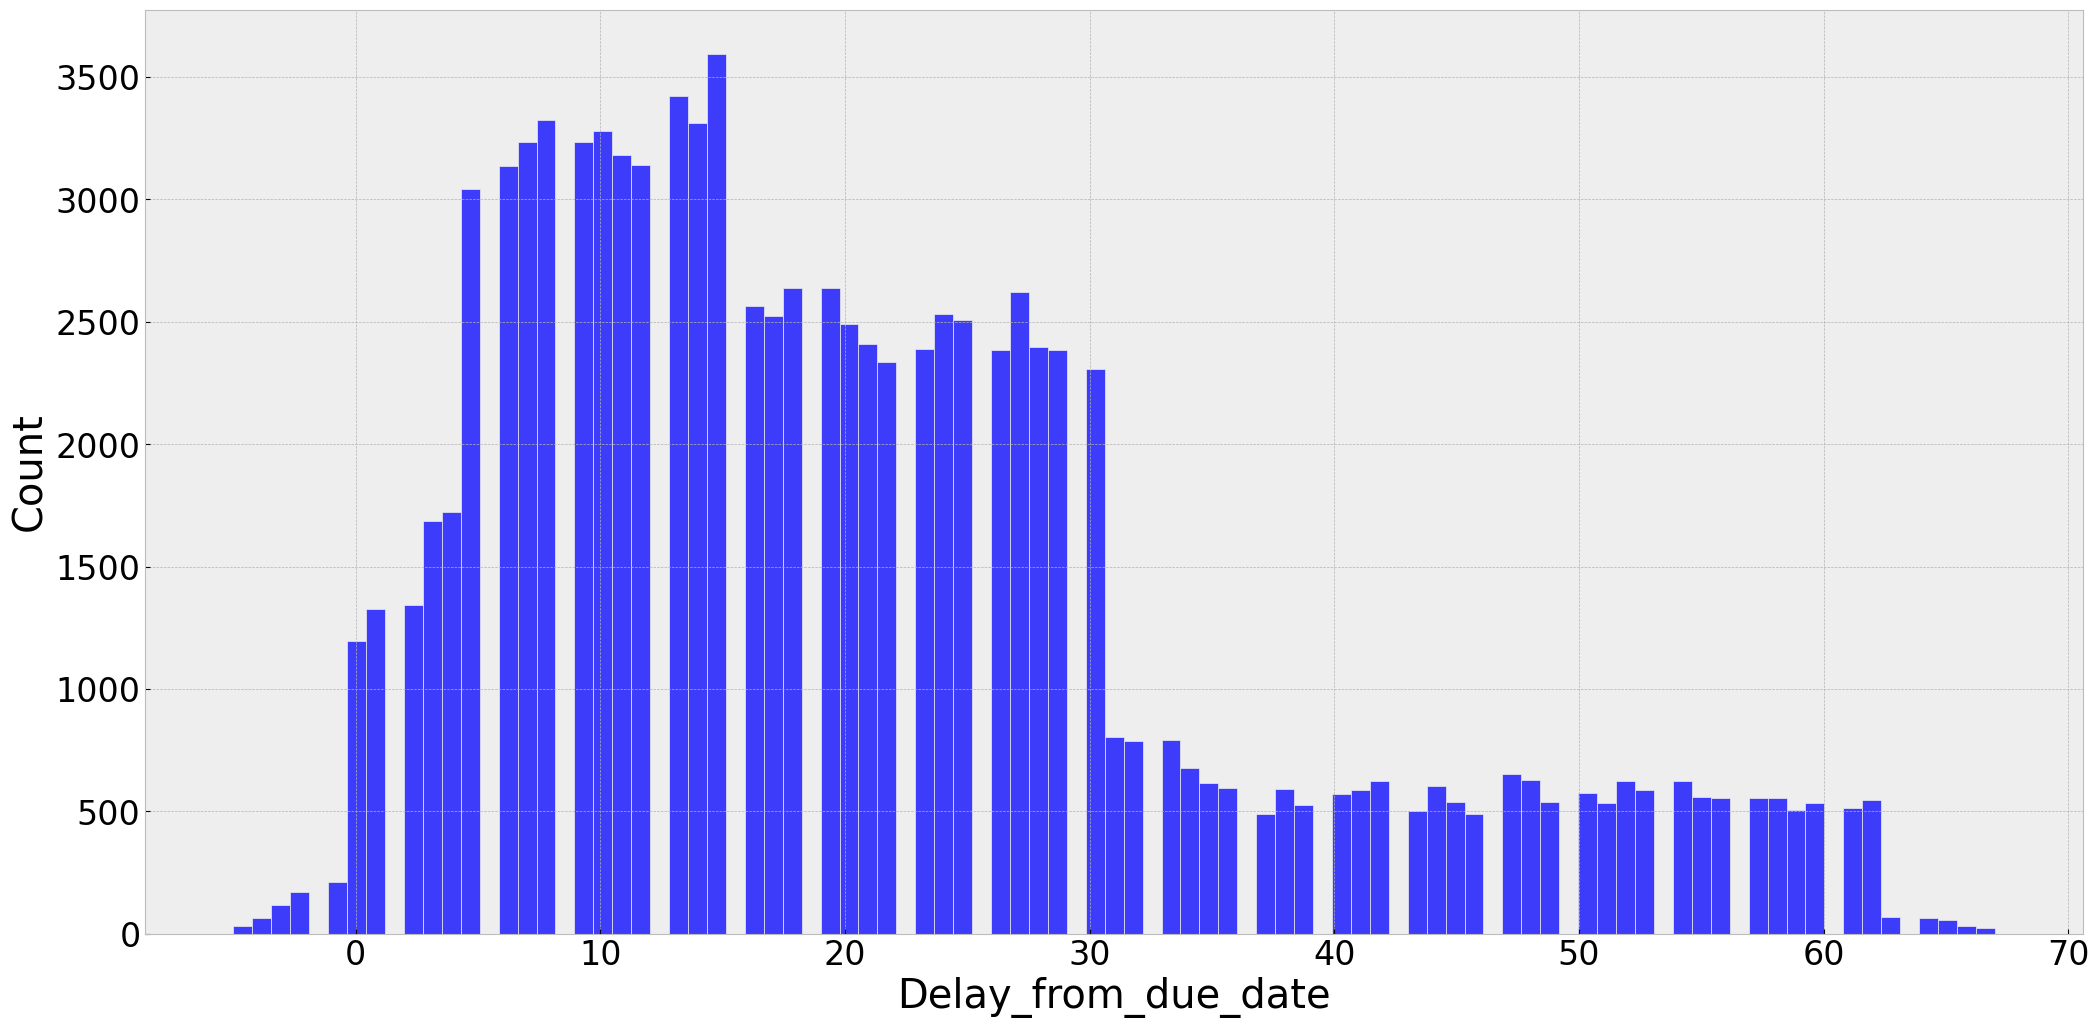

In [65]:
sns.histplot(df1['Delay_from_due_date'])

In [66]:
#Verificando quant. nulos
df1['Delay_from_due_date'].isna().sum()

0

### Tratando a coluna Num_of_Delayed_Payment

In [67]:
df1['Num_of_Delayed_Payment'].value_counts(dropna=False).to_frame().head(10).reset_index().sort_values('index',ascending=False)

index  Num_of_Delayed_Payment
7 20.000                    5089
1 19.000                    5481
6 18.000                    5216
2 17.000                    5412
3 16.000                    5312
5 15.000                    5237
8 12.000                    5059
4 10.000                    5309
9  9.000                    4981
0    NaN                    7002

In [68]:
## Número máximo de atraso médio=28, então vamos substituir os valores acima disso por nan e modificar pela média do cliente.
df1.loc[df1['Num_of_Delayed_Payment'] > 28, 'Num_of_Delayed_Payment'] = np.nan
df1.loc[df1['Num_of_Delayed_Payment'].isna(),'Num_of_Delayed_Payment'] = df1.groupby('Customer_ID')["Num_of_Delayed_Payment"].transform(mean)

In [69]:
df1.groupby('Customer_ID')["Num_of_Delayed_Payment"].mean()

Customer_ID
CUS_0x1000   25.000
CUS_0x1009   17.857
CUS_0x100b    7.375
CUS_0x1011   14.500
CUS_0x1013    8.429
              ...  
CUS_0xff3     8.625
CUS_0xff4    12.125
CUS_0xff6     4.000
CUS_0xffc    16.250
CUS_0xffd    11.429
Name: Num_of_Delayed_Payment, Length: 12500, dtype: float64

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Count'>

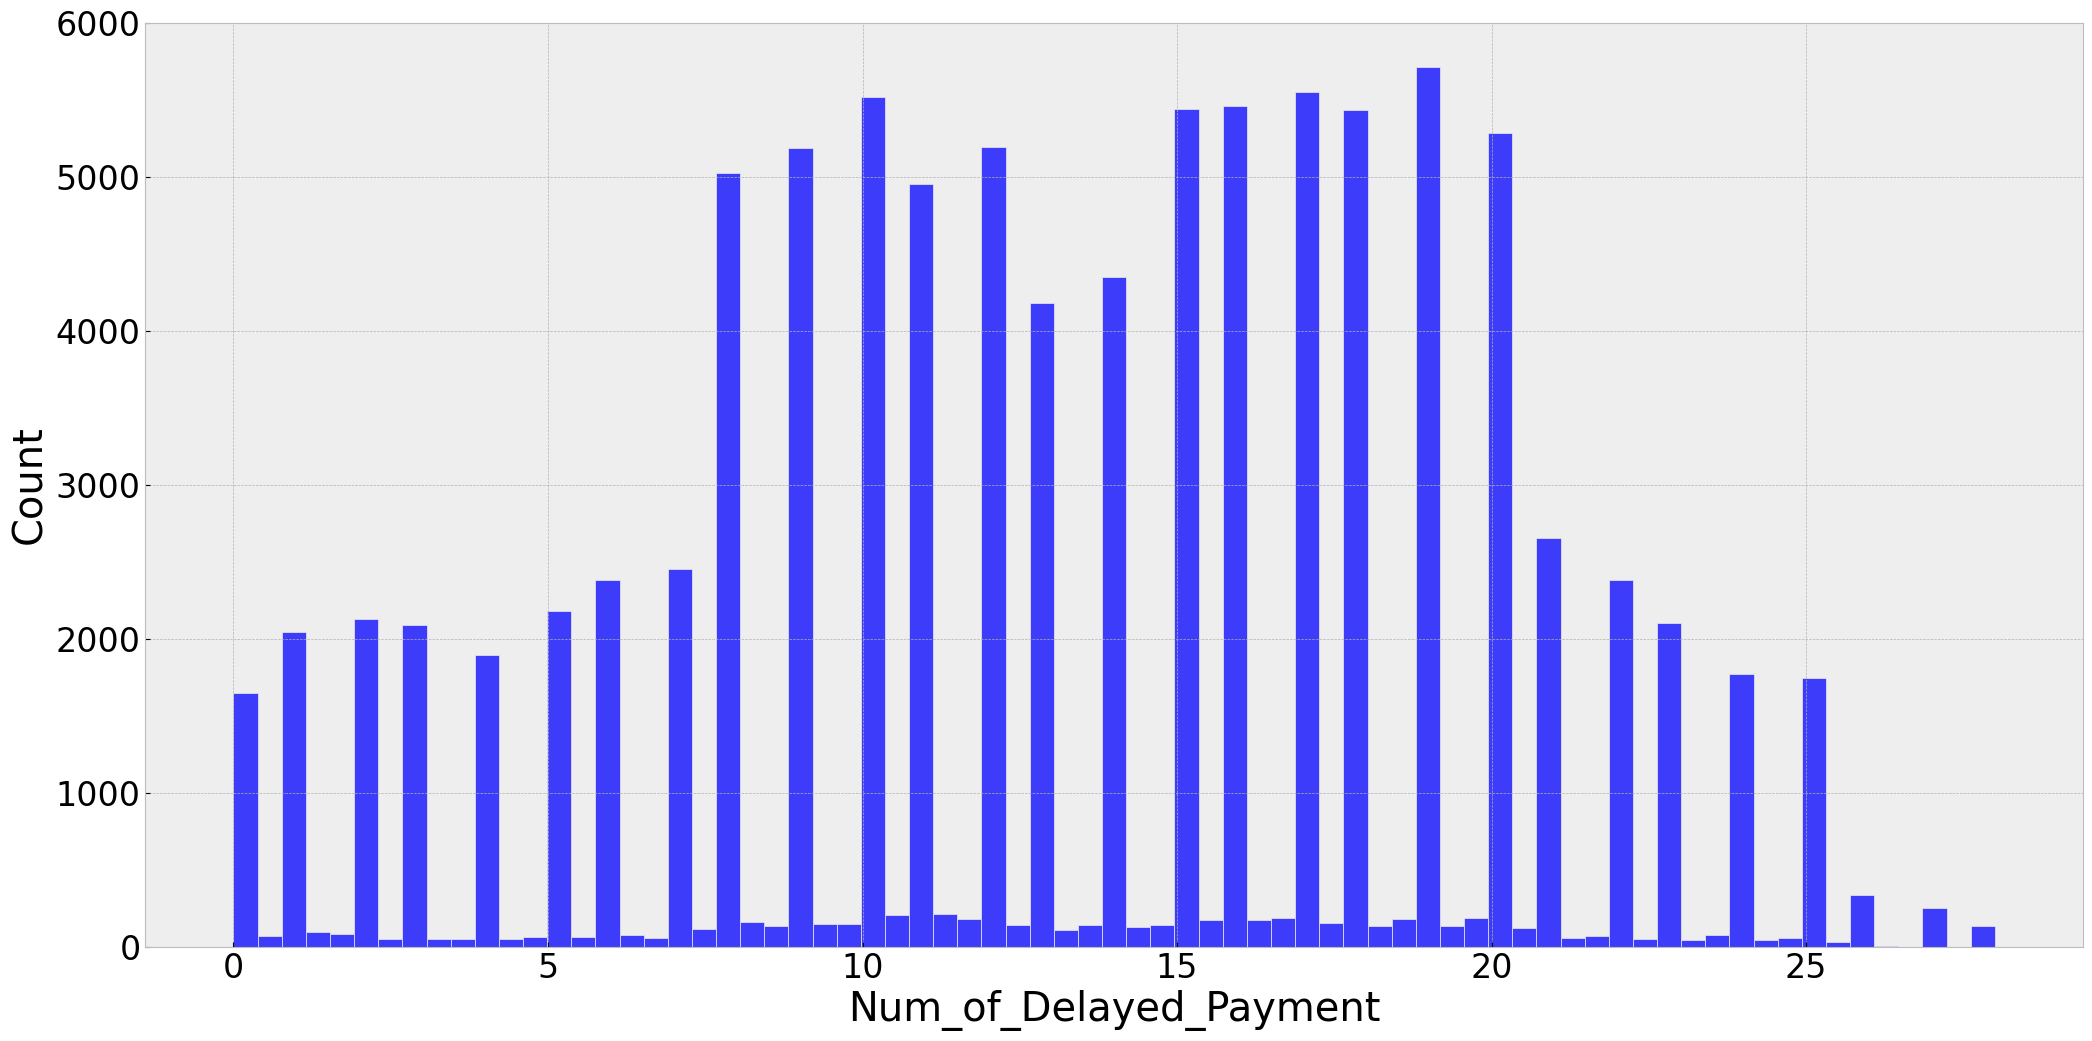

In [70]:
sns.histplot(df1['Num_of_Delayed_Payment'])

In [71]:
#sns.boxplot(df1, x= 'Credit_Mix', y='Num_of_Delayed_Payment')

### Tratando a coluna Changed_Credit_Limit

In [72]:
df1['Changed_Credit_Limit'].value_counts(dropna=False).to_frame().head(10).reset_index().sort_values('index',ascending=False)

index  Changed_Credit_Limit
2 11.500                   127
7 11.490                   113
3 11.320                   126
4 10.060                   121
6  8.230                   115
1  8.220                   133
5  7.350                   121
9  7.330                   110
8  3.930                   111
0    NaN                  2091

<AxesSubplot:xlabel='Changed_Credit_Limit', ylabel='Count'>

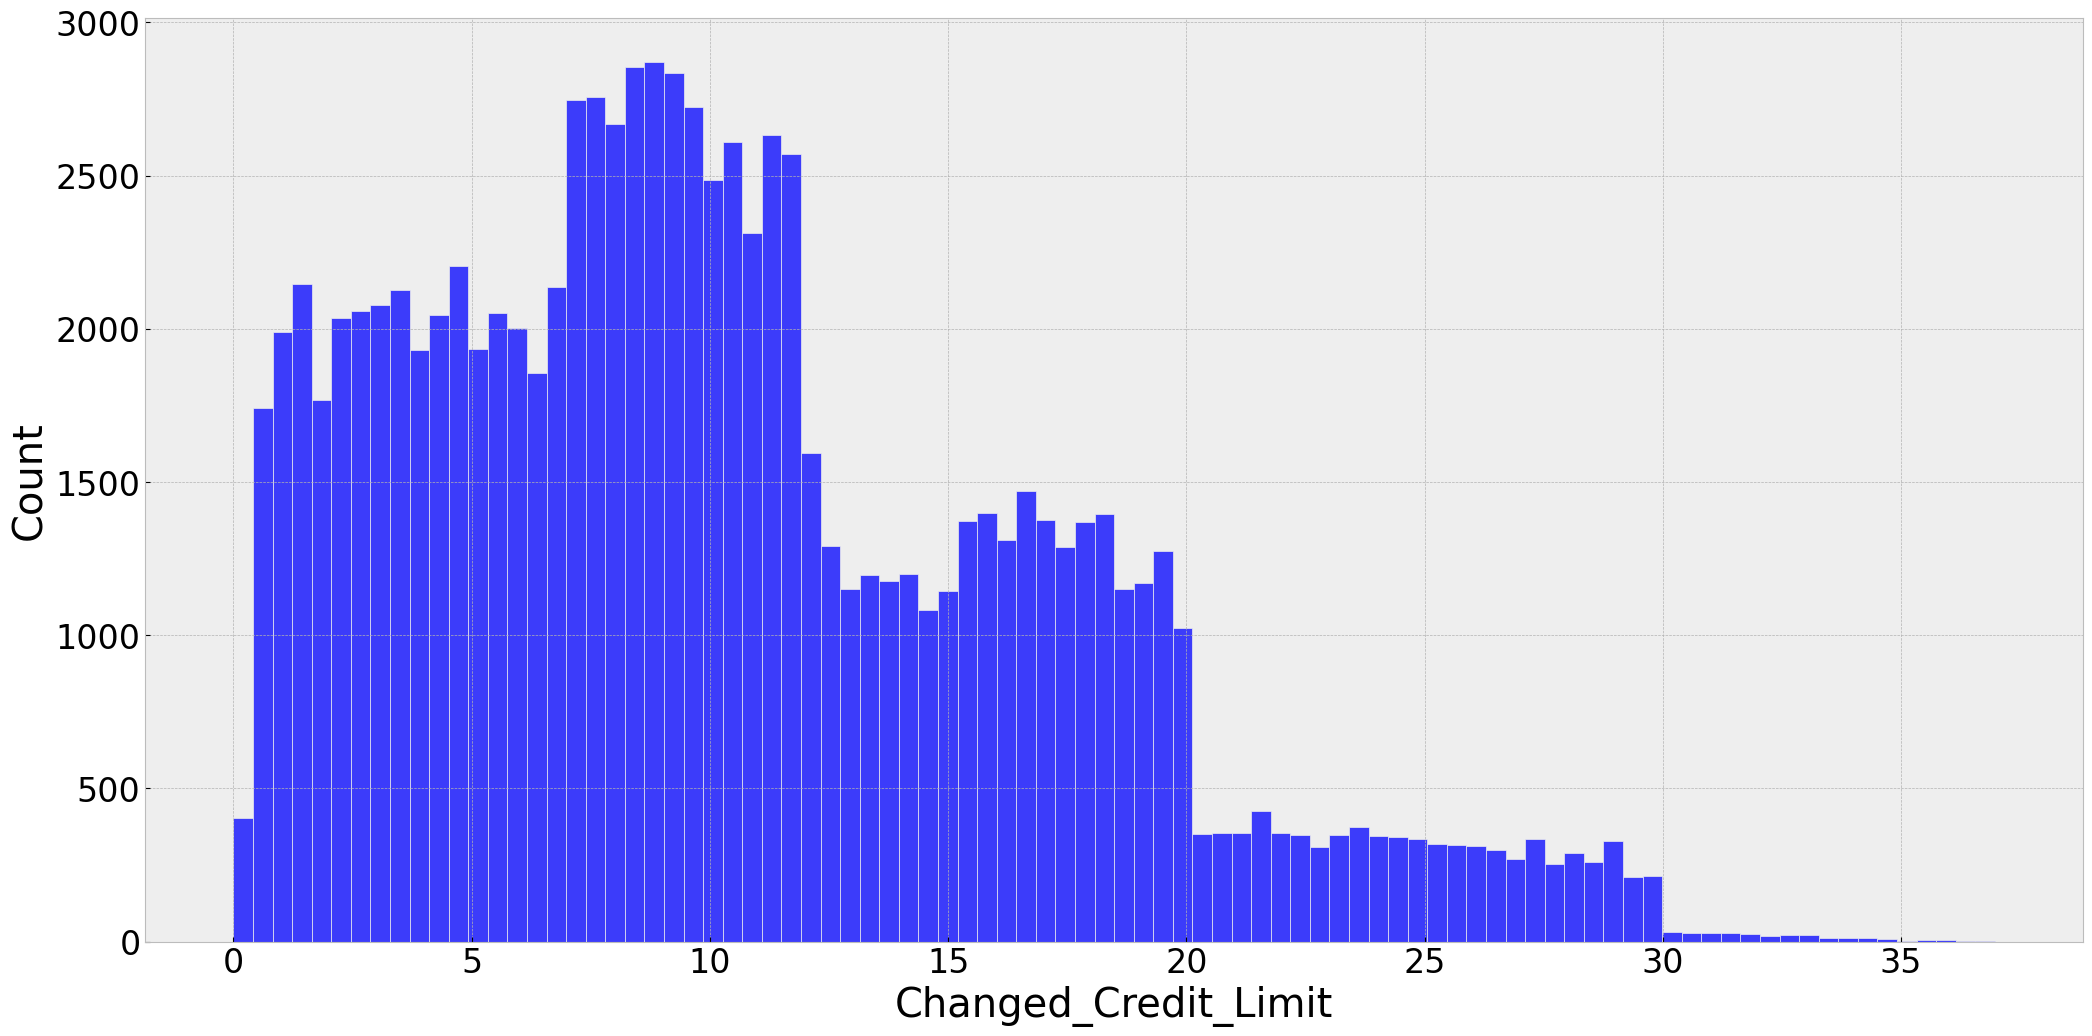

In [73]:
sns.histplot(df1['Changed_Credit_Limit'])

In [74]:
df1.loc[df1['Changed_Credit_Limit'].isna(),'Changed_Credit_Limit'] = df1.groupby('Customer_ID')["Changed_Credit_Limit"].transform(mean)

### Tratando a coluna Num_Credit_Inquiries

In [75]:
df1['Num_Credit_Inquiries'].value_counts(dropna=False).to_frame().head(20).reset_index().sort_values('index',ascending=True)

index  Num_Credit_Inquiries
7     0.000                  6972
6     1.000                  7588
4     2.000                  8028
1     3.000                  8890
0     4.000                 11271
8     5.000                  5693
2     6.000                  8111
3     7.000                  8058
5     8.000                  7866
9     9.000                  5283
11   10.000                  4936
10   11.000                  5051
12   12.000                  4571
14   13.000                  1480
15   14.000                  1039
16   15.000                   808
17   16.000                   456
18   17.000                   284
19 1786.000                     4
13      NaN                  1965

In [76]:
df1.loc[df1['Num_Credit_Inquiries'] >20]

Customer_ID     Month  Age     Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio      Credit_History_Age Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly                 Payment_Behaviour  Monthly_Balance Credit_Score  loan_type_PaydayLoan  loan_type_AutoLoan  loan_type_DebtConsolidationLoan  loan_type_NotSpecified  loan_type_PersonalLoan  loan_type_MortgageLoan  loan_type_HomeEquityLoan  loan_type_StudentLoan  loan_type_Credit-BuilderLoan
173    CUS_0xa16e      June   41  Media_Manager      10183.015               1074.585              7.000                5             17            5                   48                  24.000                10.970              1050.000        Bad          1672.430                    25.105   10 Years and 6 Months                   Yes               37.588                   73.900    Low_spent_Small_value_payments          285.971         Poor                     0                   0                                0                       0                       0                       1                         0                      1                             1
193    CUS_0xa5f9  February   34       Mechanic      57983.120               4720.927              9.000                8             31            8                   53                  21.000                 7.270              1044.000        Bad          3532.830                    37.874   12 Years and 3 Months                   Yes              200.433                  193.873  High_spent_Medium_value_payments          327.787     Standard                     1                   0                                1                       1                       0                       0                         0                      1                             1
198    CUS_0xa5f9      July   34       Mechanic      57983.120               4720.927              9.000                8             31            8                   49                  21.000                 7.270              1936.000        Bad          3532.830                    24.631   12 Years and 8 Months                   Yes              200.433                  234.732   Low_spent_Medium_value_payments          316.928     Standard                     1                   0                                1                       1                       0                       0                         0                      1                             1
234    CUS_0xb681     March   37        Manager      39641.540               3007.462             10.000                8             25            6                   61                  15.000                 1.540               568.000        Bad          2258.730                    27.573   8 Years and 10 Months                   Yes              172.383                  198.042   High_spent_Small_value_payments          190.322         Poor                     1                   1                                1                       0                       0                       1                         0                      1                             0
312    CUS_0x571f   January   18      Developer      66567.320               5800.277              5.000                7              5            2                    7                  15.000                 7.670              1618.000   Standard           233.790                    34.456   24 Years and 3 Months                    No            37602.000                  251.647    Low_spent_Small_value_payments          518.191     Standard                     0                   0                                0                       1                       0                       1                         0    

In [77]:
df1.loc[df1['Customer_ID'] =='CUS_0x5cc0']

Customer_ID     Month  Age Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio     Credit_History_Age Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly                 Payment_Behaviour  Monthly_Balance Credit_Score  loan_type_PaydayLoan  loan_type_AutoLoan  loan_type_DebtConsolidationLoan  loan_type_NotSpecified  loan_type_PersonalLoan  loan_type_MortgageLoan  loan_type_HomeEquityLoan  loan_type_StudentLoan  loan_type_Credit-BuilderLoan
80584  CUS_0x5cc0   January   17  Architect      34343.960               2897.997             10.000                8             28            3                   53                  17.000                14.090                12.000        Bad          1699.050                    38.520  11 Years and 2 Months                   Yes               66.353                  226.485   Low_spent_Medium_value_payments          276.961         Poor                     1                   1                                1                       0                       0                       0                         0                      0                             0
80585  CUS_0x5cc0  February   17  Architect      34343.960               2897.997             10.000                8             28            3                   53                  17.000                12.090                29.000        Bad          1699.050                    40.769  11 Years and 3 Months                    NM               66.353                  102.827  High_spent_Medium_value_payments          370.619         Poor                     1                   1                                1                       0                       0                       0                         0                      0                             0
80586  CUS_0x5cc0     March   17  Architect      34343.960               2897.997             10.000                8             28            3                   54                  14.000                19.090                12.000        Bad          1699.050                    38.534  11 Years and 4 Months                   Yes               66.353                  177.647    Low_spent_Small_value_payments          335.799         Poor                     1                   1                                1                       0                       0                       0                         0                      0                             0
80587  CUS_0x5cc0     April   17  Architect      34343.960               2897.997             10.000                8             28            3                   53                  17.000                19.090                12.000        Bad          1699.050                    40.635  11 Years and 5 Months                   Yes               66.353                  126.705    Low_spent_Small_value_payments          386.741         Poor                     1                   1                                1                       0                       0                       0                         0                      0                             0
80588  CUS_0x5cc0       May   17  Architect      34343.960               2897.997             10.000                8             28            3                   53                  17.000                14.090                12.000        Bad          1699.050                    33.123  11 Years and 6 Months                   Yes               66.353                      NaN    Low_spent_Large_value_payments          376.882         Poor                     1                   1                                1                       0                       0                       0                         0                      0           

In [78]:
df1.loc[df1['Num_Credit_Inquiries'] > 30, 'Num_Credit_Inquiries'] = np.nan
df1.loc[df1['Num_Credit_Inquiries'].isna(),'Num_Credit_Inquiries'] = df1.groupby('Customer_ID')["Num_Credit_Inquiries"].transform(calcular_moda)

### Trantando a coluna Outstanding_Debt

In [79]:
df1['Outstanding_Debt']

0       809.980
1       809.980
2       809.980
3       809.980
4       809.980
          ...  
99995   502.380
99996   502.380
99997   502.380
99998   502.380
99999   502.380
Name: Outstanding_Debt, Length: 100000, dtype: float64

In [80]:
df1['Outstanding_Debt'].describe()

count   100000.000
mean      1426.220
std       1155.129
min          0.230
25%        566.072
50%       1166.155
75%       1945.963
max       4998.070
Name: Outstanding_Debt, dtype: float64

### Tratando a coluna Credit_Utilization_Ratio

In [81]:
df1['Credit_Utilization_Ratio'].isna().sum()

0

In [82]:
df1['Credit_Utilization_Ratio'].describe()

count   100000.000
mean        32.285
std          5.117
min         20.000
25%         28.053
50%         32.306
75%         36.497
max         50.000
Name: Credit_Utilization_Ratio, dtype: float64

<AxesSubplot:ylabel='Frequency'>

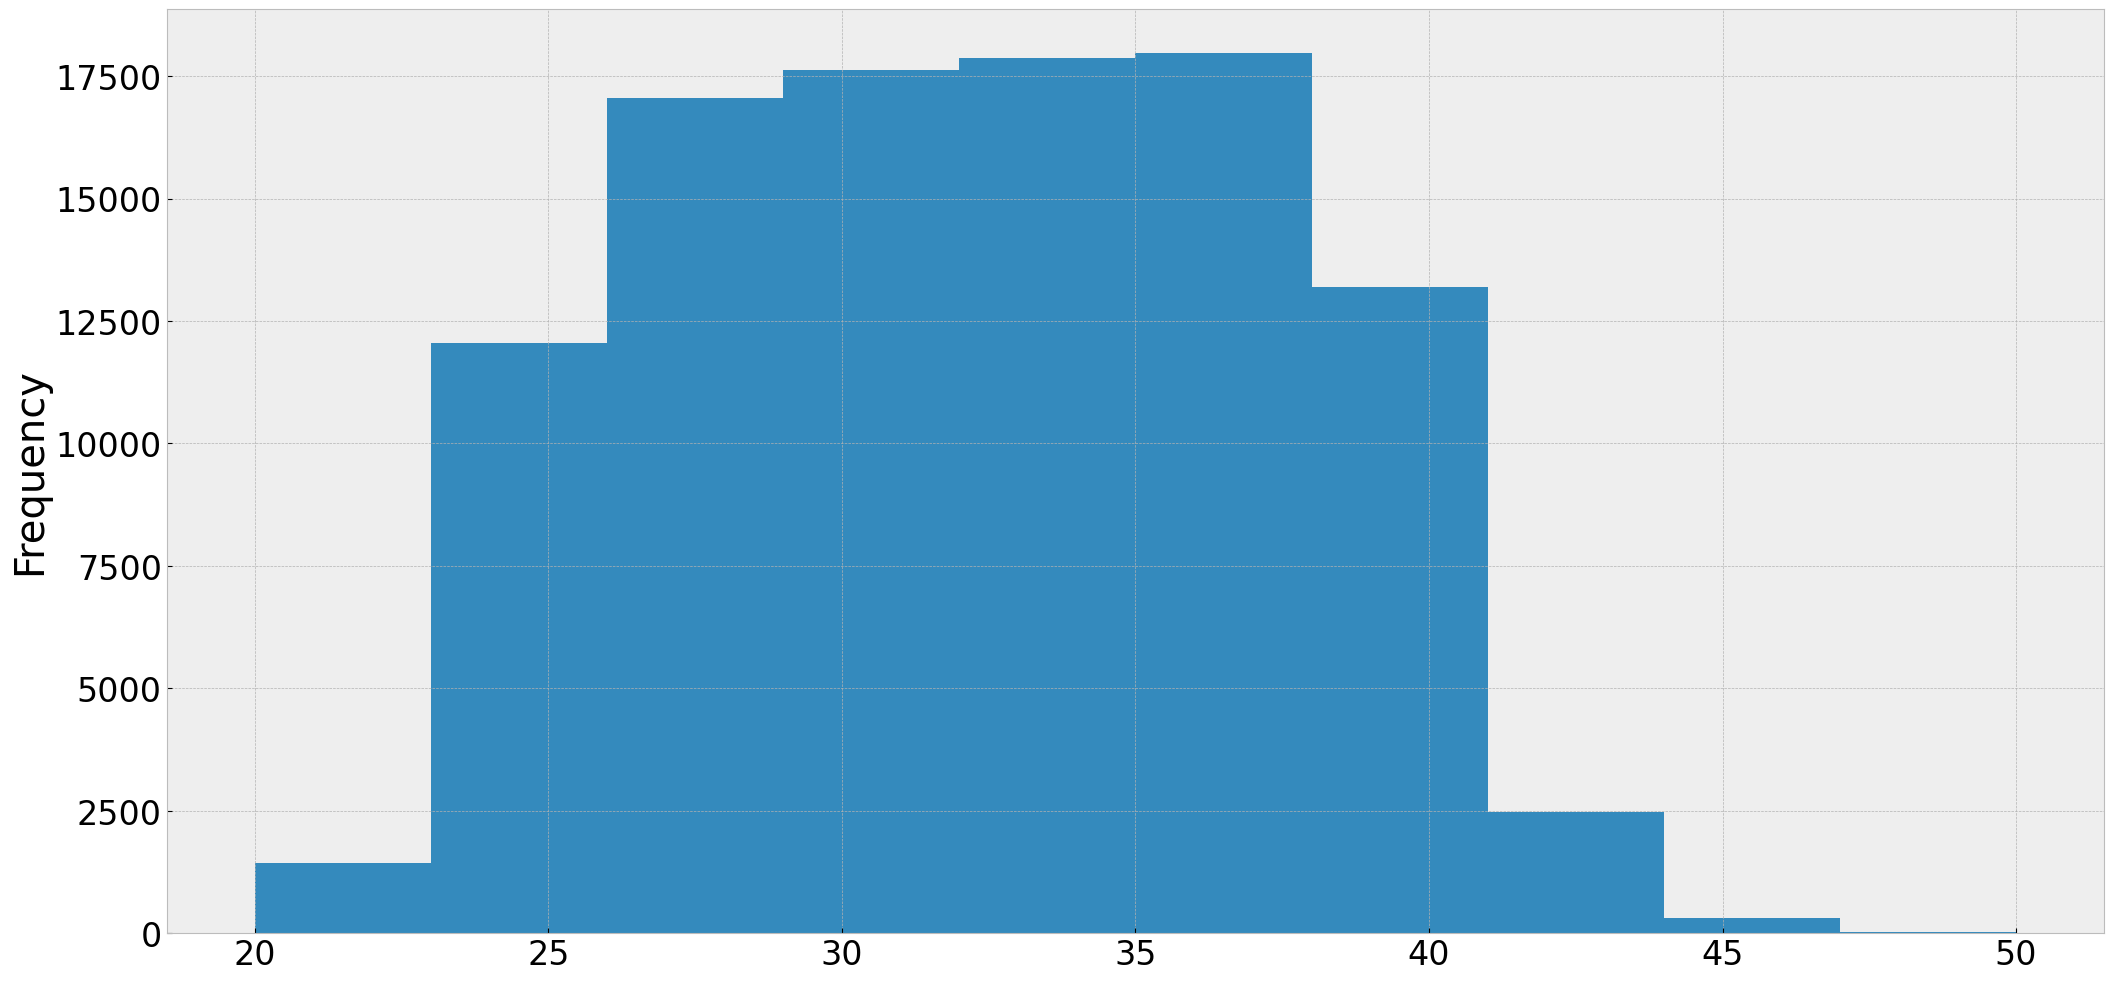

In [83]:
df1['Credit_Utilization_Ratio'].plot(kind='hist')

### Tratando a coluna Credit_History_Age

In [84]:
df1['Credit_History_Age'].value_counts(dropna=False)

NaN                       9030
15 Years and 11 Months     446
19 Years and 4 Months      445
19 Years and 5 Months      444
17 Years and 11 Months     443
                          ... 
0 Years and 3 Months        20
0 Years and 2 Months        15
33 Years and 7 Months       14
33 Years and 8 Months       12
0 Years and 1 Months         2
Name: Credit_History_Age, Length: 405, dtype: int64

In [85]:
df1['Credit_History_Age'] = df1['Credit_History_Age'].astype(str)

In [86]:
df1['Credit_History_Age']

0         22 Years and 1 Months
1                           nan
2         22 Years and 3 Months
3         22 Years and 4 Months
4         22 Years and 5 Months
                  ...          
99995     31 Years and 6 Months
99996     31 Years and 7 Months
99997     31 Years and 8 Months
99998     31 Years and 9 Months
99999    31 Years and 10 Months
Name: Credit_History_Age, Length: 100000, dtype: object

In [87]:
df1['Years_Credit_History'] = df1['Credit_History_Age'].apply(lambda x: str(x)[0:2] if x!="nan" else np.nan)
df1['Years_Credit_History'] = pd.to_numeric(df1['Years_Credit_History'])

In [88]:
df1['Months_Credit_History'] = df1['Credit_History_Age'].apply(lambda x: str(x)[-9:-6] if x!="nan" else np.nan)
df1['Months_Credit_History'] = pd.to_numeric(df1['Months_Credit_History'])

In [89]:
df1.loc[df1['Months_Credit_History'].isna(),'Months_Credit_History'] = df1.groupby('Customer_ID')['Months_Credit_History'].transform(lambda x: x.bfill() - 1 )
df1.loc[df1['Months_Credit_History'].isna(),'Months_Credit_History'] = df1.groupby('Customer_ID')['Months_Credit_History'].transform(lambda x: x.ffill() + 1 )

In [90]:
df1.loc[df1['Years_Credit_History'].isna(),'Years_Credit_History'] = df1.groupby('Customer_ID')['Years_Credit_History'].transform(lambda x: x.bfill())
df1.loc[df1['Years_Credit_History'].isna(),'Years_Credit_History'] = df1.groupby('Customer_ID')['Years_Credit_History'].transform(lambda x: x.ffill())

In [91]:
df1.loc[(df1['Months_Credit_History']== -1),'Years_Credit_History'] = df1['Years_Credit_History'] - 1

In [92]:
df1.loc[(df1['Months_Credit_History']==12),'Years_Credit_History'] = df1['Years_Credit_History'] + 1

In [93]:
df1.loc[(df1['Years_Credit_History']<0),'Years_Credit_History'] = 0

In [94]:
df1.loc[(df1['Months_Credit_History']<0),'Months_Credit_History'] = 11

In [95]:
df1.loc[(df1['Months_Credit_History']>11),'Months_Credit_History'] = 0

In [96]:
df1[df1['Customer_ID']=='CUS_0x95ee']

Customer_ID     Month  Age Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio     Credit_History_Age Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly                 Payment_Behaviour  Monthly_Balance Credit_Score  loan_type_PaydayLoan  loan_type_AutoLoan  loan_type_DebtConsolidationLoan  loan_type_NotSpecified  loan_type_PersonalLoan  loan_type_MortgageLoan  loan_type_HomeEquityLoan  loan_type_StudentLoan  loan_type_Credit-BuilderLoan  Years_Credit_History  Months_Credit_History
40  CUS_0x95ee   January   31     Lawyer      73928.460               5988.705              4.000                5              8            0                   12                  10.000                10.140                 2.000       Good           548.200                    39.963                    nan                    No            15015.000                   98.674   High_spent_Large_value_payments          740.196         Good                     0                   0                                0                       0                       0                       0                         0                      0                             0                31.000                 11.000
41  CUS_0x95ee  February   31     Lawyer      73928.460               5988.705              4.000                5              8            0                    8                   7.000                10.140                 2.000       Good           548.200                    42.770  32 Years and 0 Months                    NM                0.000                  172.939   Low_spent_Medium_value_payments          705.931         Good                     0                   0                                0                       0                       0                       0                         0                      0                             0                32.000                  0.000
42  CUS_0x95ee     March   31     Lawyer      73928.460               5988.705              4.000                5              8            0                    8                   7.000                10.140                 2.000       Good           548.200                    40.712                    nan                    No                0.000                  150.060  High_spent_Medium_value_payments          698.811         Good                     0                   0                                0                       0                       0                       0                         0                      0                             0                32.000                  1.000
43  CUS_0x95ee     April   31     Lawyer      73928.460               5988.705              4.000                5              8            0                    8                   7.000                10.140                 2.000       Good           548.200                    30.202  32 Years and 2 Months                    No                0.000                  618.202    Low_spent_Small_value_payments          270.668         Good                     0                   0                                0                       0                       0                       0                         0                      0                             0                32.000                  2.000
44  CUS_0x95ee       May   31     Lawyer      73928.460               5988.705              4.000                5              8            0                   11                   7.000                10.140                 2.000       Good           548.200                    26.333  32 Years and 3 Months                    No                0.000                  177.952    Low_spent_Large_value_payments          690.919         G

In [97]:
df1['Months_Credit_History'].value_counts()

11.000    8821
5.000     8800
10.000    8780
2.000     8734
4.000     8728
3.000     8723
8.000     8688
9.000     8677
0.000     7561
1.000     7553
6.000     7489
7.000     7446
Name: Months_Credit_History, dtype: int64

In [98]:
df1['Credit_History_Age'] = df1['Years_Credit_History'] + (df1['Months_Credit_History']/12)

In [99]:
df1 = df1.drop(['Years_Credit_History','Months_Credit_History'],axis=1)

In [100]:
df1.head()

Customer_ID     Month  Age Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio  Credit_History_Age Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly                 Payment_Behaviour  Monthly_Balance Credit_Score  loan_type_PaydayLoan  loan_type_AutoLoan  loan_type_DebtConsolidationLoan  loan_type_NotSpecified  loan_type_PersonalLoan  loan_type_MortgageLoan  loan_type_HomeEquityLoan  loan_type_StudentLoan  loan_type_Credit-BuilderLoan
0   CUS_0xd40   January   23  Scientist      19114.120               1824.843              3.000                4              3            4                    3                   7.000                11.270                 4.000       Good           809.980                    26.823              22.083                    No               49.575                   80.415   High_spent_Small_value_payments          312.494         Good                     0                   1                                0                       0                       1                       0                         1                      0                             1
1   CUS_0xd40  February   23  Scientist      19114.120               1824.843              3.000                4              3            4                   -1                   6.000                11.270                 4.000       Good           809.980                    31.945              22.167                    No               49.575                  118.280    Low_spent_Large_value_payments          284.629         Good                     0                   1                                0                       0                       1                       0                         1                      0                             1
2   CUS_0xd40     March   23  Scientist      19114.120               1824.843              3.000                4              3            4                    3                   7.000                10.270                 4.000       Good           809.980                    28.609              22.250                    No               49.575                   81.700   Low_spent_Medium_value_payments          331.210         Good                     0                   1                                0                       0                       1                       0                         1                      0                             1
3   CUS_0xd40     April   23  Scientist      19114.120               1824.843              3.000                4              3            4                    5                   4.000                 6.270                 4.000       Good           809.980                    31.378              22.333                    No               49.575                  199.458    Low_spent_Small_value_payments          223.451         Good                     0                   1                                0                       0                       1                       0                         1                      0                             1
4   CUS_0xd40       May   23  Scientist      19114.120               1824.843              3.000                4              3            4                    6                   6.000                11.270                 4.000       Good           809.980                    24.797              22.417                    No               49.575                   41.420  High_spent_Medium_value_payments          341.489         Good                     0                   1                                0                       0                       1                       0                         1                      0                             1

### Tratando a coluna Amount_invested_monthly

<AxesSubplot:ylabel='Frequency'>

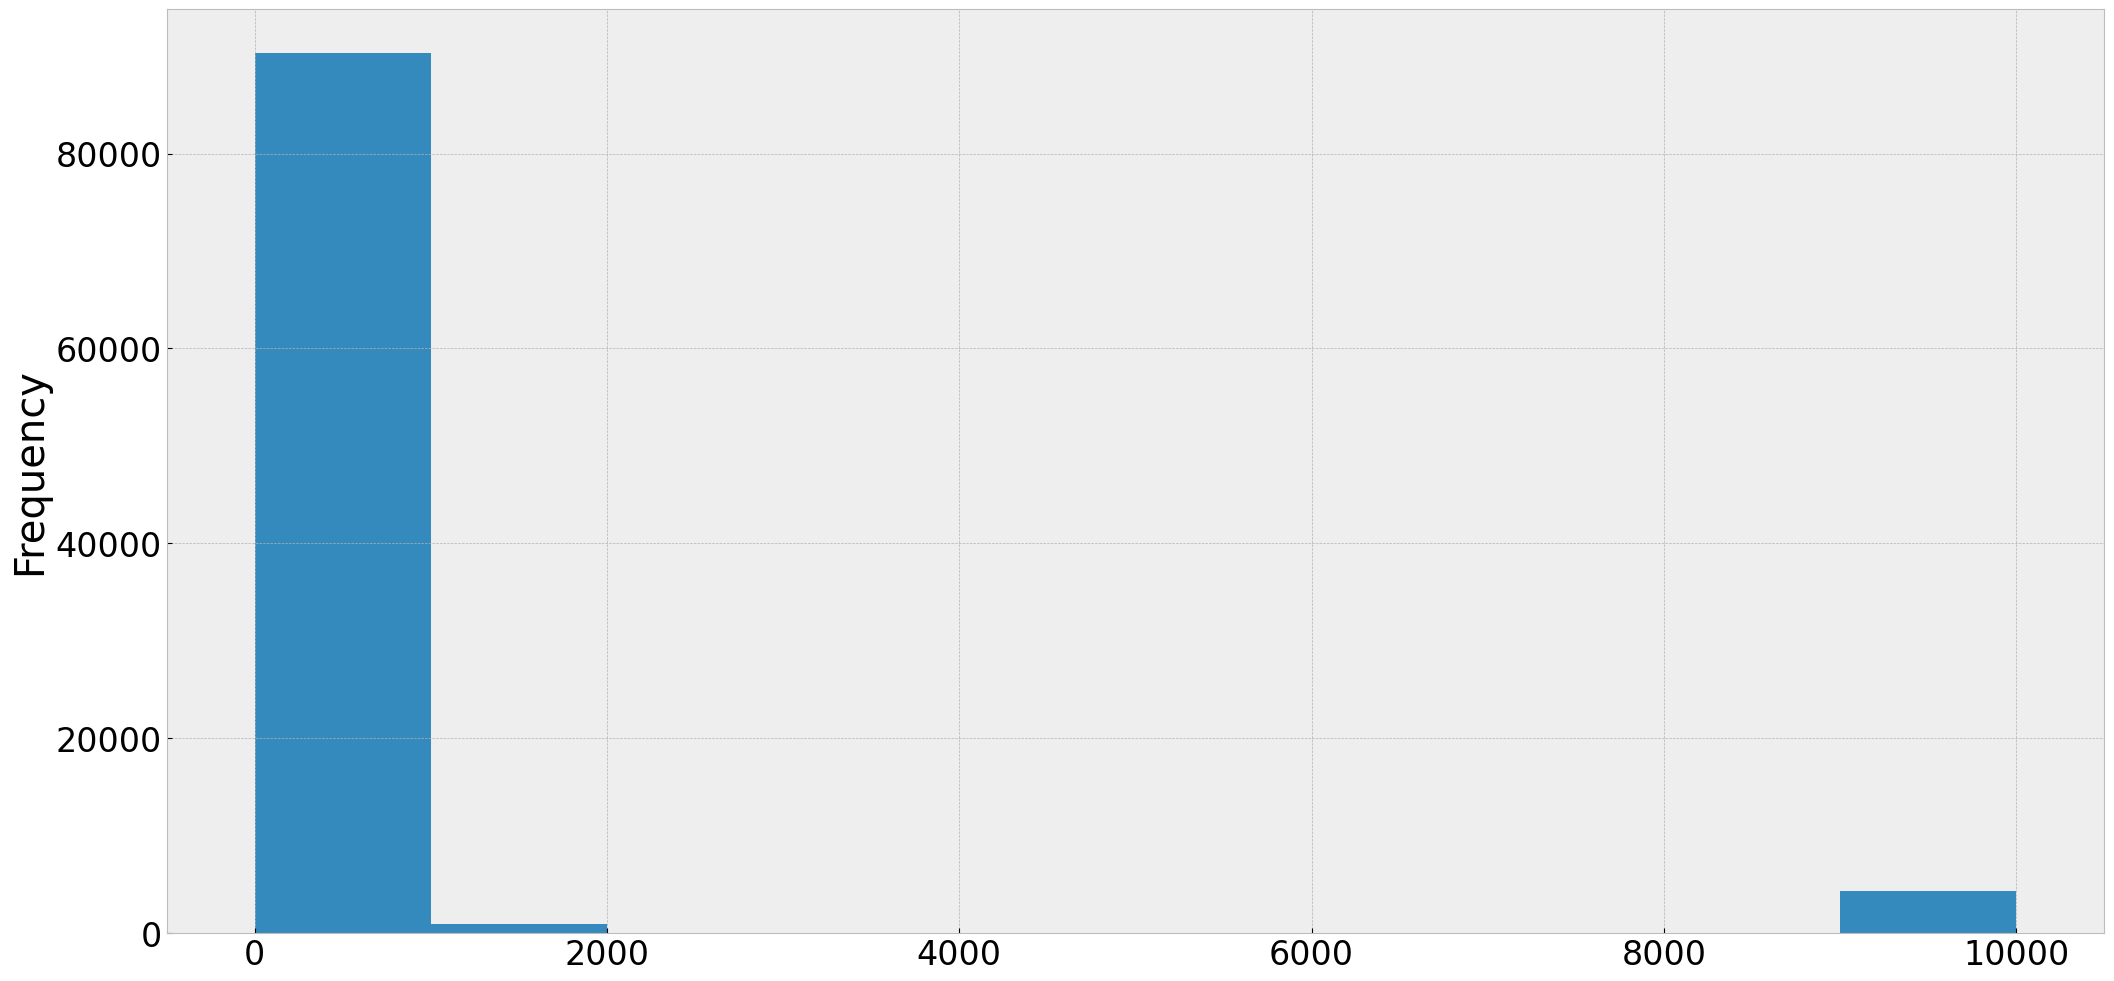

In [101]:
df1['Amount_invested_monthly'].plot(kind='hist')

In [102]:
df1['Amount_invested_monthly'].describe()

count   95521.000
mean      637.413
std      2043.319
min         0.000
25%        74.534
50%       135.926
75%       265.732
max     10000.000
Name: Amount_invested_monthly, dtype: float64

<AxesSubplot:ylabel='Frequency'>

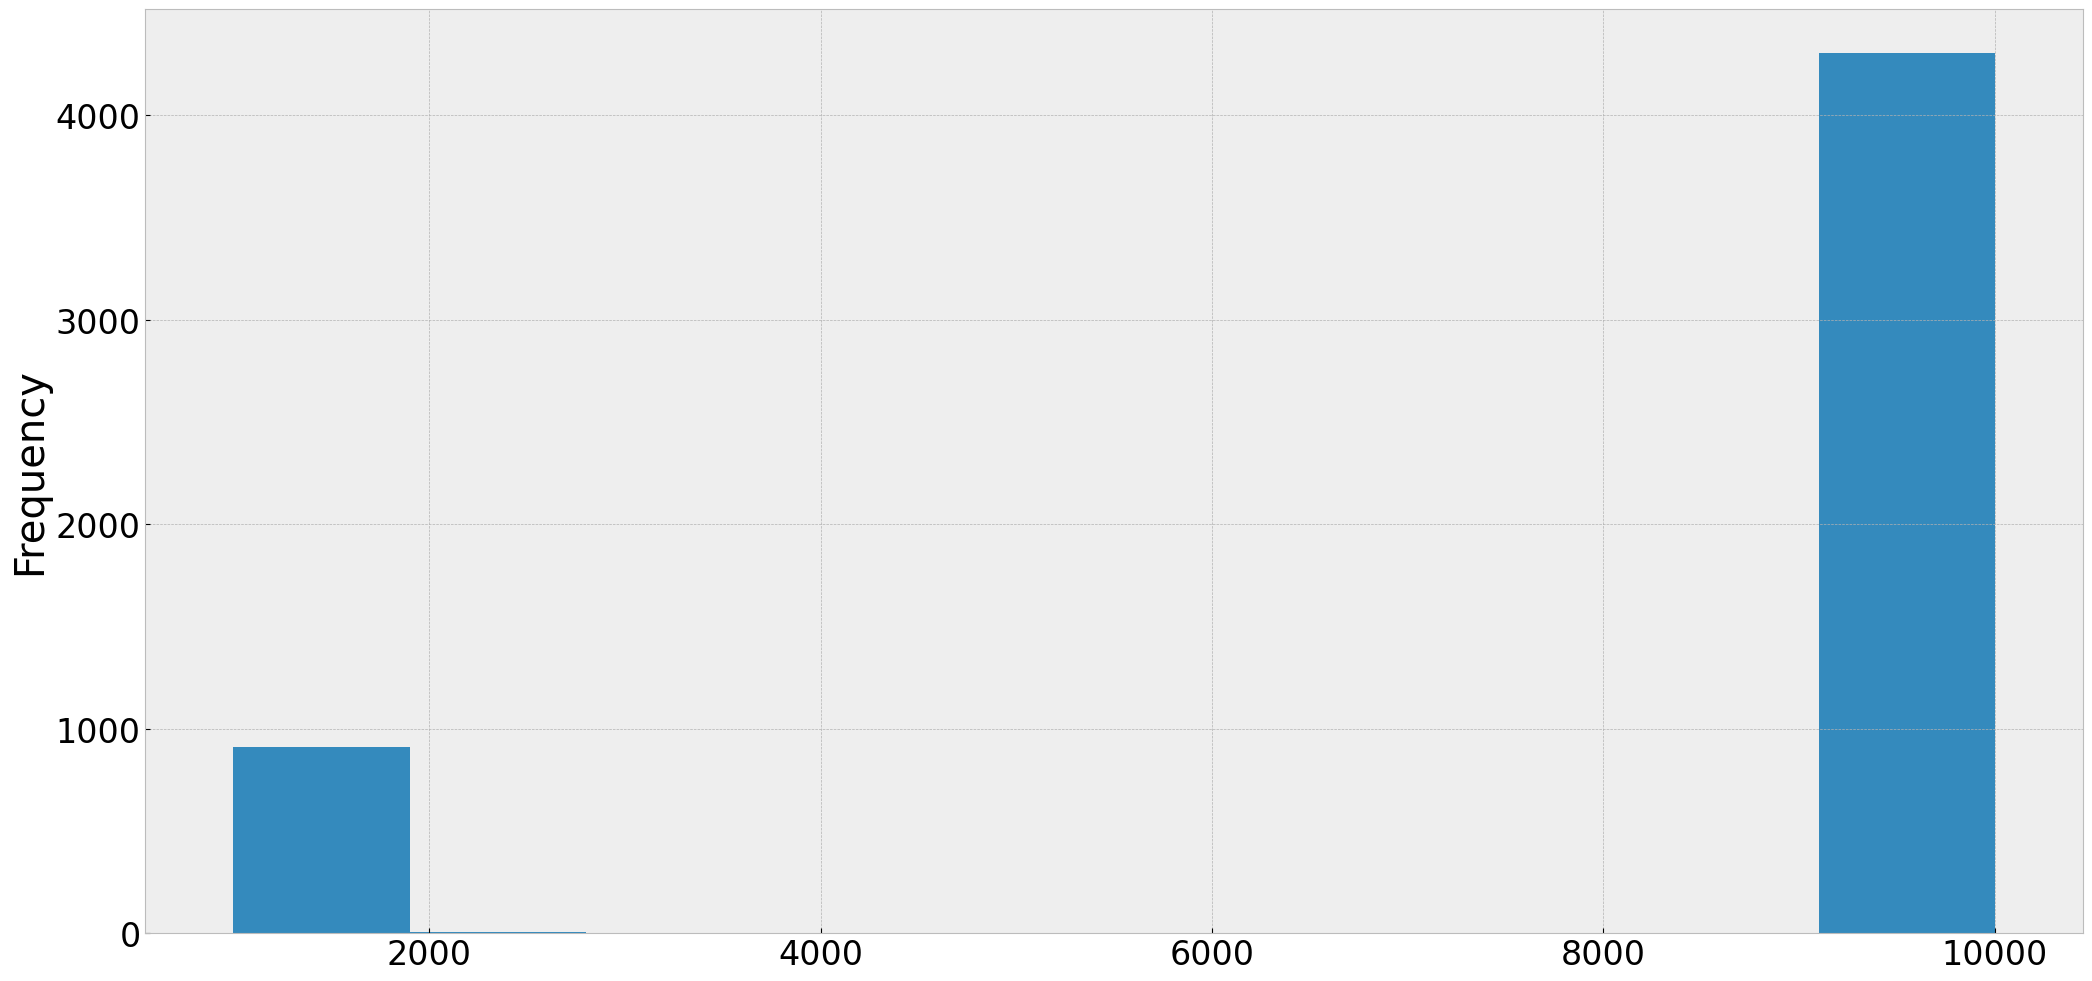

In [103]:
df1[df1['Amount_invested_monthly']>1000]['Amount_invested_monthly'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

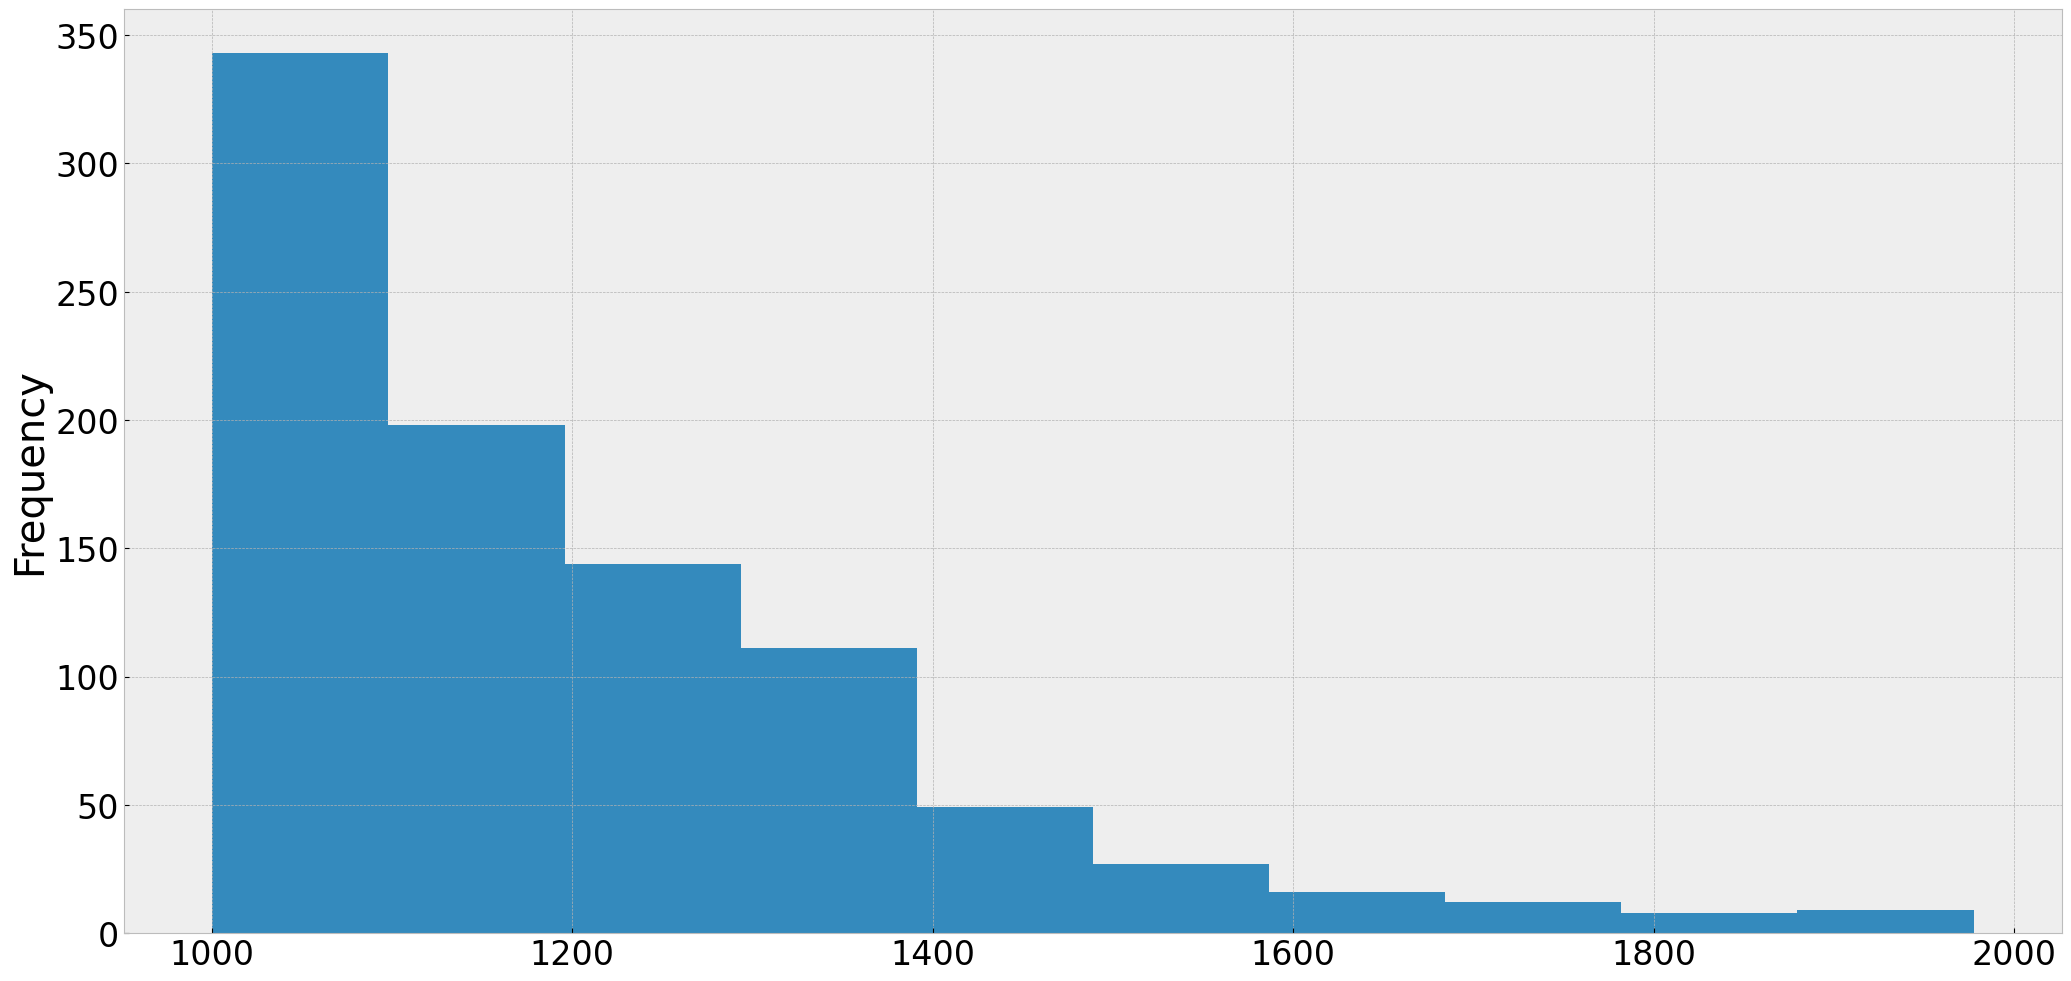

In [104]:
df1[(df1['Amount_invested_monthly']>1000)&(df1['Amount_invested_monthly']<10000)]['Amount_invested_monthly'].plot(kind='hist')

In [105]:
df1['Amount_invested_monthly'].value_counts().reset_index().sort_values('index',ascending=False)

index  Amount_invested_monthly
0     10000.000                     4305
89358  1977.326                        1
3714   1961.219                        1
11446  1944.521                        1
81139  1941.237                        1
...         ...                      ...
88951    10.054                        1
28647    10.037                        1
20063    10.011                        1
5349     10.010                        1
1         0.000                      169

[91049 rows x 2 columns]

In [106]:
df1.loc[df1['Amount_invested_monthly']==10000,'Amount_invested_monthly'] = np.nan

df1.loc[df1['Amount_invested_monthly'].isna(),'Amount_invested_monthly'] = df1.groupby('Customer_ID')['Amount_invested_monthly'].transform(mean)

<AxesSubplot:ylabel='Frequency'>

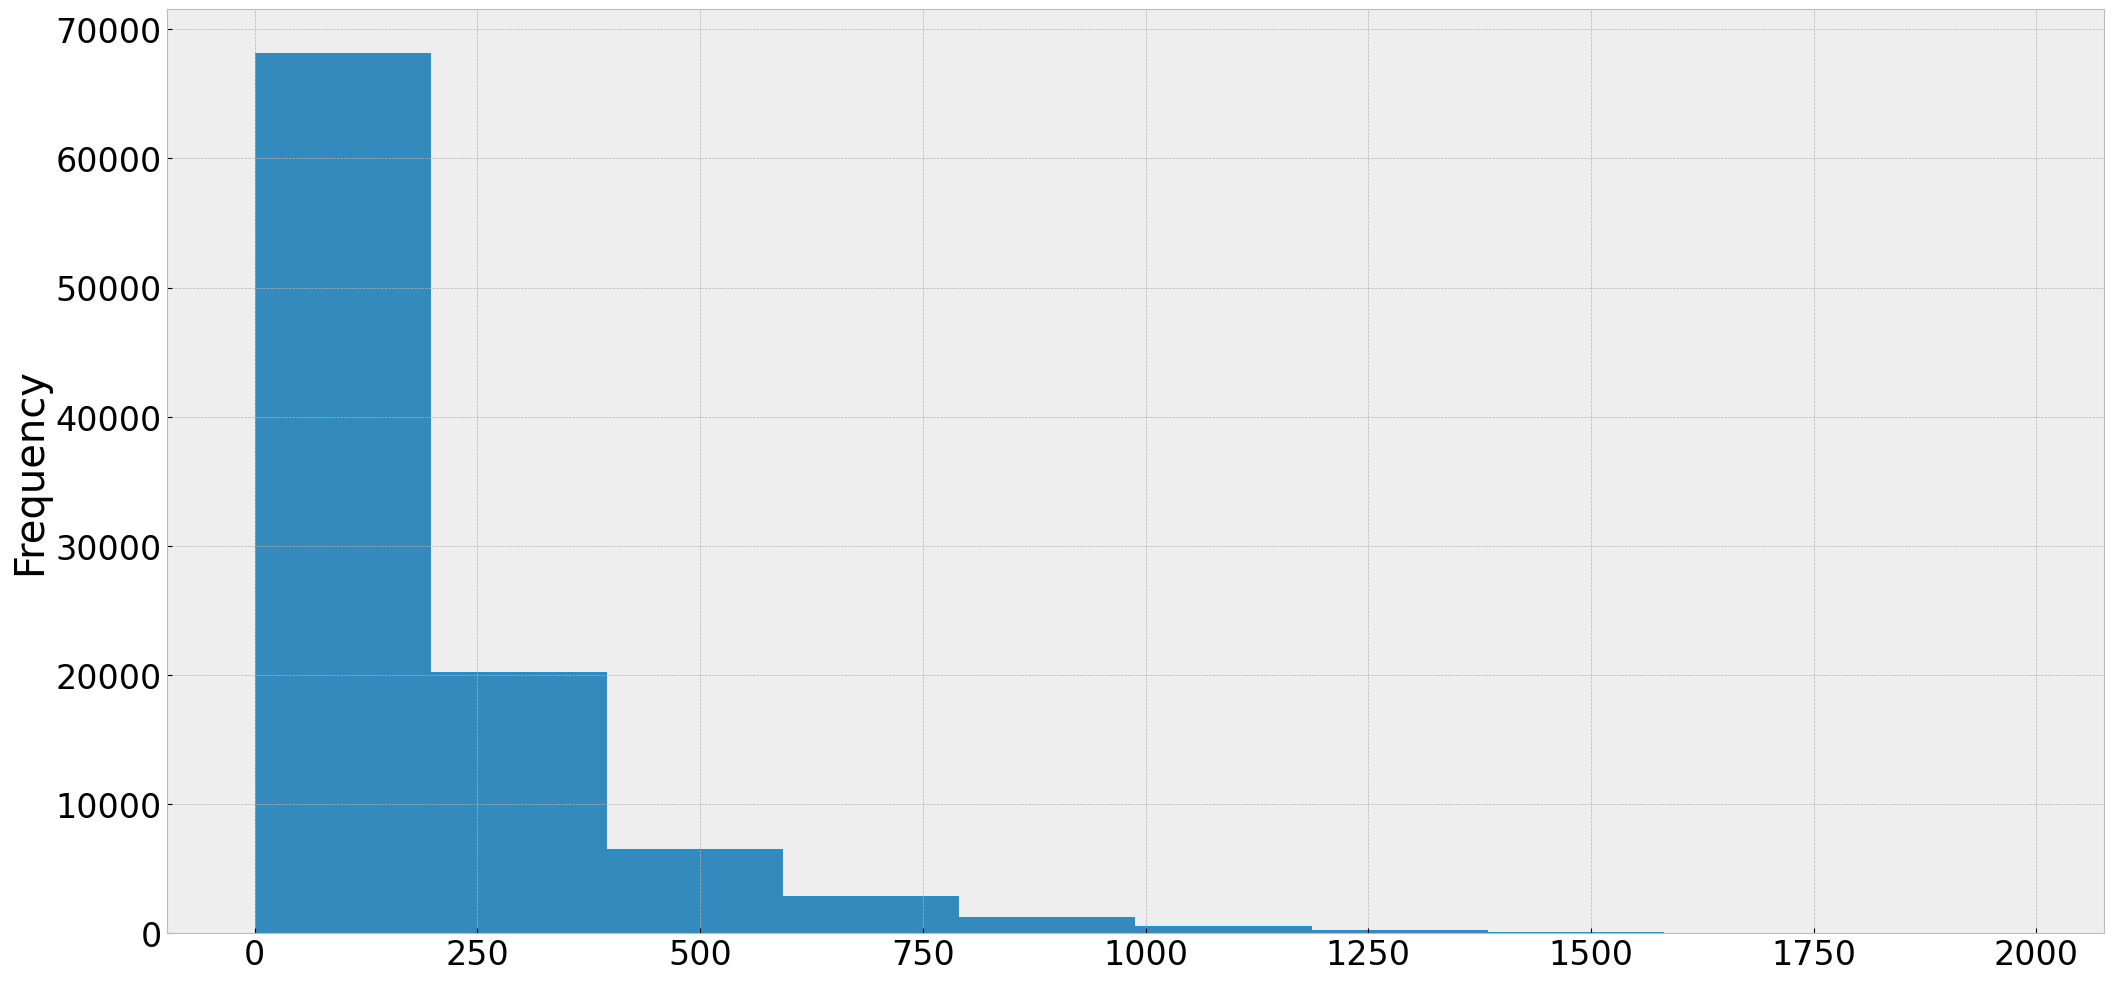

In [107]:
df1['Amount_invested_monthly'].plot(kind='hist')

### Trantando a coluna Payment_of_Min_Amount

In [108]:
df1['Payment_of_Min_Amount'].value_counts(dropna=False)

Yes    52326
No     35667
NM     12007
Name: Payment_of_Min_Amount, dtype: int64

In [109]:
df1.loc[df1['Payment_of_Min_Amount'] == 'NM','Payment_of_Min_Amount'] = ''

df1.loc[df1['Payment_of_Min_Amount']=='','Payment_of_Min_Amount'] = df1.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(calcular_moda)

In [110]:
df1['Payment_of_Min_Amount'].value_counts(dropna=False)

Yes    59432
No     40568
Name: Payment_of_Min_Amount, dtype: int64

In [111]:
df1.loc[df1['Payment_of_Min_Amount']=='Yes','Payment_of_Min_Amount'] = 1
df1.loc[df1['Payment_of_Min_Amount']=='No','Payment_of_Min_Amount'] = 0
df1['Payment_of_Min_Amount'] = df1['Payment_of_Min_Amount'].astype(int)

<AxesSubplot:xlabel='Payment_of_Min_Amount', ylabel='Count'>

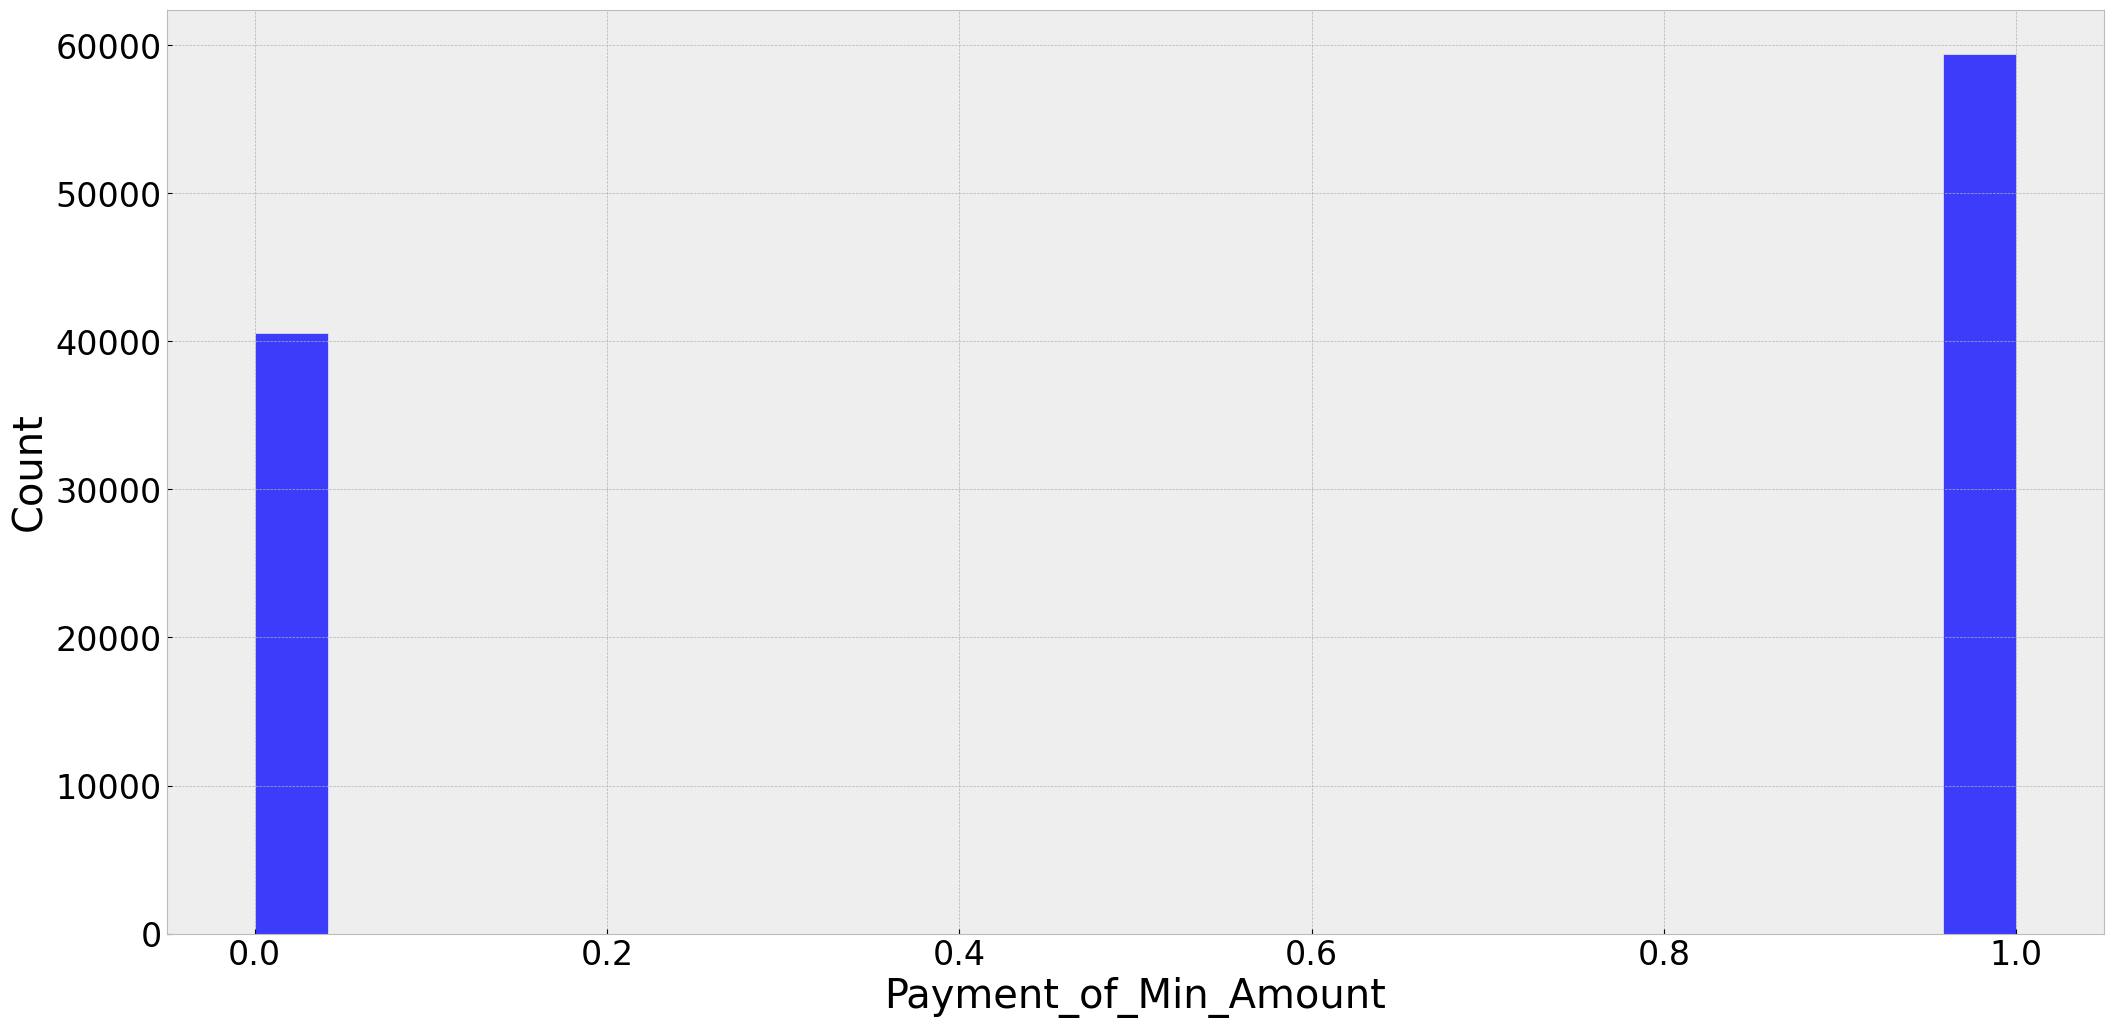

In [112]:
sns.histplot(df1['Payment_of_Min_Amount'])

### Tratando a coluna Total_EMI_per_month

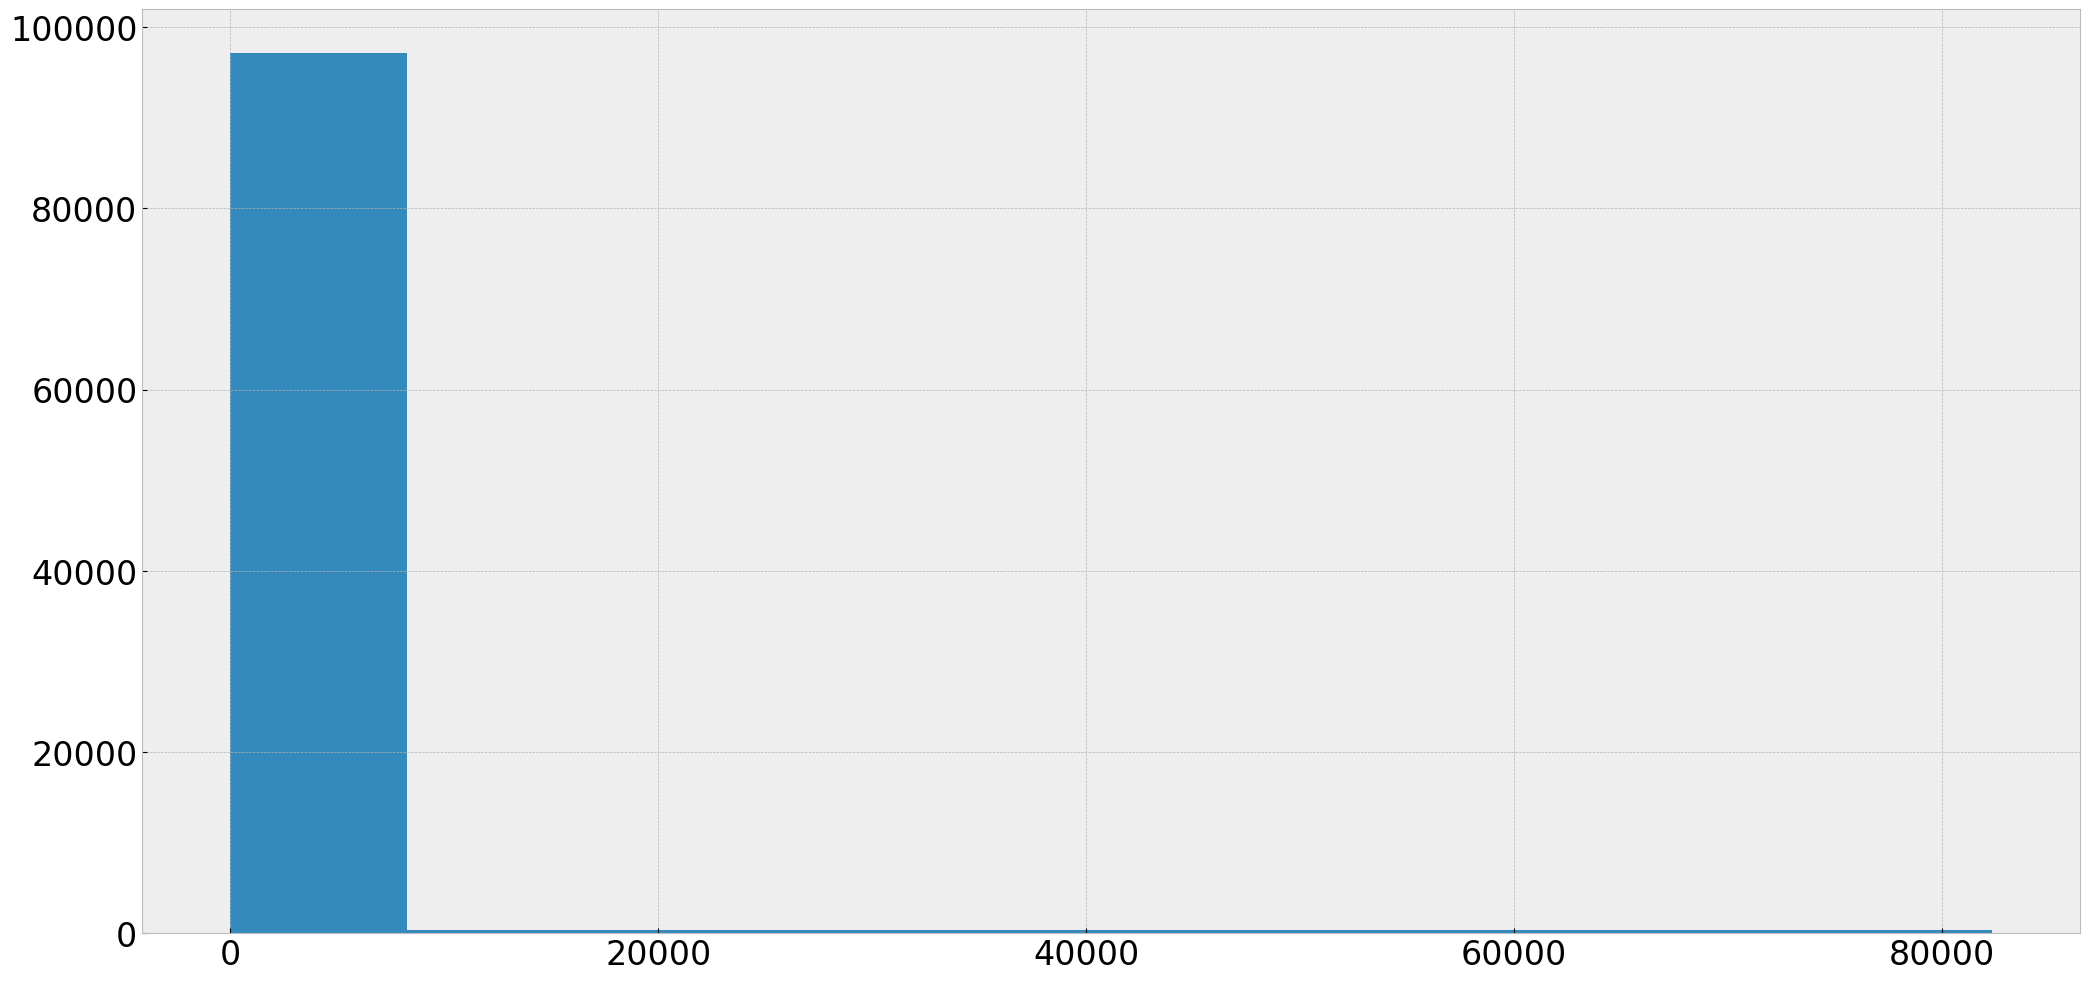

In [113]:
hist(df1['Total_EMI_per_month']);

In [ ]:
sns.boxplot(df1['Total_EMI_per_month']);

Criaremos uma coluna zscore para entender os outliers presentes na base por grupo, dessa forma podemos tratar esses valores que foram inputados de forma errada.

In [115]:
df1['zscore'] = df1.groupby('Customer_ID')['Total_EMI_per_month'].transform(lambda x: zscore(x,axis=0,nan_policy='omit'))
df1.loc[df1['zscore'].isna(),'zscore'] = 0
df1.loc[df1['zscore']>=1.3,'Total_EMI_per_month'] = np.nan

while max(df1['zscore']) >= 1.3:
    
    print(max(df1['zscore']))
    df1['zscore'] = df1.groupby('Customer_ID')['Total_EMI_per_month'].transform(lambda x: zscore(x,axis=0,nan_policy='omit'))
    df1.loc[df1['zscore'].isna(),'zscore'] = 0
    df1.loc[df1['zscore']>=1.3,'Total_EMI_per_month'] = np.nan
    print(max(df1['zscore']))

df1.loc[df1['Total_EMI_per_month'].isna(),'Total_EMI_per_month'] =  df1.groupby('Customer_ID')['Total_EMI_per_month'].transform(mean)

df1.drop('zscore',axis=1,inplace=True)

2.6457513110645916
2.4494897427831788
2.4494897427831788
2.2360679774997902
2.2360679774997902
2.0
2.0
1.2909944487358074


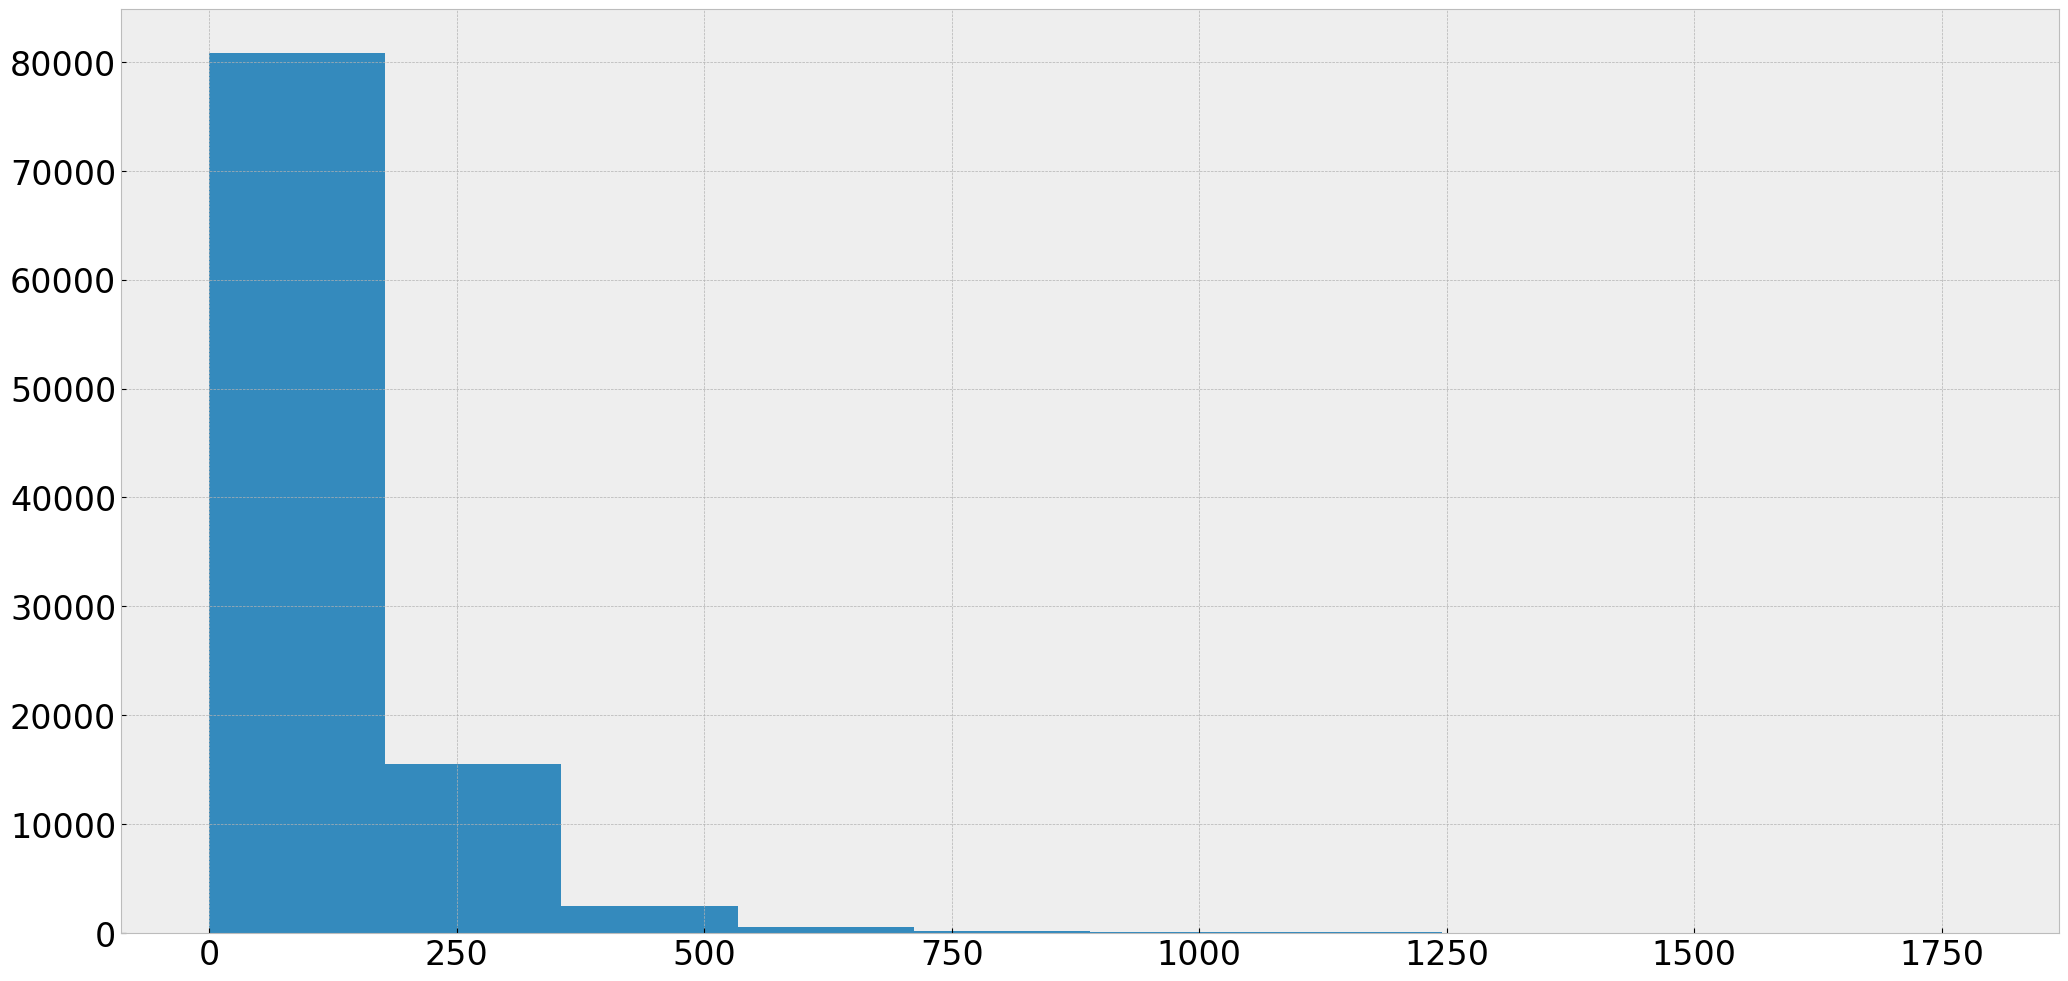

In [116]:
hist(df1['Total_EMI_per_month']);

In [ ]:
sns.boxplot(df1['Total_EMI_per_month']);

### Tratando a Coluna Monthly_Balance

In [118]:
df1['Monthly_Balance'].describe()

count                         98800.000
mean        30364372469635625254912.000
std       3181295008379834214645760.000
min                               0.008
25%                             270.114
50%                             336.742
75%                             470.332
max     333333333333333314856026112.000
Name: Monthly_Balance, dtype: float64

In [ ]:
plt.subplot(1,2,1)
sns.boxplot(df1['Monthly_Balance'])

plt.subplot(1,2,2)
hist(df1['Monthly_Balance'])
plt.tight_layout()

In [120]:
df1['Monthly_Balance'].value_counts(dropna=False).to_frame().sort_index(ascending=False)

Monthly_Balance
333333333333333314856026112.000                9
1602.041                                       1
1576.289                                       1
1567.208                                       1
1566.613                                       1
...                                          ...
0.131                                          1
0.095                                          1
0.089                                          1
0.008                                          1
NaN                                         1200

[98793 rows x 1 columns]

In [121]:
df1.loc[df1['Monthly_Balance']>2000,'Monthly_Balance'] = np.nan
df1.loc[df1['Monthly_Balance'].isna(),'Monthly_Balance'] = df1.groupby('Customer_ID')['Monthly_Balance'].transform(mean)

In [122]:
df1['Monthly_Balance'].describe()

count   100000.000
mean       403.120
std        214.015
min          0.008
25%        270.189
50%        337.114
75%        471.571
max       1602.041
Name: Monthly_Balance, dtype: float64

In [123]:
df1['Monthly_Balance'].describe()

count   100000.000
mean       403.120
std        214.015
min          0.008
25%        270.189
50%        337.114
75%        471.571
max       1602.041
Name: Monthly_Balance, dtype: float64

In [ ]:
plt.subplot(1,2,1)
sns.boxplot(df1['Monthly_Balance'])

plt.subplot(1,2,2)
sns.histplot(df1['Monthly_Balance'])
plt.tight_layout()

In [125]:
df1.columns

Index(['Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'loan_type_PaydayLoan', 'loan_type_AutoLoan',
       'loan_type_DebtConsolidationLoan', 'loan_type_NotSpecified',
       'loan_type_PersonalLoan', 'loan_type_MortgageLoan',
       'loan_type_HomeEquityLoan', 'loan_type_StudentLoan',
       'loan_type_Credit-BuilderLoan'],
      dtype='object')

In [126]:
df1['Month'].value_counts(dropna=False)

January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: Month, dtype: int64

## Estatísticas Descritivas

In [127]:
num_attributes = df1.select_dtypes(include=['int','float'])
cat_attributes = df1.select_dtypes(exclude=['float','int','datetime64[ns]'])

In [128]:
# Medidas de tendência central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Medidas de dispersão
dp1 = pd.DataFrame(num_attributes.apply(np.std)).T
dp2 = pd.DataFrame(num_attributes.apply(min)).T
dp3 = pd.DataFrame(num_attributes.apply(max)).T
dp4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dp5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dp6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
dp7 = pd.DataFrame(num_attributes.apply(lambda x: x.quantile(0.25))).T
dp8 = pd.DataFrame(num_attributes.apply(lambda x: x.quantile(0.75))).T

# Concatenando as medidas
m = pd.concat([ct1,ct2,dp1,dp2,dp3,dp4,dp5,dp6,dp7,dp8]).T.reset_index()
m.columns = ["Variável","média","mediana","Desvio Padrão","Mínimo","Máximo","Amplitude","Skewness","Kurtosis","1st quartile","3rd quartile"]
m['coeficiente variacao'] = m['Desvio Padrão']/m['média'] * 100
m


Variável     média   mediana  Desvio Padrão   Mínimo     Máximo  Amplitude  Skewness  Kurtosis  1st quartile  3rd quartile  coeficiente variacao
0                               Age    33.275    33.000         10.764   14.000     56.000     42.000     0.158    -0.927        24.000        42.000                32.350
1                     Annual_Income 50505.123 36999.705      38299.231 7005.930 179987.280 172981.350     1.130     0.608     19342.972     71683.470                75.832
2             Monthly_Inhand_Salary  4199.449  3095.942       3188.308  303.645  15204.633  14900.988     1.129     0.619      1628.240      5962.530                75.922
3                 Num_Bank_Accounts     5.370     5.000          2.593    0.000     10.000     10.000    -0.190    -0.692         3.000         7.000                48.279
4                   Num_Credit_Card     5.535     5.000          2.067    1.000     11.000     10.000     0.227    -0.330         4.000         7.000                37.341
5                     Interest_Rate    14.532    13.000          8.741    1.000     34.000     33.000     0.496    -0.682         7.000        20.000                60.152
6                       Num_of_Loan     3.533     3.000          2.446    0.000      9.000      9.000     0.446    -0.615         2.000         5.000                69.245
7               Delay_from_due_date    21.069    18.000         14.860   -5.000     67.000     72.000     0.966     0.348        10.000        28.000                70.531
8            Num_of_Delayed_Payment    13.339    14.000          6.254    0.000     28.000     28.000    -0.179    -0.682         9.000        18.000                46.889
9              Changed_Credit_Limit    10.465     9.400          6.666    0.000     36.970     36.970     0.729     0.101         5.350        14.850                63.697
10             Num_Credit_Inquiries     5.779     5.000          3.862    0.000     29.000     29.000     0.410    -0.598         3.000         8.000                66.837
11                 Outstanding_Debt  1426.220  1166.155       1155.123    0.230   4998.070   4997.840     1.208     0.905       566.072      1945.963                80.992
12         Credit_Utilization_Ratio    32.285    32.306          5.117   20.000     50.000     30.000     0.029    -0.944        28.053        36.497                15.849
13               Credit_History_Age    18.434    18.250          8.307    0.083     33.667     33.583    -0.049    -0.902        12.000        25.167                45.061
14            Payment_of_Min_Amount     0.594     1.000          0.491    0.000      1.000      1.000    -0.384    -1.852         0.000         1.000                82.619
15              Total_EMI_per_month   105.929    66.210        126.403    0.000   1779.103   1779.103     3.802    27.763        29.058       145.930               119.328
16          Amount_invested_monthly   195.752   131.209        195.115    0.000   1977.326   1977.326     2.548     8.852        74.600       239.480                99.675
17                  Monthly_Balance   403.120   337.114        214.013    0.008   1602.041   1602.033     1.587     2.911       270.189       471.571                53.089
18             loan_type_PaydayLoan     0.319     0.000          0.466    0.000      1.000      1.000     0.775    -1.400         0.000         1.000               145.962
19               loan_type_AutoLoan     0.306     0.000          0.461    0.000      1.000      1.000     0.844    -1.288         0.000         1.000               150.740
20  loan_type_DebtConsolidationLoan     0.310     0.000          0.463    0.000      1.000      1.000     0.820    -1.328         0.000         1.000               149.052
21           loan_type_NotSpecified     0.317     0.000          0.465    0.000      1.000      1.000     0.788    -1.380         0.000         1.000               146.852
22           loan_type_PersonalLoan     0.311     0.000          0.463 

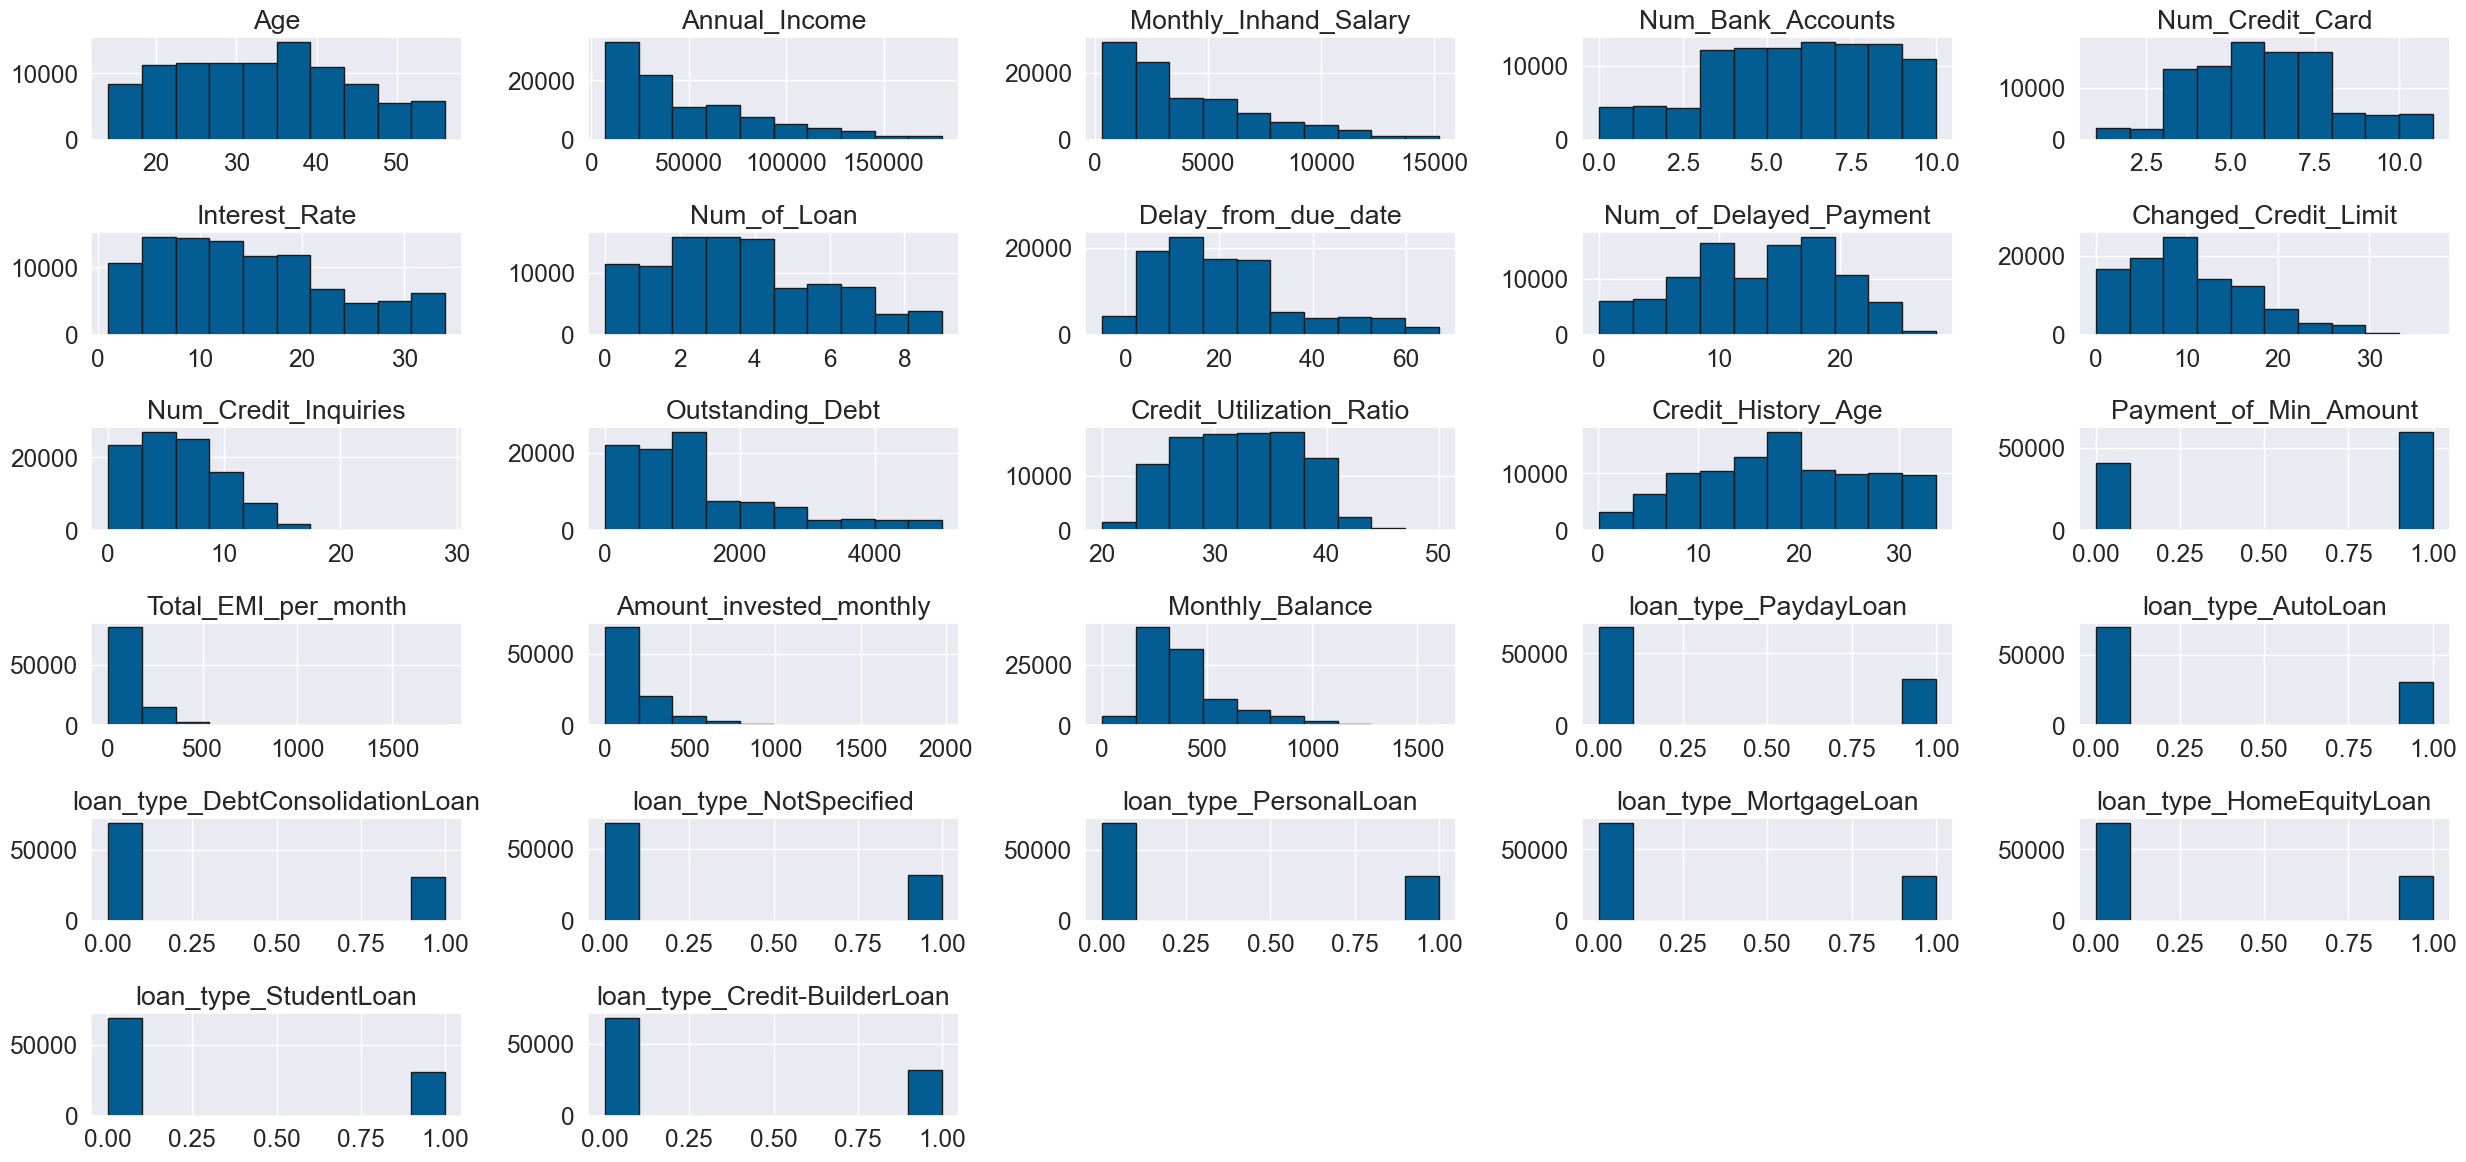

In [129]:
params = {'axes.titlesize':'20',
          'xtick.labelsize':'16',
          'ytick.labelsize':'16'}
matplotlib.rcParams.update(params)
sns.set(font_scale=1.6) 
sns.set_palette('PuBu_r')
num_attributes.hist(ec="k")
plt.tight_layout()

<AxesSubplot:xlabel='Credit_Score', ylabel='Count'>

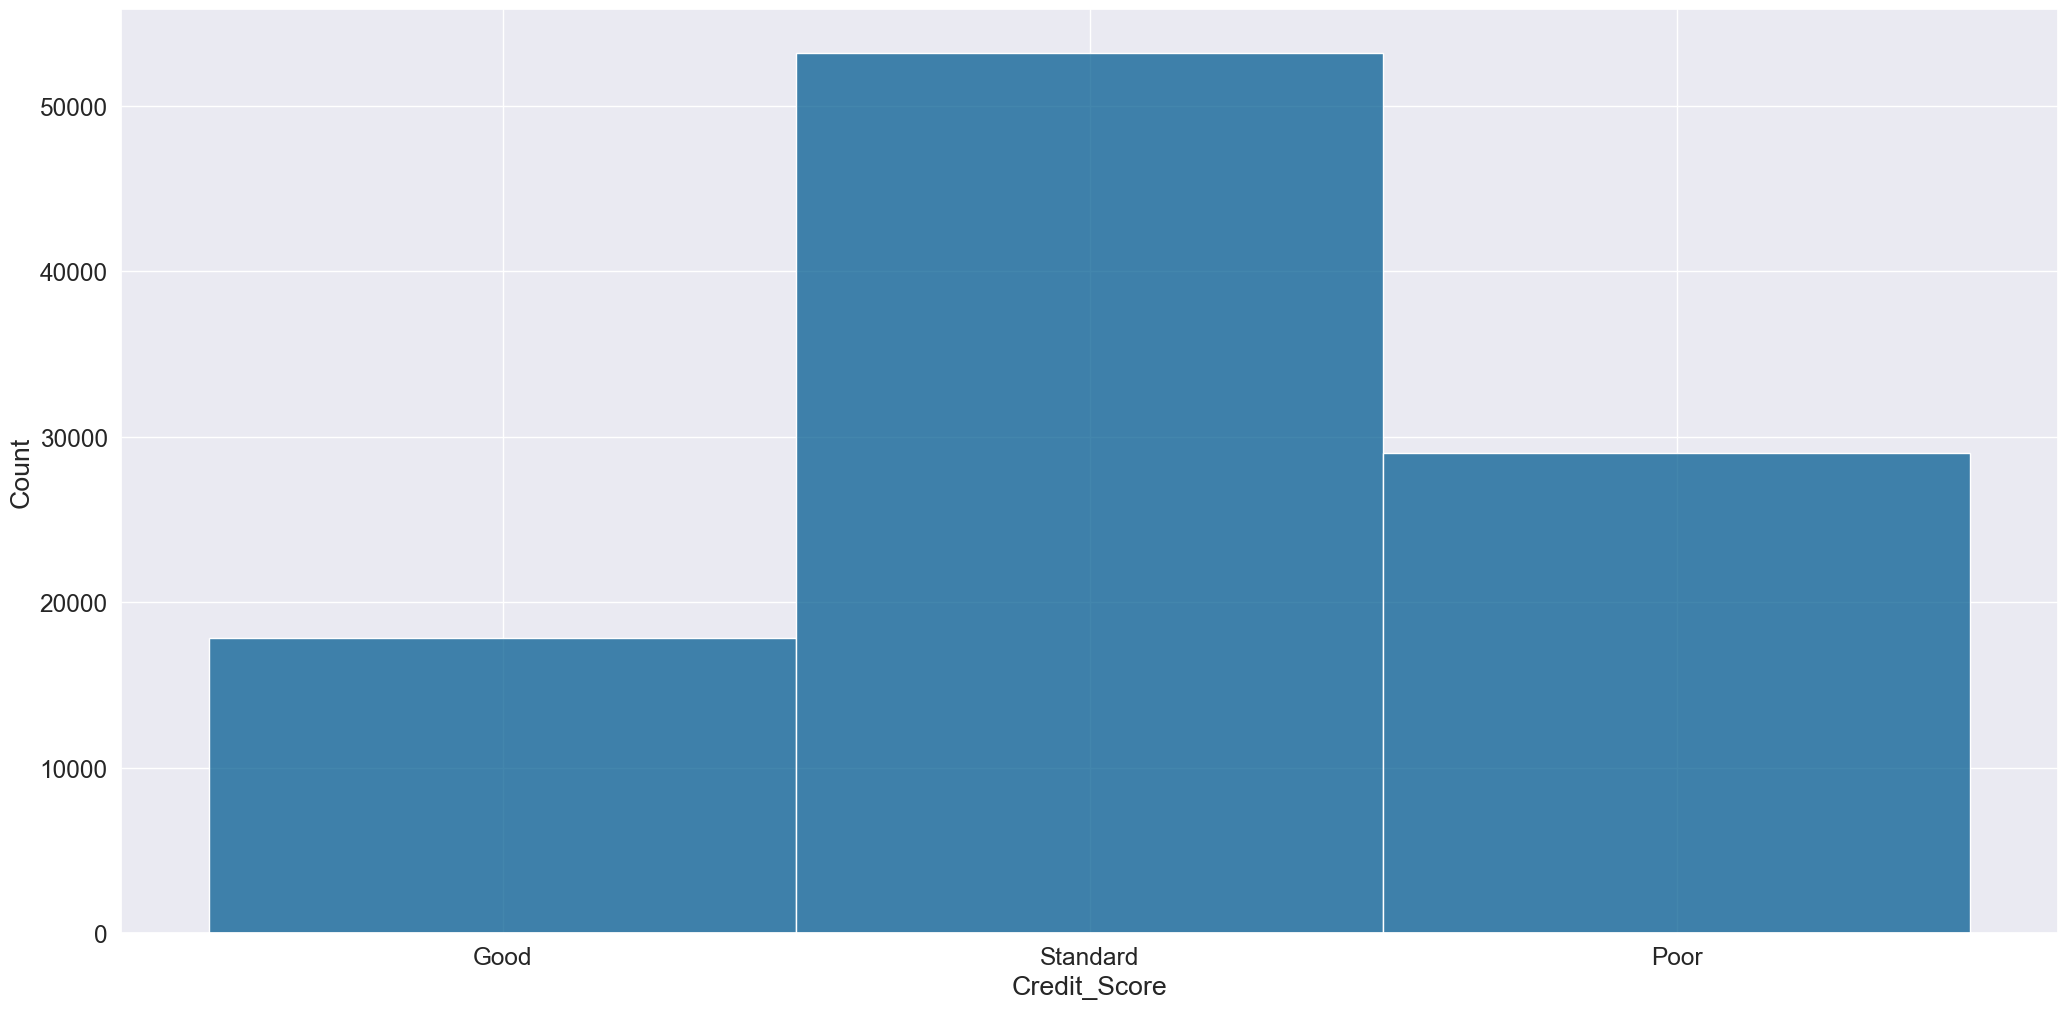

In [130]:
sns.histplot(x=df1['Credit_Score'])

In [131]:
df1.groupby('Credit_Score')['Customer_ID'].count()

Credit_Score
Good        17828
Poor        28998
Standard    53174
Name: Customer_ID, dtype: int64

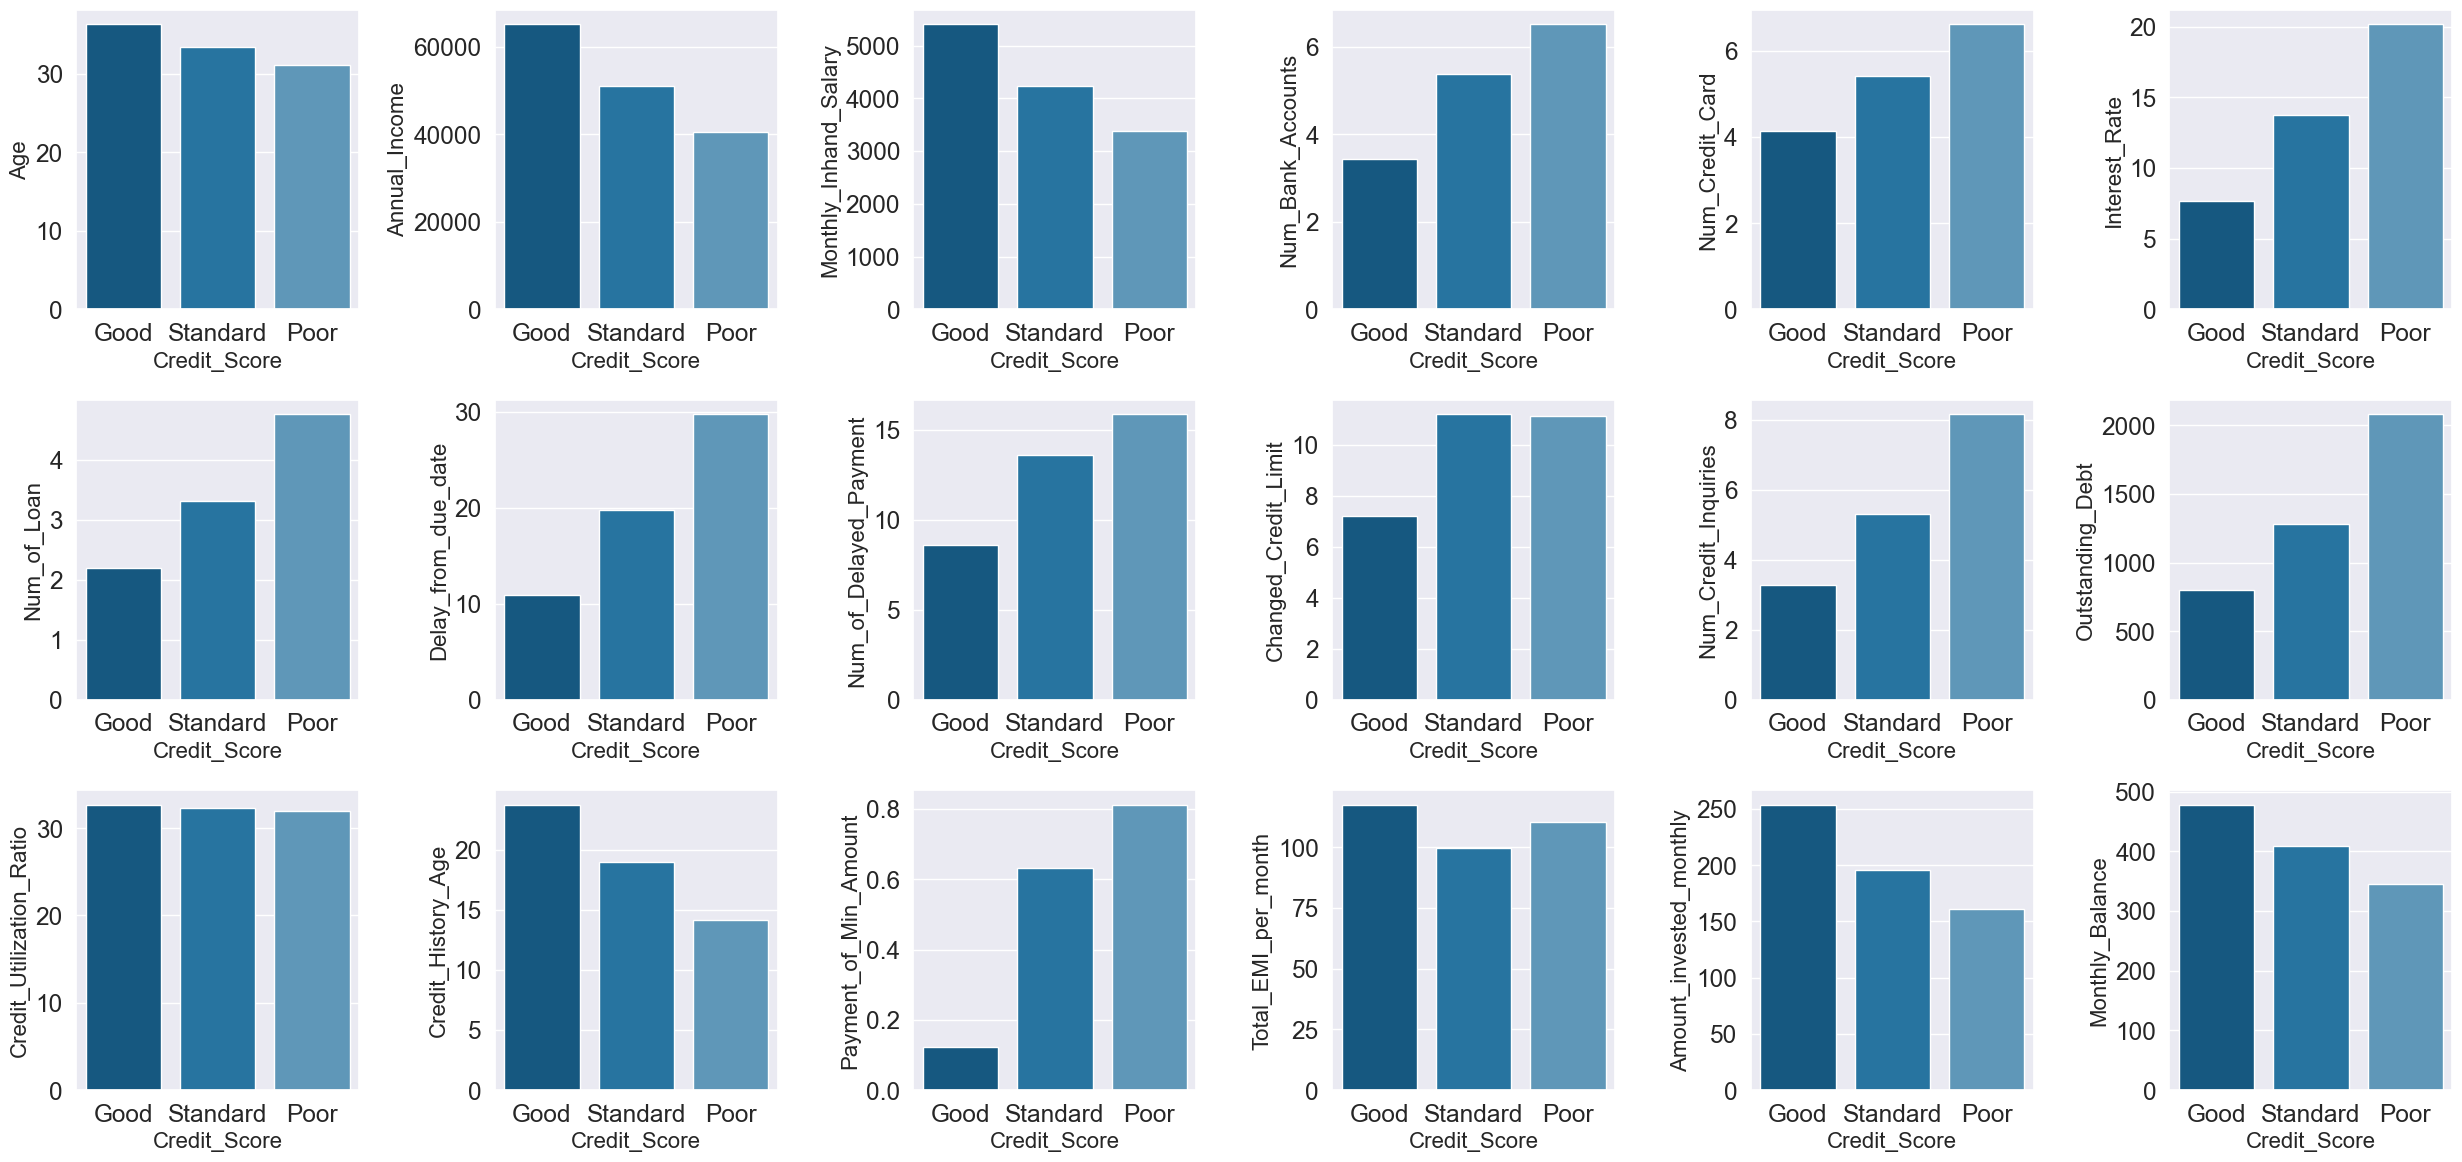

In [132]:
aux1 = df1.groupby('Credit_Score').mean().reset_index().sort_values('Age',ascending=False)

colunas = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance']

figura = plt.figure()

sns.set(font_scale=1.6) 
sns.set_palette('PuBu_r')

for i,var in enumerate(colunas):
    
    figura.add_subplot(3,6,i+1)
    sns.barplot(x="Credit_Score",y=f'{var}',data=aux1)
    
    plt.xlabel("Credit_Score", fontsize=16)  # Altere o tamanho da fonte do rótulo x conforme necessário
    plt.ylabel(f'{var}', fontsize=16)  # Altere o tamanho da fonte do rótulo y conforme necessário
   
plt.tight_layout()
plt.show()

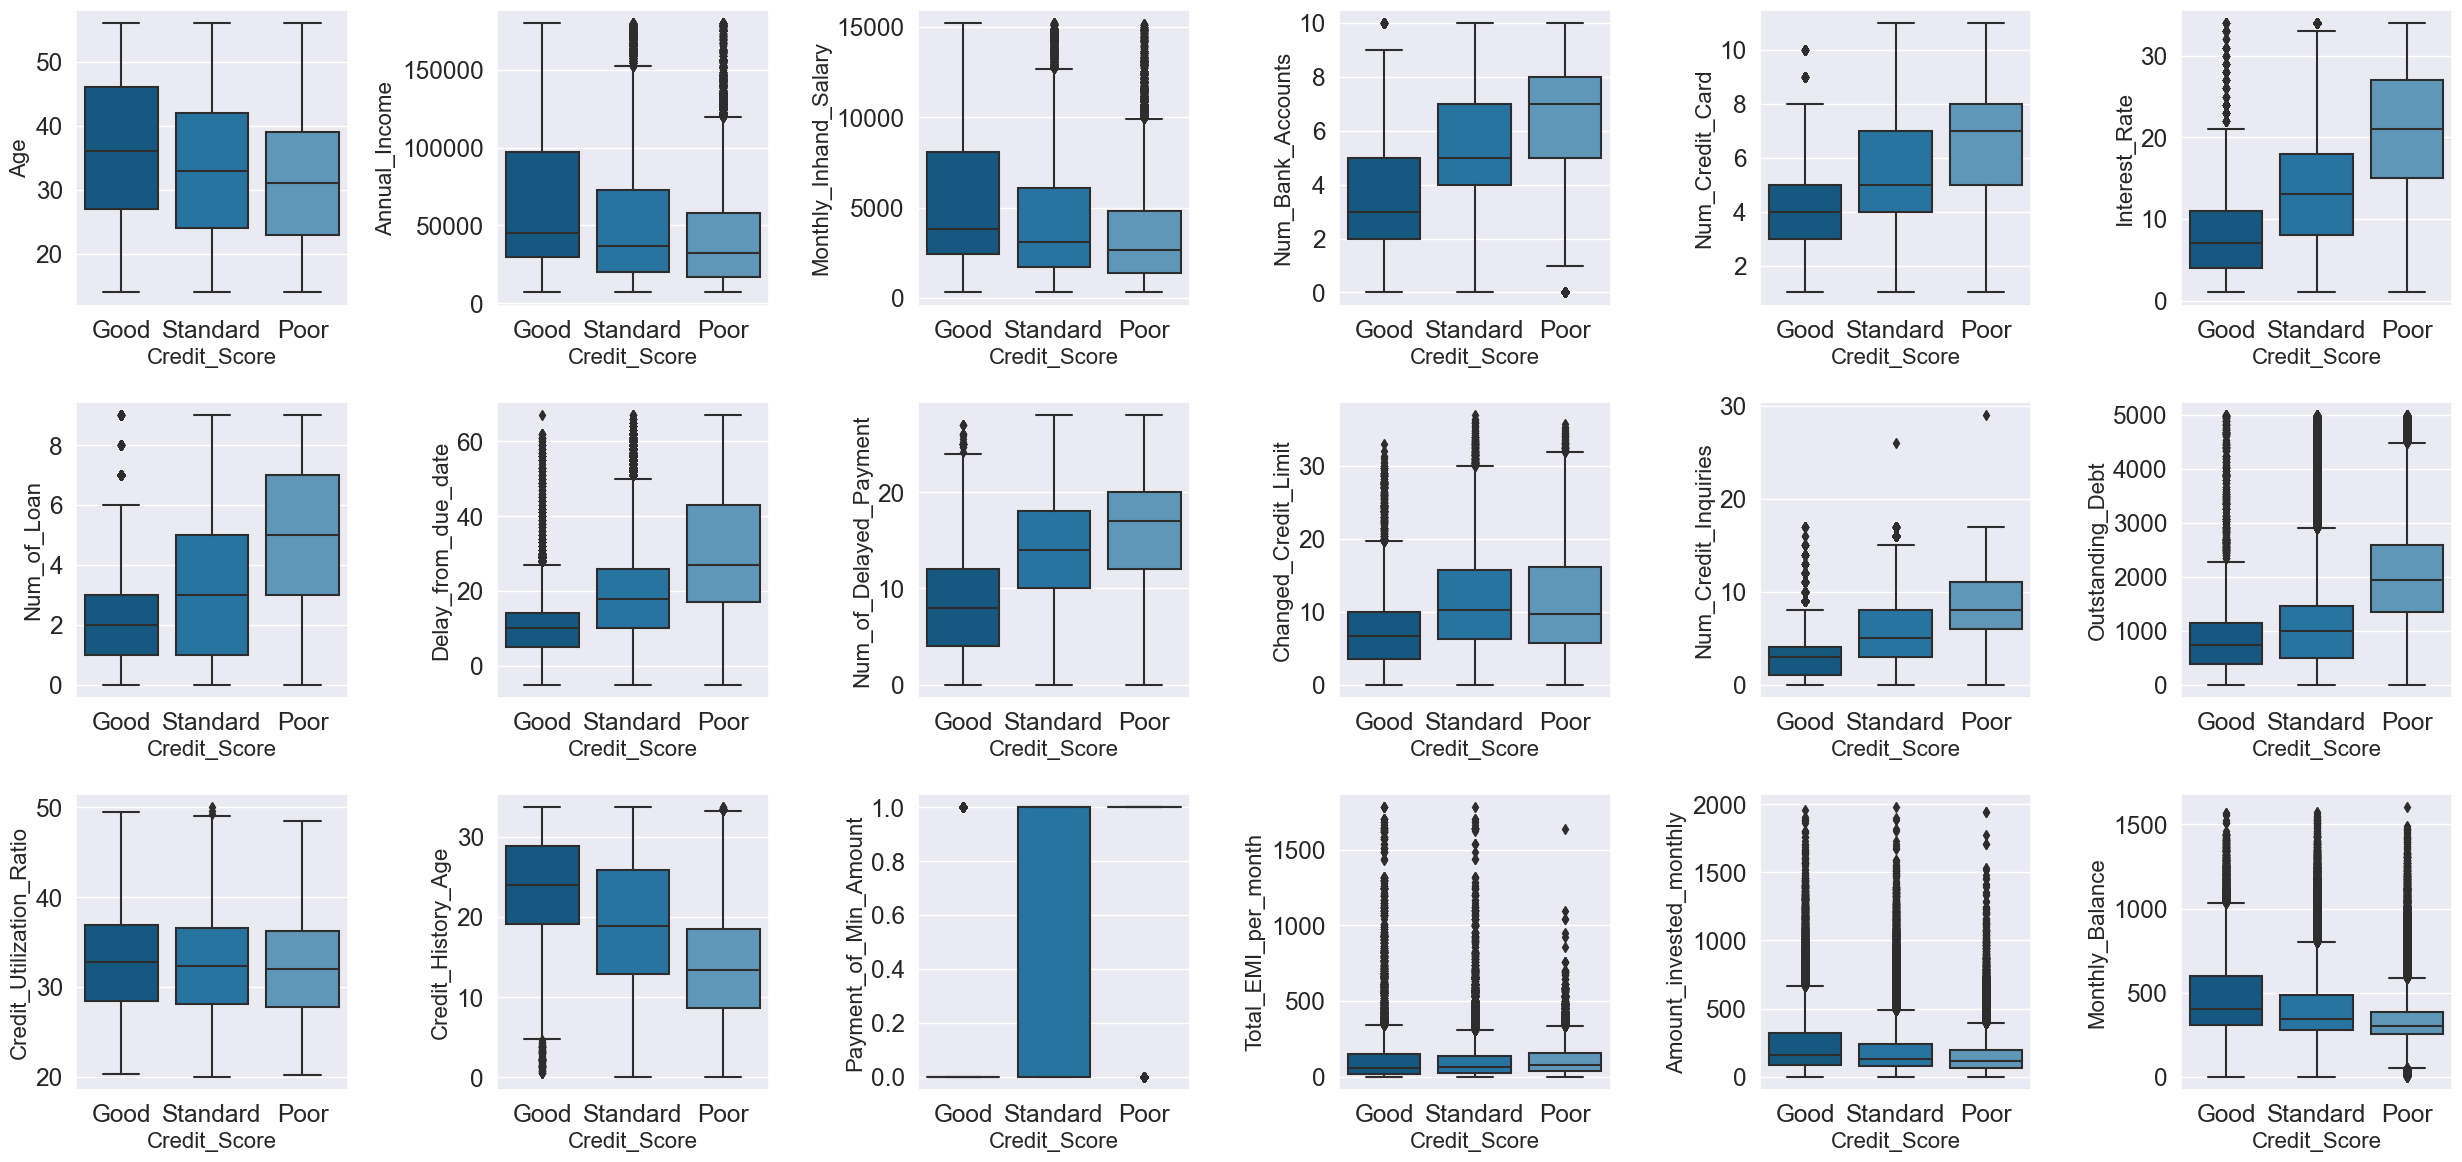

In [133]:
colunas = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance']

figura = plt.figure()

sns.set(font_scale=1.6) 
sns.set_palette('PuBu_r')

for i,var in enumerate(colunas):
    
    figura.add_subplot(3,6,i+1)
    sns.boxplot(x="Credit_Score",y=f'{var}',data=df1)
    
    plt.xlabel("Credit_Score", fontsize=16)  # Altere o tamanho da fonte do rótulo x conforme necessário
    plt.ylabel(f'{var}', fontsize=16)  # Altere o tamanho da fonte do rótulo y conforme necessário
   
plt.tight_layout()
plt.show()

In [ ]:
aux2 = df1.groupby('Credit_Score')['loan_type_PaydayLoan',
       'loan_type_PersonalLoan', 'loan_type_HomeEquityLoan',
       'loan_type_MortgageLoan', 'loan_type_AutoLoan',
       'loan_type_Credit-BuilderLoan', 'loan_type_StudentLoan',
       'loan_type_NotSpecified', 'loan_type_DebtConsolidationLoan'].sum().reset_index()

colunas = ['loan_type_PaydayLoan',
       'loan_type_PersonalLoan', 'loan_type_HomeEquityLoan',
       'loan_type_MortgageLoan', 'loan_type_AutoLoan',
       'loan_type_Credit-BuilderLoan', 'loan_type_StudentLoan',
       'loan_type_NotSpecified', 'loan_type_DebtConsolidationLoan']

figura = plt.figure()

sns.set(font_scale=1.6) 
sns.set_palette('PuBu_r')

for i,var in enumerate(colunas):
    
    figura.add_subplot(3,3,i+1)
    sns.barplot(x="Credit_Score",y=f'{var}',data=aux2)
    
    plt.xlabel("Credit_Score", fontsize=16)  # Altere o tamanho da fonte do rótulo x conforme necessário
    plt.ylabel(f'{var}', fontsize=16)  # Altere o tamanho da fonte do rótulo y conforme necessário
    
plt.tight_layout()
plt.show()

In [ ]:
aux3 = df1[df1['Credit_Score']=="Good"].groupby('Credit_Score')['loan_type_PaydayLoan',
       'loan_type_PersonalLoan', 'loan_type_HomeEquityLoan',
       'loan_type_MortgageLoan', 'loan_type_AutoLoan',
       'loan_type_Credit-BuilderLoan', 'loan_type_StudentLoan',
       'loan_type_NotSpecified', 'loan_type_DebtConsolidationLoan'].sum().T.reset_index()

aux3 = aux3.sort_values('Good',ascending=False)

sns.barplot(x="index",y="Good",data=aux3,palette='PuBu_d')
plt.xticks(rotation=45,fontsize=18)
plt.title("Loan Type x Good Credit Score",fontsize=32)
plt.tight_layout()


In [ ]:
aux4 = df1[df1['Credit_Score']=="Standard"].groupby('Credit_Score')['loan_type_PaydayLoan',
       'loan_type_PersonalLoan', 'loan_type_HomeEquityLoan',
       'loan_type_MortgageLoan', 'loan_type_AutoLoan',
       'loan_type_Credit-BuilderLoan', 'loan_type_StudentLoan',
       'loan_type_NotSpecified', 'loan_type_DebtConsolidationLoan'].sum().T.reset_index()

aux4 = aux4.sort_values('Standard',ascending=False)

sns.barplot(x="index",y="Standard",data=aux4,palette='PuBu_d')
plt.xticks(rotation=45,fontsize=18)
plt.title("Loan Type x Standard Credit Score",fontsize=32)
plt.tight_layout()

In [ ]:
aux5 = df1[df1['Credit_Score']=="Poor"].groupby('Credit_Score')['loan_type_PaydayLoan',
       'loan_type_PersonalLoan', 'loan_type_HomeEquityLoan',
       'loan_type_MortgageLoan', 'loan_type_AutoLoan',
       'loan_type_Credit-BuilderLoan', 'loan_type_StudentLoan',
       'loan_type_NotSpecified', 'loan_type_DebtConsolidationLoan'].sum().T.reset_index()

aux5

aux5 = aux5.sort_values('Poor',ascending=False)

sns.barplot(x="index",y="Poor",data=aux5,palette='PuBu_d')
plt.xticks(rotation=45,fontsize=18)
plt.title("Loan Type x Poor Credit Score",fontsize=32)
plt.tight_layout()

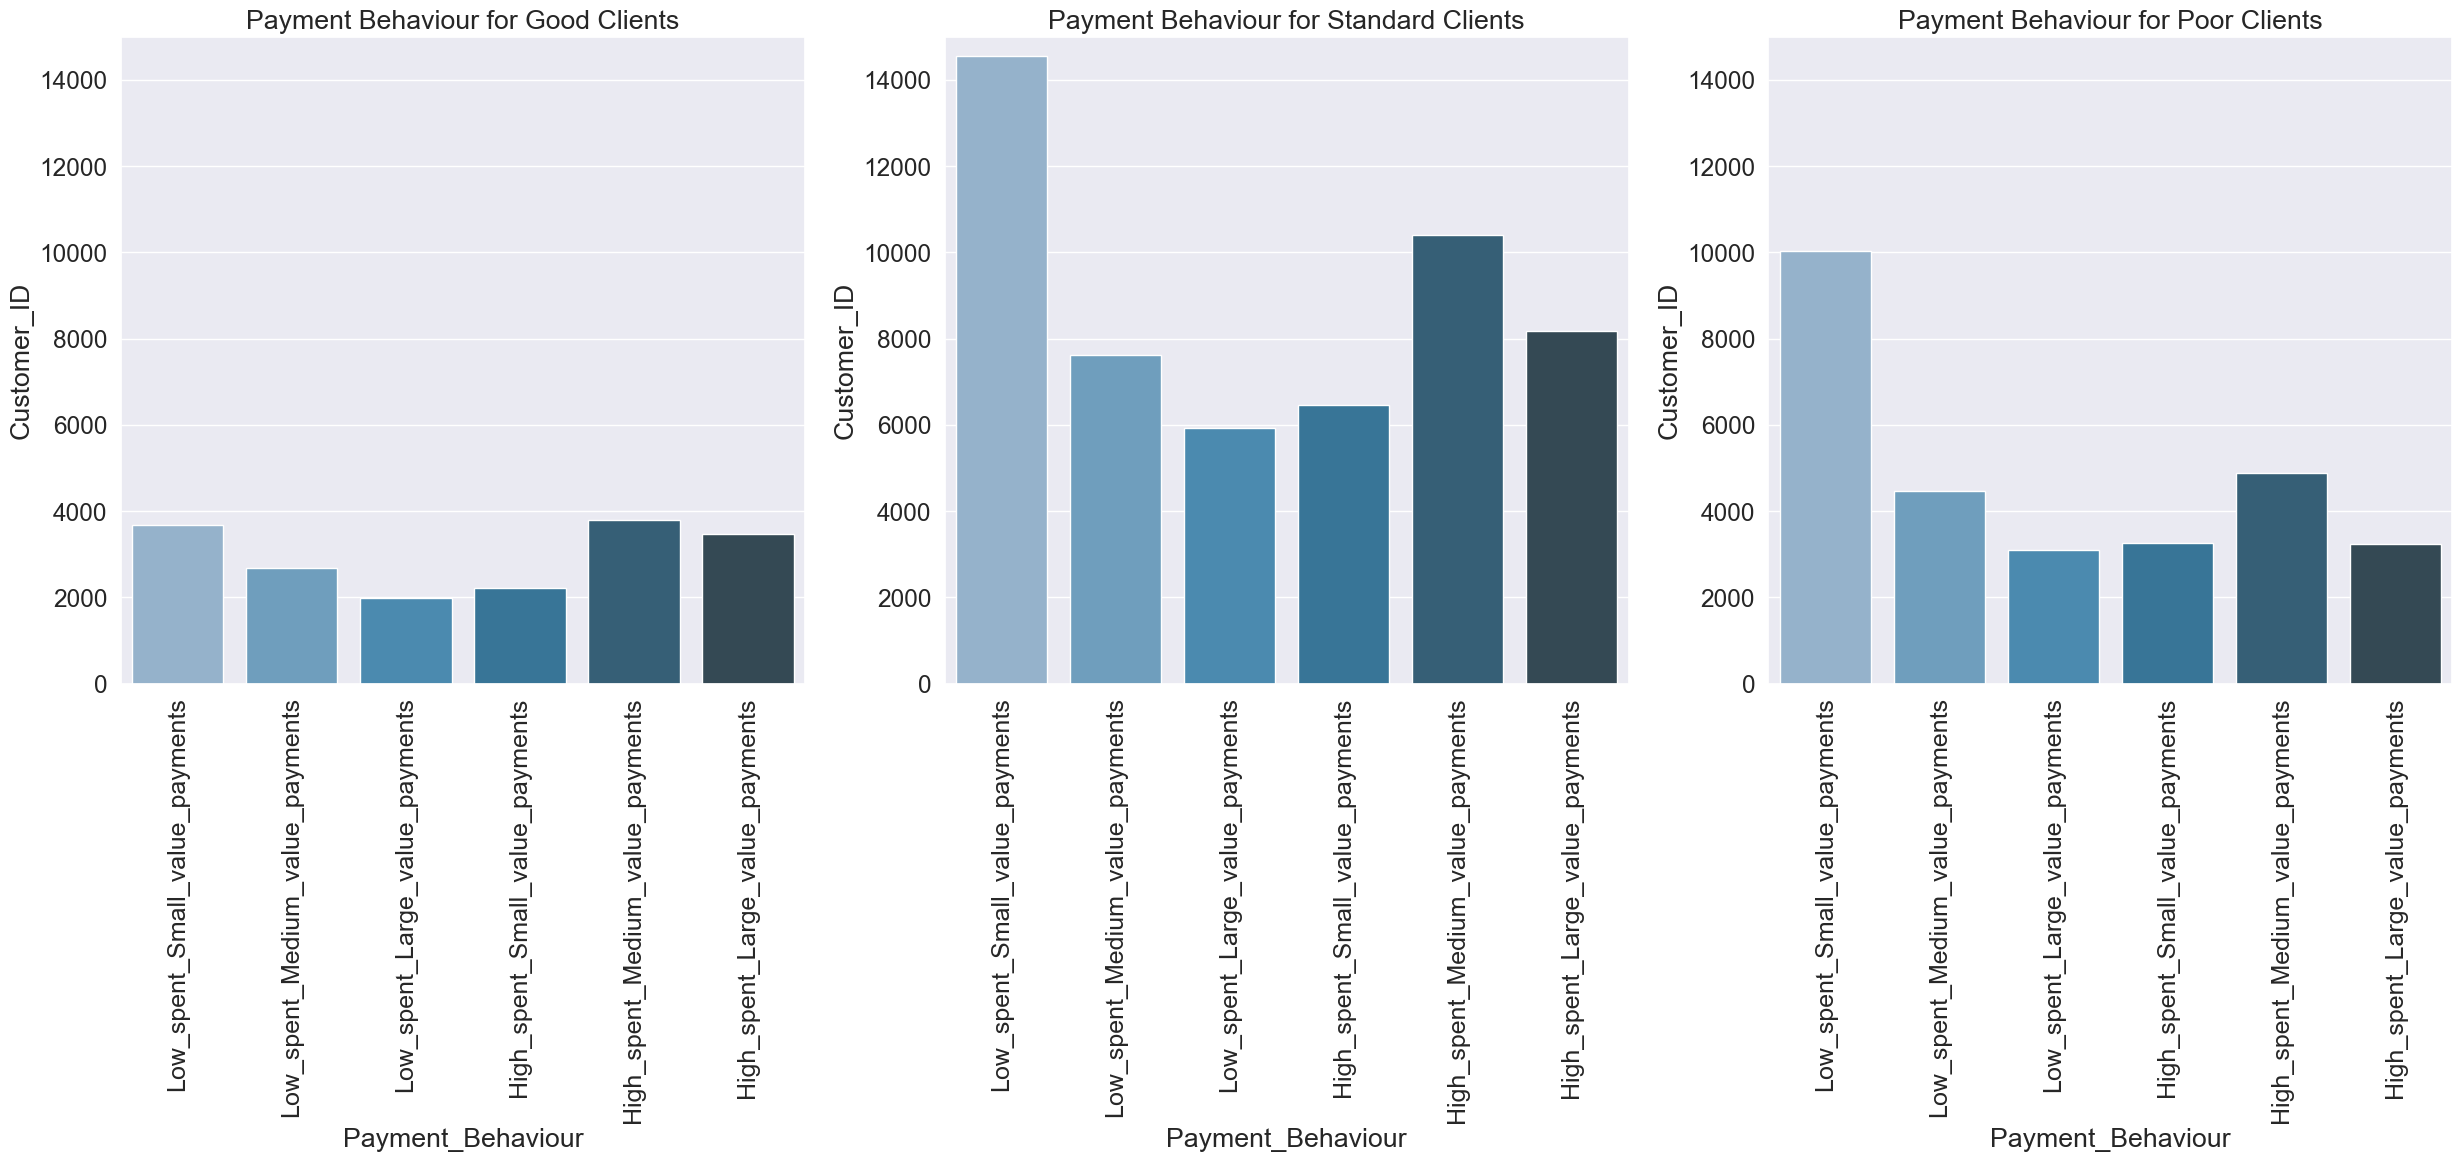

In [138]:
aux6 = df1.groupby(['Credit_Score','Payment_Behaviour'])['Customer_ID'].count().to_frame().reset_index()

aux6 = aux6.sort_values('Payment_Behaviour',ascending=False)

plt.subplot(1,3,1)
sns.barplot(x=aux6[aux6['Credit_Score']=='Good']['Payment_Behaviour'],y=aux6['Customer_ID'],palette='PuBu_d')
plt.title('Payment Behaviour for Good Clients')
plt.xticks(rotation=90,fontsize=18)
plt.ylim(0,15000)

plt.subplot(1,3,2)
sns.barplot(x=aux6[aux6['Credit_Score']=='Standard']['Payment_Behaviour'],y=aux6['Customer_ID'],palette='PuBu_d')
plt.title('Payment Behaviour for Standard Clients')
plt.xticks(rotation=90,fontsize=18)
plt.ylim(0,15000)

plt.subplot(1,3,3)
sns.barplot(x=aux6[aux6['Credit_Score']=='Poor']['Payment_Behaviour'],y=aux6['Customer_ID'],palette='PuBu_d')
plt.title('Payment Behaviour for Poor Clients')
plt.xticks(rotation=90,fontsize=18)
plt.ylim(0,15000)

plt.tight_layout()

### Matriz de correlação

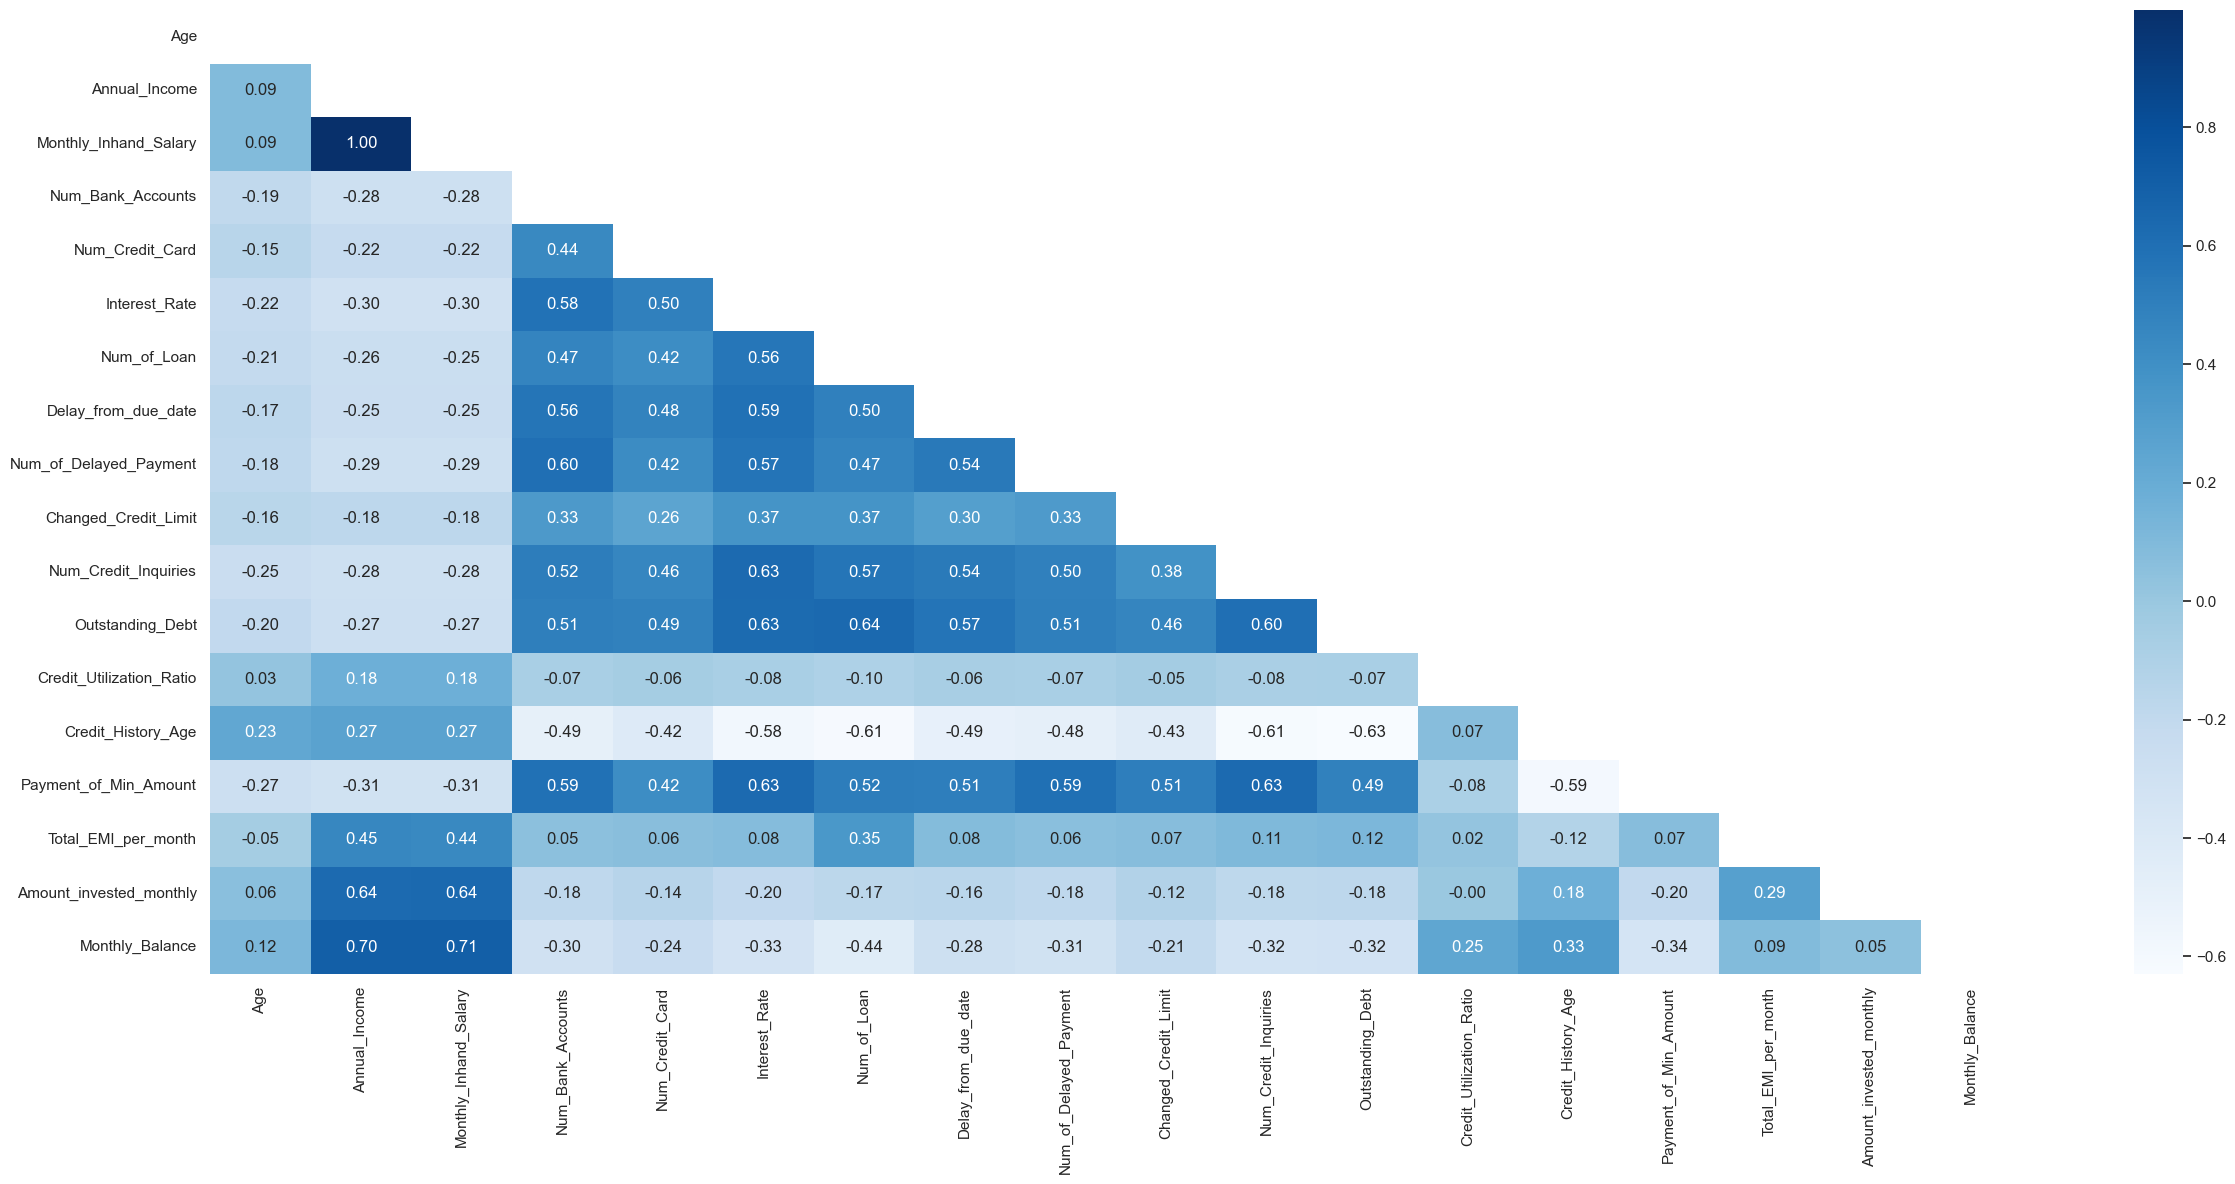

In [139]:
aux_corr = df1[['Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score']]

sns.set(style="white")

correlation_matrix= aux_corr.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, cmap= 'Blues', annot=True, fmt=".2f", mask=mask)
plt.tight_layout()

Variavel Annual_income e Monthly_inhand_salary colineares (vamos excluir uma do modelo)

### Matriz de correlação com variáveis categoricas

In [140]:
# Grupo 1 
a1  = cramer_v(df1['Credit_Score'],df1['Credit_Score'])
a2  = cramer_v(df1['Credit_Score'],df1['Payment_Behaviour'])
a3  = cramer_v(df1['Credit_Score'],df1['Payment_of_Min_Amount'])
a4  = cramer_v(df1['Credit_Score'],df1['Credit_Mix'])
a5  = cramer_v(df1['Credit_Score'],df1['loan_type_NotSpecified'])
a6  = cramer_v(df1['Credit_Score'],df1['loan_type_HomeEquityLoan'])
a7  = cramer_v(df1['Credit_Score'],df1['loan_type_PaydayLoan'])
a8  = cramer_v(df1['Credit_Score'],df1['loan_type_DebtConsolidationLoan'])
a9  = cramer_v(df1['Credit_Score'],df1['loan_type_MortgageLoan'])
a10 = cramer_v(df1['Credit_Score'],df1['loan_type_AutoLoan'])
a11 = cramer_v(df1['Credit_Score'],df1['loan_type_StudentLoan'])
a12 = cramer_v(df1['Credit_Score'],df1['loan_type_Credit-BuilderLoan'])
a13 = cramer_v(df1['Credit_Score'],df1['loan_type_PersonalLoan'])


# Grupo 2
a14 = cramer_v(df1['Payment_Behaviour'],df1['Credit_Score'])
a15 = cramer_v(df1['Payment_Behaviour'],df1['Payment_Behaviour'])
a16 = cramer_v(df1['Payment_Behaviour'],df1['Payment_of_Min_Amount'])
a17 = cramer_v(df1['Payment_Behaviour'],df1['Credit_Mix'])
a18 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_NotSpecified'])
a19 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_HomeEquityLoan'])
a20 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_PaydayLoan'])
a21 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_DebtConsolidationLoan'])
a22 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_MortgageLoan'])
a23 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_AutoLoan'])
a24 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_StudentLoan'])
a25 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_Credit-BuilderLoan'])
a26 = cramer_v(df1['Payment_Behaviour'],df1['loan_type_PersonalLoan'])


# Grupo 3
a27 = cramer_v(df1['Payment_of_Min_Amount'],df1['Credit_Score'])
a28 = cramer_v(df1['Payment_of_Min_Amount'],df1['Payment_Behaviour'])
a29 = cramer_v(df1['Payment_of_Min_Amount'],df1['Payment_of_Min_Amount'])
a30 = cramer_v(df1['Payment_of_Min_Amount'],df1['Credit_Mix'])
a31 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_NotSpecified'])
a32 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_HomeEquityLoan'])
a33 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_PaydayLoan'])
a34 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_DebtConsolidationLoan'])
a35 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_MortgageLoan'])
a36 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_AutoLoan'])
a37 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_StudentLoan'])
a38 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_Credit-BuilderLoan'])
a39 = cramer_v(df1['Payment_of_Min_Amount'],df1['loan_type_PersonalLoan'])

# Grupo 4
a40 = cramer_v(df1['Credit_Mix'],df1['Credit_Score'])
a41 = cramer_v(df1['Credit_Mix'],df1['Payment_Behaviour'])
a42 = cramer_v(df1['Credit_Mix'],df1['Payment_of_Min_Amount'])
a43 = cramer_v(df1['Credit_Mix'],df1['Credit_Mix'])
a44 = cramer_v(df1['Credit_Mix'],df1['loan_type_NotSpecified'])
a45 = cramer_v(df1['Credit_Mix'],df1['loan_type_HomeEquityLoan'])
a46 = cramer_v(df1['Credit_Mix'],df1['loan_type_PaydayLoan'])
a47 = cramer_v(df1['Credit_Mix'],df1['loan_type_DebtConsolidationLoan'])
a48 = cramer_v(df1['Credit_Mix'],df1['loan_type_MortgageLoan'])
a49 = cramer_v(df1['Credit_Mix'],df1['loan_type_AutoLoan'])
a50 = cramer_v(df1['Credit_Mix'],df1['loan_type_StudentLoan'])
a51 = cramer_v(df1['Credit_Mix'],df1['loan_type_Credit-BuilderLoan'])
a52 = cramer_v(df1['Credit_Mix'],df1['loan_type_PersonalLoan'])

# Grupo 5
a53 = cramer_v(df1['loan_type_NotSpecified'],df1['Credit_Score'])
a54 = cramer_v(df1['loan_type_NotSpecified'],df1['Payment_Behaviour'])
a55 = cramer_v(df1['loan_type_NotSpecified'],df1['Payment_of_Min_Amount'])
a56 = cramer_v(df1['loan_type_NotSpecified'],df1['Credit_Mix'])
a57 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_NotSpecified'])
a58 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_HomeEquityLoan'])
a59 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_PaydayLoan'])
a60 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_DebtConsolidationLoan'])
a61 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_MortgageLoan'])
a62 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_AutoLoan'])
a63 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_StudentLoan'])
a64 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_Credit-BuilderLoan'])
a65 = cramer_v(df1['loan_type_NotSpecified'],df1['loan_type_PersonalLoan'])

# Grupo 6
a66 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['Credit_Score'])
a67 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['Payment_Behaviour'])
a68 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['Payment_of_Min_Amount'])
a69 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['Credit_Mix'])
a70 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_NotSpecified'])
a71 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_HomeEquityLoan'])
a72 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_PaydayLoan'])
a73 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_DebtConsolidationLoan'])
a74 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_MortgageLoan'])
a75 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_AutoLoan'])
a76 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_StudentLoan'])
a77 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_Credit-BuilderLoan'])
a78 = cramer_v(df1['loan_type_HomeEquityLoan'],df1['loan_type_PersonalLoan'])

# Grupo 7
a79 = cramer_v(df1['loan_type_PaydayLoan'],df1['Credit_Score'])
a80 = cramer_v(df1['loan_type_PaydayLoan'],df1['Payment_Behaviour'])
a81 = cramer_v(df1['loan_type_PaydayLoan'],df1['Payment_of_Min_Amount'])
a82 = cramer_v(df1['loan_type_PaydayLoan'],df1['Credit_Mix'])
a83 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_NotSpecified'])
a84 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_HomeEquityLoan'])
a85 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_PaydayLoan'])
a86 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_DebtConsolidationLoan'])
a87 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_MortgageLoan'])
a88 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_AutoLoan'])
a89 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_StudentLoan'])
a90 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_Credit-BuilderLoan'])
a91 = cramer_v(df1['loan_type_PaydayLoan'],df1['loan_type_PersonalLoan'])

# Grupo 8
a92  = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['Credit_Score'])
a93  = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['Payment_Behaviour'])
a94  = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['Payment_of_Min_Amount'])
a95  = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['Credit_Mix'])
a96  = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_NotSpecified'])
a97  = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_HomeEquityLoan'])
a98  = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_PaydayLoan'])
a99  = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_DebtConsolidationLoan'])
a100 = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_MortgageLoan'])
a101 = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_AutoLoan'])
a102 = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_StudentLoan'])
a103 = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_Credit-BuilderLoan'])
a104 = cramer_v(df1['loan_type_DebtConsolidationLoan'],df1['loan_type_PersonalLoan'])

# Grupo 9
a105  = cramer_v(df1['loan_type_MortgageLoan'],df1['Credit_Score'])
a106  = cramer_v(df1['loan_type_MortgageLoan'],df1['Payment_Behaviour'])
a107  = cramer_v(df1['loan_type_MortgageLoan'],df1['Payment_of_Min_Amount'])
a108  = cramer_v(df1['loan_type_MortgageLoan'],df1['Credit_Mix'])
a109  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_NotSpecified'])
a110  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_HomeEquityLoan'])
a111  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_PaydayLoan'])
a112  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_DebtConsolidationLoan'])
a113  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_MortgageLoan'])
a114  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_AutoLoan'])
a115  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_StudentLoan'])
a116  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_Credit-BuilderLoan'])
a117  = cramer_v(df1['loan_type_MortgageLoan'],df1['loan_type_PersonalLoan'])

# Grupo 10
a118  = cramer_v(df1['loan_type_AutoLoan'],df1['Credit_Score'])
a119  = cramer_v(df1['loan_type_AutoLoan'],df1['Payment_Behaviour'])
a120  = cramer_v(df1['loan_type_AutoLoan'],df1['Payment_of_Min_Amount']) 
a121  = cramer_v(df1['loan_type_AutoLoan'],df1['Credit_Mix'])
a122  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_NotSpecified'])
a123  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_HomeEquityLoan'])
a124  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_PaydayLoan'])
a125  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_DebtConsolidationLoan'])
a126  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_MortgageLoan'])
a127  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_AutoLoan'])
a128  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_StudentLoan'])
a129  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_Credit-BuilderLoan'])
a130  = cramer_v(df1['loan_type_AutoLoan'],df1['loan_type_PersonalLoan'])

# Grupo 11
a131 = cramer_v(df1['loan_type_StudentLoan'],df1['Credit_Score'])
a132 = cramer_v(df1['loan_type_StudentLoan'],df1['Payment_Behaviour'])
a133 = cramer_v(df1['loan_type_StudentLoan'],df1['Payment_of_Min_Amount'])
a134 = cramer_v(df1['loan_type_StudentLoan'],df1['Credit_Mix'])
a135 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_NotSpecified'])
a136 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_HomeEquityLoan'])
a137 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_PaydayLoan'])
a138 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_DebtConsolidationLoan'])
a139 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_MortgageLoan'])
a140 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_AutoLoan'])
a141 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_StudentLoan'])
a142 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_Credit-BuilderLoan'])
a143 = cramer_v(df1['loan_type_StudentLoan'],df1['loan_type_PersonalLoan'])

# Grupo 12
a144 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['Credit_Score'])
a145 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['Payment_Behaviour'])
a146 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['Payment_of_Min_Amount'])
a147 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['Credit_Mix'])
a148 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_NotSpecified'])
a149 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_HomeEquityLoan'])
a150 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_PaydayLoan'])
a151 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_DebtConsolidationLoan'])
a152 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_MortgageLoan'])
a153 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_AutoLoan'])
a154 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_StudentLoan'])
a155 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_Credit-BuilderLoan'])
a156 = cramer_v(df1['loan_type_Credit-BuilderLoan'],df1['loan_type_PersonalLoan'])

# Grupo 13
a157 = cramer_v(df1['loan_type_PersonalLoan'],df1['Credit_Score'])
a158 = cramer_v(df1['loan_type_PersonalLoan'],df1['Payment_Behaviour'])
a159 = cramer_v(df1['loan_type_PersonalLoan'],df1['Payment_of_Min_Amount'])
a160 = cramer_v(df1['loan_type_PersonalLoan'],df1['Credit_Mix'])
a161 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_NotSpecified'])
a162 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_HomeEquityLoan'])
a163 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_PaydayLoan'])
a164 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_DebtConsolidationLoan'])
a165 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_MortgageLoan'])
a166 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_AutoLoan'])
a167 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_StudentLoan'])
a168 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_Credit-BuilderLoan'])
a169 = cramer_v(df1['loan_type_PersonalLoan'],df1['loan_type_PersonalLoan'])

In [141]:
d = pd.DataFrame({'Credit_Score':                    [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13],
                  'Payment_Behaviour':               [a14,a15,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25,a26],
                  'Payment_of_Min_Amount':           [a27,a28,a29,a30,a31,a32,a33,a34,a35,a36,a37,a38,a39],
                  'Credit_Mix':                      [a40,a41,a42,a43,a44,a45,a46,a47,a48,a49,a50,a51,a52],
                  'loan_type_NotSpecified':          [a53,a54,a55,a56,a57,a58,a59,a60,a61,a62,a63,a64,a65],
                  'loan_type_HomeEquityLoan':        [a66,a67,a68,a69,a70,a71,a72,a73,a74,a75,a76,a77,a78],
                  'loan_type_PaydayLoan':            [a79,a80,a81,a82,a83,a84,a85,a86,a87,a88,a89,a90,a91],
                  'loan_type_DebtConsolidationLoan': [a92,a93,a94,a95,a96,a97,a98,a99,a100,a101,a102,a103,a104],
                  'loan_type_MortgageLoan':          [a105,a106,a107,a108,a109,a110,a111,a112,a113,a114,a115,a116,a117],
                  'loan_type_AutoLoan':              [a118,a119,a120,a121,a122,a123,a124,a125,a126,a127,a128,a129,a130],
                  'loan_type_StudentLoan':           [a131,a132,a133,a134,a135,a136,a137,a138,a139,a140,a141,a142,a143],
                  'loan_type_Credit-BuilderLoan':    [a144,a145,a146,a147,a148,a149,a150,a151,a152,a153,a154,a155,a156],
                  'loan_type_PersonalLoan':          [a157,a158,a159,a160,a161,a162,a163,a164,a165,a166,a167,a168,a169]})

d = d.set_index(d.columns)

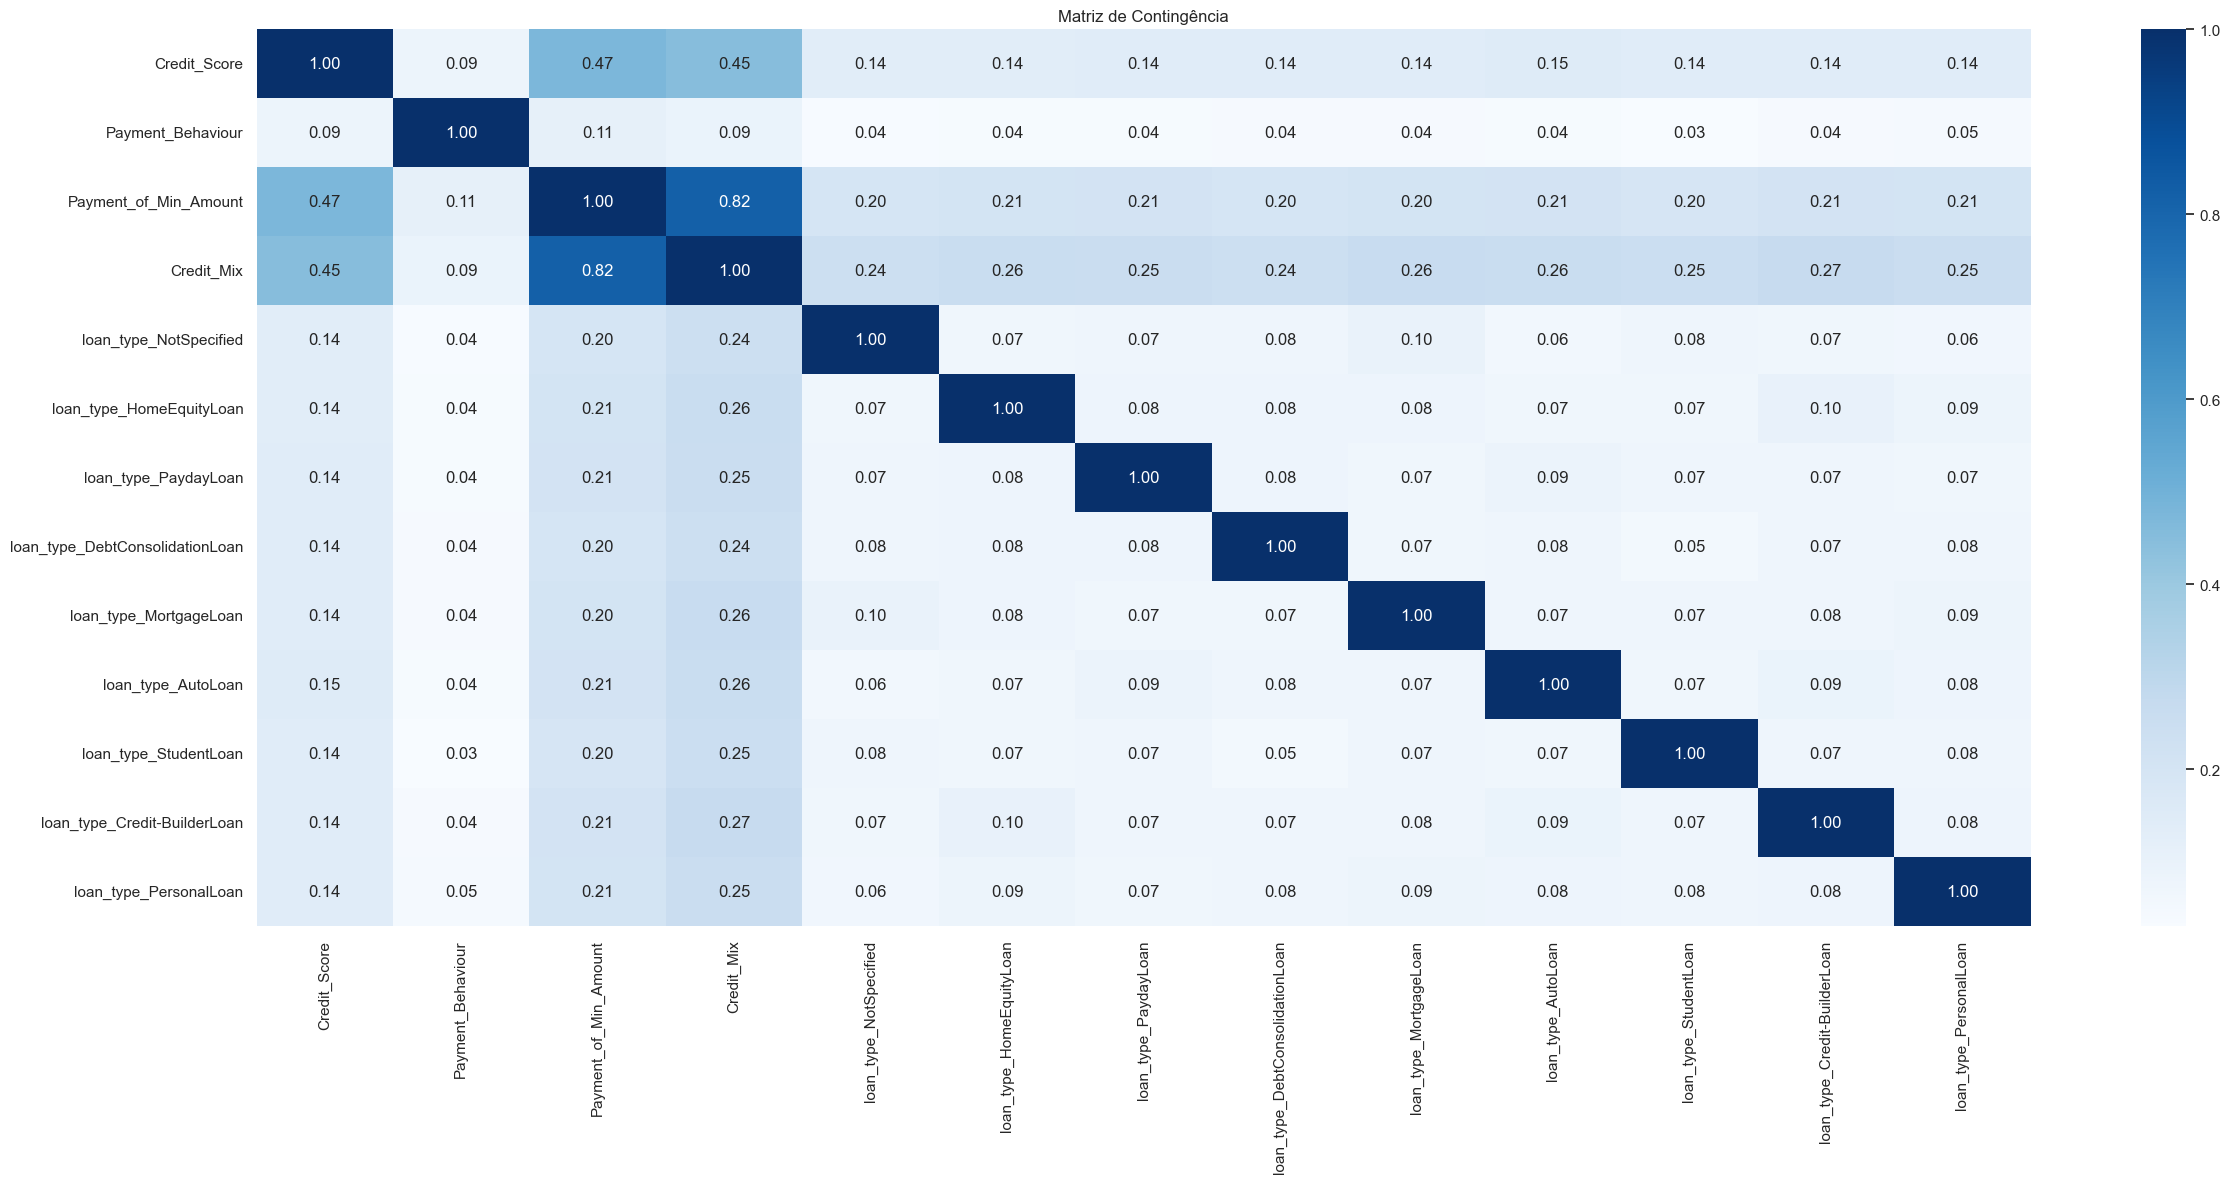

In [142]:
# matriz de contingência
sns.set(style="white")
sns.heatmap(d, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Contingência")
plt.tight_layout()
plt.show()

# Transformação das Variáveis

## Setando Base

In [143]:
df2 = df1.copy()

In [144]:
rs = RobustScaler()
mms = MinMaxScaler()
le = LabelEncoder()

## Month

In [145]:
df2['Month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [146]:
month_dict = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8}

df2['Month'] = df2['Month'].map(month_dict)

df2['Month_sin'] = df2['Month'].apply(lambda x: np.sin( x*(2 * np.pi/12)))
df2['Month_cos'] = df2['Month'].apply(lambda x: np.cos( x*(2 * np.pi/12)))

## Age

In [147]:
df2['Age'] = mms.fit_transform(df2[['Age']].values)

## Occupation

In [148]:
df2['Occupation'] = le.fit_transform(df2['Occupation'])
df2['Occupation'].unique()

array([12, 13,  4,  5,  2,  7, 10,  3,  6,  8,  0, 11,  9, 14,  1])

## Annual_Income

In [149]:
df2['Annual_Income'] = rs.fit_transform(df2[['Annual_Income']].values)

## Monthly_Inhand_Salary

In [ ]:
sns.boxplot(df2['Monthly_Inhand_Salary'])

In [ ]:
df2['Monthly_Inhand_Salary'] = rs.fit_transform(df2[['Monthly_Inhand_Salary']].values)
sns.boxplot(df2['Monthly_Inhand_Salary'])

## Interest_Rate

In [152]:
df2['Interest_Rate'] = mms.fit_transform(df2[['Interest_Rate']].values)

## Changed_Credit_Limit

In [153]:
df2['Changed_Credit_Limit'] = rs.fit_transform(df2[['Changed_Credit_Limit']].values)

## Credit_Mix

In [154]:
df2['Credit_Mix'].unique()

array(['Good', 'Standard', 'Bad'], dtype=object)

In [155]:
df2['Credit_Mix'] = le.fit_transform(df2['Credit_Mix'])
df2['Credit_Mix'].unique()

array([1, 2, 0])

## Outstanding_Debt

In [156]:
df2['Outstanding_Debt'] = rs.fit_transform(df2[['Outstanding_Debt']].values)

## Credit_Utilization_Ratio

In [157]:
df2['Credit_Utilization_Ratio'] = mms.fit_transform(df2[['Credit_Utilization_Ratio']].values)

## Credit_History_Age

In [158]:
df2['Credit_History_Age'] = mms.fit_transform(df2[['Credit_History_Age']].values)

## Total_EMI_per_month

In [159]:
df2['Total_EMI_per_month'] = rs.fit_transform(df2[['Total_EMI_per_month']].values)

## Amount_invested_monthly

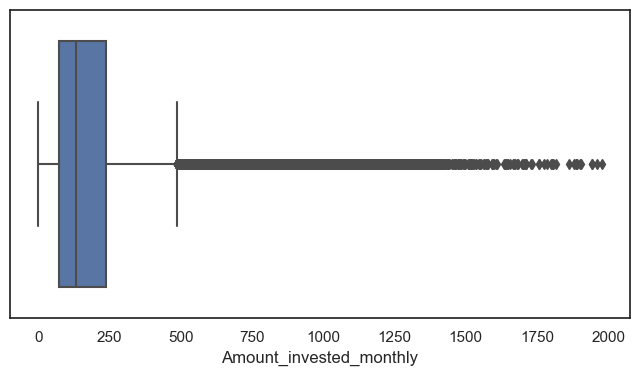

In [160]:
plt.figure(figsize=(8,4));
sns.boxplot(x=df2['Amount_invested_monthly']);
plt.show()

In [161]:
df2['Amount_invested_monthly'] = rs.fit_transform(df2[['Amount_invested_monthly']].values)

## Payment_Behaviour

In [162]:
df2['Payment_Behaviour'].unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments',
       'High_spent_Large_value_payments'], dtype=object)

In [163]:
df2['Payment_Behaviour'] = le.fit_transform(df2['Payment_Behaviour'])

## Monthly_Balance

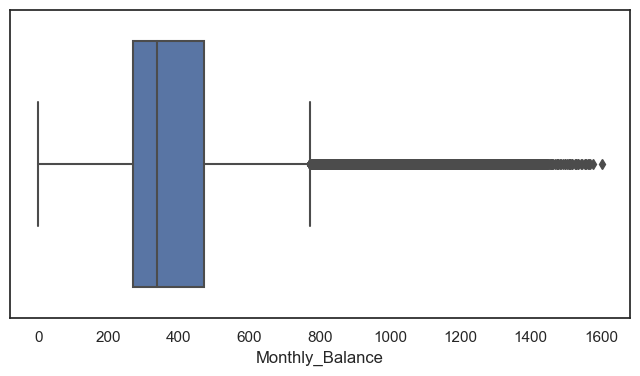

In [164]:
plt.figure(figsize=(8,4));
sns.boxplot(x=df2['Monthly_Balance']);
plt.show()

In [165]:
df2['Monthly_Balance'] = rs.fit_transform(df2[['Monthly_Balance']].values)

## Credit_Score

In [166]:
df2['Credit_Score'].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

In [167]:
df2['Credit_Score'].value_counts(dropna=False)

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

In [168]:
df2['Credit_Score'] = le.fit_transform(df2['Credit_Score'])

In [169]:
df2['Credit_Score'].value_counts(dropna=False)

2    53174
1    28998
0    17828
Name: Credit_Score, dtype: int64

# Feature Selection

In [170]:
df3 = df2.copy()

In [171]:
x = df3[['Month',
         'Age', 
         'Occupation', 
         'Annual_Income',
         'Monthly_Inhand_Salary', 
         'Num_Bank_Accounts', 
         'Num_Credit_Card',
         'Interest_Rate', 
         'Num_of_Loan', 
         'Delay_from_due_date',
         'Num_of_Delayed_Payment', 
         'Changed_Credit_Limit',
         'Num_Credit_Inquiries', 
         'Credit_Mix', 
         'Outstanding_Debt',
         'Credit_Utilization_Ratio', 
         'Credit_History_Age',
         'Payment_of_Min_Amount', 
         'Total_EMI_per_month',
         'Amount_invested_monthly', 
         'Payment_Behaviour', 
         'Monthly_Balance',
         'loan_type_PersonalLoan',
         'loan_type_Credit-BuilderLoan', 
         'loan_type_DebtConsolidationLoan',
         'loan_type_HomeEquityLoan', 
         'loan_type_AutoLoan',
         'loan_type_NotSpecified', 
         'loan_type_StudentLoan',
         'loan_type_MortgageLoan', 
         'loan_type_PaydayLoan', 
         'Month_sin',
         'Month_cos']]


y = df3[['Credit_Score']]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [172]:
x_train_n = x_train.values
y_train_n = y_train.values.ravel()

In [173]:
#rf = RandomForestRegressor(n_jobs = -1) #usa todos os cores do processador
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 129718).fit(x_train_n,y_train_n)

In [174]:
# cols_selected = boruta.support_.tolist()

# #Best features
# cols_selected_boruta = x_train.iloc[:,cols_selected].columns

# #Not selected
# cols_not_selected_boruta = list(np.setdiff1d(x_train.columns,cols_selected_boruta))

# ## As colunas selecionadas pelo algoritmo convergem com os resultados expressos na análise das correlações das variáveis

In [175]:
# rf = RandomForestClassifier(n_jobs = -1, n_estimators=100, random_state= 129718) #usa todos os cores do processador
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 129718).fit(x_train_n,y_train_n)

In [176]:
# cols_selected = boruta.support_.tolist()

# #Best features
# cols_selected_boruta = x_train.iloc[:,cols_selected].columns

# #Not selected
# cols_not_selected_boruta = list(np.setdiff1d(x_train.columns,cols_selected_boruta))
# ## As colunas selecionadas pelo algoritmo convergem com os resultados expressos na análise das correlações das variáveis

In [177]:
#cols_not_selected_boruta

In [178]:
#cols_selected_boruta

In [179]:
cols_selected_boruta = [#'Age',
                        #'Credit_Utilization_Ratio',
                        #'Num_of_Loan',
                        'Payment_Behaviour',
                        'Annual_Income', 
                        'Monthly_Inhand_Salary', 
                        'Num_Bank_Accounts',
                        'Num_Credit_Card', 
                        'Interest_Rate', 
                        'Delay_from_due_date',
                        'Num_of_Delayed_Payment',
                        'Changed_Credit_Limit',
                        'Num_Credit_Inquiries', 
                        'Credit_Mix', 
                        'Outstanding_Debt',
                        'Credit_History_Age', 
                        'Payment_of_Min_Amount', 
                        'Total_EMI_per_month',
                        'Amount_invested_monthly', 
                        'Monthly_Balance']

# Machine Learning Models

In [180]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

## XGBoost

In [181]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", 
                              num_class=3,
                              n_estimators= 100,
                              max_depth = 10,
                              subsample = 0.7,
                              colsample_bytree = 0.9)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.7989
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      5322
           1       0.80      0.80      0.80      8805
           2       0.81      0.82      0.81     15873

    accuracy                           0.80     30000
   macro avg       0.79      0.79      0.79     30000
weighted avg       0.80      0.80      0.80     30000



In [182]:
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=10)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores)}")

Cross-validation scores: [0.80042857 0.79357143 0.78842857 0.79128571 0.794      0.79028571
 0.79714286 0.78285714 0.78728571 0.78828571]
Mean CV score: 0.7913571428571429


## LightGBM

In [ ]:
lgb_model = lgb.LGBMClassifier(objective='multiclass',
                               num_class=3, 
                               n_estimators=100,  # Número de árvores (estimadores)
                               max_depth=10,       # Profundidade máxima das árvores
                               learning_rate=0.1,
                               num_leaves=31                               
                               )

lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

In [ ]:
cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=10)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores)}")

## RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, 
                                  max_depth=10)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

In [ ]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores)}")

## LogisticRegression

In [ ]:
# Crie uma instância do modelo de regressão logística multinomial
logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Treine o modelo com os dados de treinamento
logistic_regression_model.fit(X_train, y_train)

# Faça previsões com o modelo treinado
y_pred = logistic_regression_model.predict(X_test)

# Avalie o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Relatório de Classificação:\n{report}")

In [ ]:
cv_scores = cross_val_score(logistic_regression_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores)}")

## Extra Tree Classifier

In [189]:
# Cria uma instância do classificador ExtraTreeClassifier
clf = ExtraTreeClassifier(random_state=42)
# Treina o modelo usando os dados de treinamento
clf.fit(X_train, y_train)
# Realiza previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Calcula a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)
report = classification_report(y_test, y_pred)
print(f"Relatório de Classificação:\n{report}")

Acurácia do modelo: 0.7280666666666666
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      5322
           1       0.72      0.71      0.72      8805
           2       0.75      0.76      0.76     15873

    accuracy                           0.73     30000
   macro avg       0.71      0.71      0.71     30000
weighted avg       0.73      0.73      0.73     30000



In [190]:
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores)}")

Cross-validation scores: [0.69428571 0.71035714 0.71285714 0.70128571 0.70792857]
Mean CV score: 0.7053428571428572


# Hyperparameter Fine Tuning 

In [ ]:
param = {'n_estimators':[700,1000,1500,2000], 
         'max_depth':[5,9,10,13,17],
         'eta':[0.1,0.3,0.5,0.7],
         'learning_rate':[0.1,0.3,0.5,0.7],
         'subsample': [0.3,0.5,0.7,0.9],
         'colsample_bytree': [0.3,0.5,0.7,0.9]}

gs2 = GridSearchCV(xgb.XGBClassifier(n_jobs=-1,num_class=3,objective='multi.softmax'), param, n_jobs=-1, cv=KFold(n_splits=3), scoring='accuracy')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

Best score: 0.7886714021590188

Best score: 'colsample_bytree': 0.3, 'max_depth': 10, 'n_estimators': 700, 'subsample': 0.9